# 로지스틱 모델 이용전 전처리

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.7 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#method : scaling, log transformation, cube Root normalization, Box-Cox transformation
from scipy.stats import skew 
from scipy.stats import boxcox

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [123]:
df = pd.read_csv('/content/drive/MyDrive/기계학습 팀플/heart_2020_cleaned.csv')
df.shape

(319795, 18)

In [124]:
df = df.drop_duplicates()
df.shape

(301717, 18)

In [125]:
# noise 처리
df = df[(df['BMI'] < 80) & (df['SleepTime'] != 24)]
df.shape

(301653, 18)

In [126]:
def yesno_tolabel(x):
    if (x == 'Yes') | (x == 'Yes (during pregnancy)') :
        return 1
    else:
        return 0

In [127]:
sex_map = {'Female' : 0, 'Male' : 1}
health_map = {'Excellent' : 4, 'Very good' : 3, 'Good' : 2, 'Fair' : 1, 'Poor' : 0}
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
age_map = {'18-24' : 20, '25-29' : 25, '30-34' : 30, '35-39' : 35, '40-44' : 40, '45-49' : 45, '50-54' : 50, '55-59' : 55, '60-64' : 60, '65-69' : 65, '70-74' : 70, '75-79' : 75, '80 or older' : 80}
columns = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
for column in columns:
    df[column] = df[column].apply(lambda x : yesno_tolabel(x))

df['Sex'] = df['Sex'].map(sex_map)
df['GenHealth'] = df['GenHealth'].map(health_map)
df['Diabetic'] = df['Diabetic'].map(diabetic_map)
df['AgeCategory'] = df['AgeCategory'].map(age_map)

In [128]:
df

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0                  0  16.60        1                0       0             3.0   
1                  0  20.34        0                0       1             0.0   
2                  0  26.58        1                0       0            20.0   
3                  0  24.21        0                0       0             0.0   
4                  0  23.71        0                0       0            28.0   
...              ...    ...      ...              ...     ...             ...   
319790             1  27.41        1                0       0             7.0   
319791             0  29.84        1                0       0             0.0   
319792             0  24.24        0                0       0             0.0   
319793             0  32.81        0                0       0             0.0   
319794             0  46.56        0                0       0             0.0   

        MentalHealth  DiffWalking  Sex  AgeCategory      Race  Diabetic  \
0               30.0            0    0           55     White         2   
1                0.0            0    0           80     White         0   
2               30.0            0    1           65     White         2   
3                0.0            0    0           75     White         0   
4                0.0            1    0           40     White         0   
...              ...          ...  ...          ...       ...       ...   
319790           0.0            1    1           60  Hispanic         2   
319791           0.0            0    1           35  Hispanic         0   
319792           0.0            0    0           45  Hispanic         0   
319793           0.0            0    0           25  Hispanic         0   
319794           0.0            0    0           80  Hispanic         0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0                      1          3        5.0       1              0   
1                      1          3        7.0       0              0   
2                      1          1        8.0       1              0   
3                      0          2        6.0       0              0   
4                      1          3        8.0       0              0   
...                  ...        ...        ...     ...            ...   
319790                 0          1        6.0       1              0   
319791                 1          3        5.0       1              0   
319792                 1          2        6.0       0              0   
319793                 0          2       12.0       0              0   
319794                 1          2        8.0       0              0   

        SkinCancer  
0                1  
1                0  
2                0  
3                1  
4                0  
...            ...  
319790           0  
319791           0  
319792           0  
319793           0  
319794           0  

[301653 rows x 18 columns]

In [129]:
def quantile_operation(outlier_df, column):
    quantile_1 = outlier_df[column].quantile(0.25)
    quantile_3 = outlier_df[column].quantile(0.75)
    iqr = quantile_3 - quantile_1
    Lower_tail = quantile_1 - 1.5 * iqr
    Upper_tail = quantile_3 + 1.5 * iqr

    return Lower_tail, Upper_tail

In [130]:

df['PhysicalHealth'] = df['PhysicalHealth'] + 1
df['MentalHealth'] = df['MentalHealth'] + 1
outlier_columns = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
for column in outlier_columns:
    Lower_tail, Upper_tail = quantile_operation(df, column)
    df[column] = boxcox(df[column])[0]

In [131]:
#Race 인코딩 - 원핫인코딩
from sklearn.preprocessing import OneHotEncoder
import numpy as np

ohe = OneHotEncoder(sparse = False)
train_race = ohe.fit_transform(df[['Race']])

ohe_hot_df = pd.DataFrame(train_race, columns = ohe.categories_)

df = df.reset_index().drop('index', axis = 1)

df = pd.concat([df, ohe_hot_df], axis = 1).drop('Race', axis = 1)

In [132]:
df

HeartDisease       BMI  Smoking  AlcoholDrinking  Stroke  \
0                  0  1.403407        1                0       0   
1                  0  1.442302        0                0       1   
2                  0  1.487128        1                0       0   
3                  0  1.472250        0                0       0   
4                  0  1.468816        0                0       0   
...              ...       ...      ...              ...     ...   
301648             1  1.491857        1                0       0   
301649             0  1.504497        1                0       0   
301650             0  1.472452        0                0       0   
301651             0  1.517915        0                0       0   
301652             0  1.561599        0                0       0   

        PhysicalHealth  MentalHealth  DiffWalking  Sex  AgeCategory  ...  \
0             0.669364      1.089487            0    0           55  ...   
1             0.000000      0.000000            0    0           80  ...   
2             0.801003      1.089487            0    1           65  ...   
3             0.000000      0.000000            0    0           75  ...   
4             0.807551      0.000000            1    0           40  ...   
...                ...           ...          ...  ...          ...  ...   
301648        0.755892      0.000000            1    1           60  ...   
301649        0.000000      0.000000            0    1           35  ...   
301650        0.000000      0.000000            0    0           45  ...   
301651        0.000000      0.000000            0    0           25  ...   
301652        0.000000      0.000000            0    0           80  ...   

        SleepTime  Asthma  KidneyDisease  SkinCancer  \
0        3.488639       1              0           1   
1        5.054525       0              0           0   
2        5.813435       1              0           0   
3        4.280563       0              0           1   
4        5.813435       0              0           0   
...           ...     ...            ...         ...   
301648   4.280563       1              0           0   
301649   3.488639       1              0           0   
301650   4.280563       0              0           0   
301651   8.734516       0              0           0   
301652   5.813435       0              0           0   

        (American Indian/Alaskan Native,)  (Asian,)  (Black,)  (Hispanic,)  \
0                                     0.0       0.0       0.0          0.0   
1                                     0.0       0.0       0.0          0.0   
2                                     0.0       0.0       0.0          0.0   
3                                     0.0       0.0       0.0          0.0   
4                                     0.0       0.0       0.0          0.0   
...                                   ...       ...       ...          ...   
301648                                0.0       0.0       0.0          1.0   
301649                                0.0       0.0       0.0          1.0   
301650                                0.0       0.0       0.0          1.0   
301651                                0.0       0.0       0.0          1.0   
301652                                0.0       0.0       0.0          1.0   

        (Other,)  (White,)  
0            0.0       1.0  
1            0.0       1.0  
2            0.0       1.0  
3            0.0       1.0  
4            0.0       1.0  
...          ...       ...  
301648       0.0       0.0  
301649       0.0       0.0  
301650       0.0       0.0  
301651       0.0       0.0  
301652       0.0       0.0  

[301653 rows x 23 columns]

In [13]:
# x y분리
x=df.drop('HeartDisease', axis=1)
x_columns=x.columns
y=df['HeartDisease']

In [14]:
# train test 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2,random_state = 42)

In [15]:
# 데이터 불균형 처리 전 상태

print('origin target data :\n', df['HeartDisease'].value_counts())

origin target data :
 0    274401
1     27252
Name: HeartDisease, dtype: int64


In [16]:
# 언더 샘플링 처리 <- 코드만 남겨둘게요
from imblearn.under_sampling import *

#CNN
#x_train_CNN, y_train_CNN =CondensedNearestNeighbour(random_state=42).fit_resample(x_train, y_train) 

#ENN
#x_train_ENN, y_train_ENN =EditedNearestNeighbours(kind_sel="all", n_neighbors=5).fit_resample(x_train, y_train) 

#Tomek's link
#x_train_Tomek, y_train_Tomek =TomekLinks().fit_resample(x_train, y_train) 

#OSS
#x_train_OSS, y_train_OSS =OneSidedSelection(random_state=42).fit_resample(x_train, y_train) 

#NCR
#x_train_NCR, y_train_NCR =NeighbourhoodCleaningRule().fit_resample(x_train, y_train) 


#NearMiss-1
#x_train_NearMiss, y_train_NearMiss=NearMiss().fit_resample(x_train, y_train) 

In [17]:
# # 언더 샘플링 결과 보기

# print('befor undersampling :\n', y_train.value_counts())
# print('\nAfter CNN :\n', y_train_CNN.value_counts())
# print('\n\n')

# print('befor undersampling :\n', y_train.value_counts()) 
# print('\nAfter ENN :\n', y_train_ENN.value_counts())
# print('\n\n')

# print('befor undersampling :\n', y_train.value_counts())  
# print('\nAfter TomekLink :\n', y_train_Tomek.value_counts())
# print('\n\n')

# print('befor undersampling :\n', y_train.value_counts())
# print('\nAfter OSS :\n', y_train_OSS.value_counts())
# print('\n\n')

# print('befor undersampling :\n', y_train.value_counts()) # 
# print('\nAfter NCR :\n', y_train_NCR.value_counts())
# print('\n\n')

# print('befor undersampling :\n', y_train.value_counts()) 
# print('\nAfter NearMiss :\n', y_train_NearMiss.value_counts())
# print('\n\n')

In [18]:
##오버샘플링 처리
from imblearn.over_sampling import *

#SMOTE
x_train_SMOTE, y_train_SMOTE =SMOTE(random_state=42).fit_resample(x_train, y_train)
#BorderlineSMOTE
x_train_BorderlineSM, y_train_BorderlineSM =BorderlineSMOTE(random_state=42).fit_resample(x_train, y_train)

#SVMSMOTE
x_train_SVMSMOTE, y_train_SVMSMOTE =SVMSMOTE(random_state=42).fit_resample(x_train, y_train) 

#ADASYN
x_train_ADASYN, y_train_ADASYN =ADASYN(random_state=42).fit_resample(x_train, y_train) 

In [19]:
#오버 샘플링 결과

print('befor oversampling :\n', y_train.value_counts())
print('\nAfter SMOTE :\n', y_train_SMOTE.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter BoderlineSMOTE :\n', y_train_BorderlineSM.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter SVMSMOTE :\n', y_train_SVMSMOTE.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter ADASYN :\n', y_train_ADASYN.value_counts())
print('\n\n')

befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After BoderlineSMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SVMSMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After ADASYN :
 1    220204
0    219556
Name: HeartDisease, dtype: int64





In [20]:
# 복합 샘플링 진행 
from imblearn.combine import *

## SMOTETomek
#x_train_SMOTETomek, y_train_SMOTETomek =SMOTETomek(random_state=42).fit_resample(x_train, y_train)  

#SMOTETENN
x_train_SMOTEENN, y_train_SMOTEENN =SMOTEENN(random_state=42).fit_resample(x_train, y_train) 

In [21]:
 #복합 샘플링 결과
# print('befor combinesampling :\n', y_train.value_counts())
# print('\nAfter SMOTETomek :\n', y_train_SMOTETomek.value_counts())
# print('\n\n')
print('befor combinesampling :\n', y_train.value_counts())
print('\nAfter SMOTEENN :\n', y_train_SMOTEENN.value_counts())

befor combinesampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SMOTEENN :
 1    173393
0    163875
Name: HeartDisease, dtype: int64


# 모델 적용

Accuracy 0.9105600769090517
Precision 0.5415129151291513
Recall 0.1069996354356544
F1 0.1786910197869102
AUC 0.8363190457500834
[[54348   497]
 [ 4899   587]]


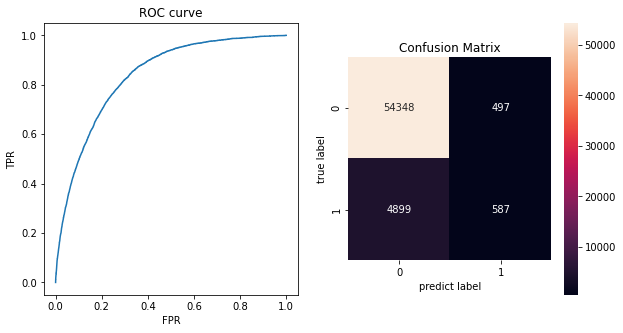

In [26]:
#로지스틱 이용 샘플링 안한경우
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7335200808871062
Precision 0.22033271719038816
Recall 0.7604812249362013
F1 0.3416731501576512
AUC 0.8188215192472128
[[40082 14763]
 [ 1314  4172]]


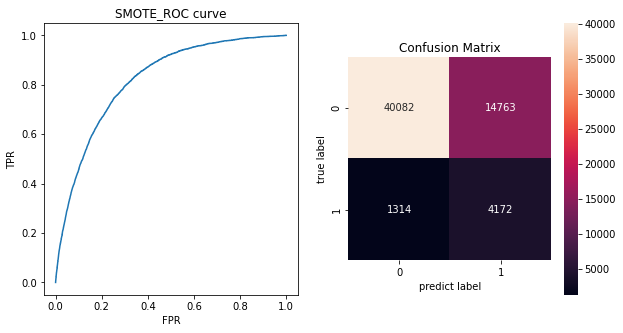

In [24]:
#SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
model.fit(x_train_SMOTE, y_train_SMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7593940097130828
Precision 0.23525272663304797
Recall 0.7313160772876413
F1 0.35598935226264417
AUC 0.8255980056744945
[[41803 13042]
 [ 1474  4012]]


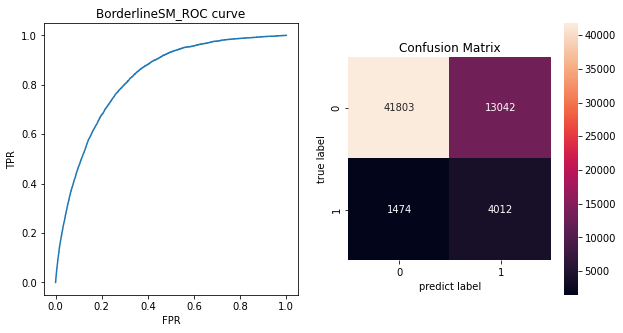

In [27]:
#BorderlineSMote
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_BorderlineSM = LogisticRegression()
model_BorderlineSM.fit(x_train_BorderlineSM, y_train_BorderlineSM)
y_pred = model_BorderlineSM.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model_BorderlineSM.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('BorderlineSM_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.8069317597918152
Precision 0.2687284191562828
Recall 0.6525701786365293
F1 0.3806890684814972
AUC 0.831433202183451
[[45103  9742]
 [ 1906  3580]]


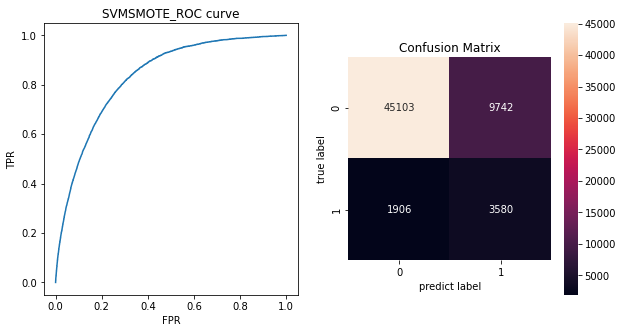

In [28]:
#SVMSMote
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_SVMSMOTE = LogisticRegression()
model_SVMSMOTE.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)
y_pred = model_SVMSMOTE.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model_SVMSMOTE.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SVMSMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7145580215809452
Precision 0.2106612752108092
Recall 0.7787094422165513
F1 0.33161265282359786
AUC 0.8160523258351088
[[38838 16007]
 [ 1214  4272]]


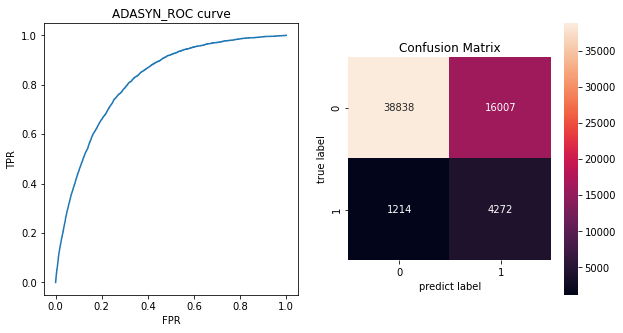

In [29]:
#ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_ADASYN = LogisticRegression()
model_ADASYN.fit(x_train_ADASYN, y_train_ADASYN)
y_pred = model_ADASYN.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model_ADASYN.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ADASYN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7095688783544115
Precision 0.21238768877843625
Recall 0.8100619759387532
F1 0.3365391897008709
AUC 0.8291028220683704
[[38365 16480]
 [ 1042  4444]]


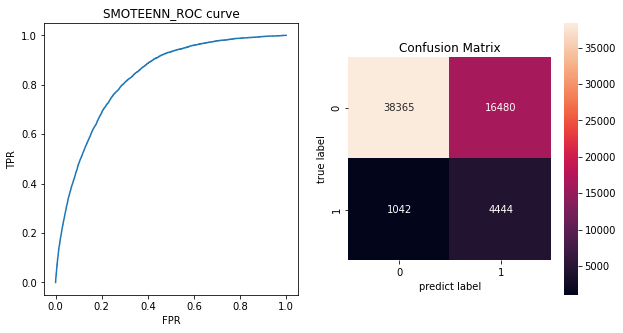

In [30]:
#SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_SMOTEENN = LogisticRegression()
model_SMOTEENN.fit(x_train_SMOTEENN, y_train_SMOTEENN)
y_pred = model_SMOTEENN.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model_SMOTEENN.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTEENN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7459515008867746
Precision 0.23189669263880563
Recall 0.7757929274516953
F1 0.3570619572968665
AUC 0.8367801204381805
[[40748 14097]
 [ 1230  4256]]


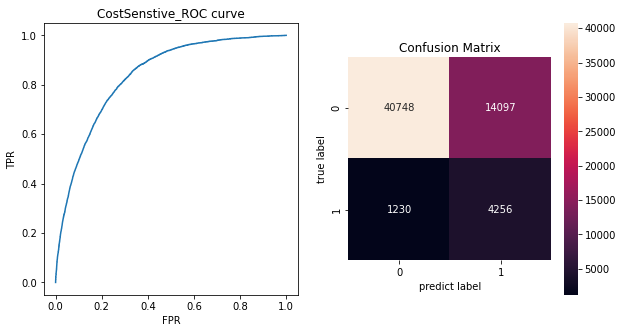

In [31]:
#Costsensitive
#원본 데이터를 가지고 class-weight 이용 로지스틱
model_cost = LogisticRegression(class_weight='balanced')
model_cost.fit(x_train, y_train)
y_pred = model_cost.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

y_pred_proba = model_cost.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('CostSenstive_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

# 하이퍼 파라미터 튜닝 후 결과

Accuracy 0.9104440503223882
Precision 0.5378995433789955
Recall 0.1073641997812614
F1 0.1790001519525908
AUC 0.8360036272972513
[[54339   506]
 [ 4897   589]]


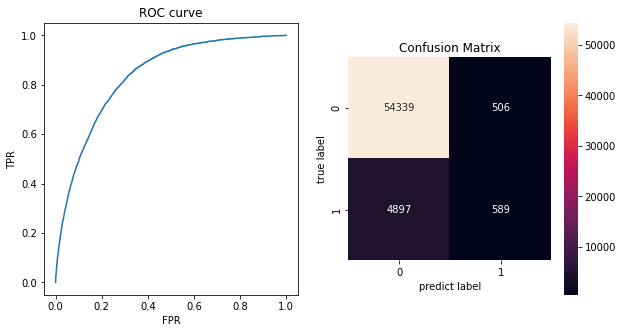

In [41]:
#원본-> 하이퍼파라미터 튜닝
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression(C=0.1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7338515854204306
Precision 0.22053613916353831
Recall 0.7602989427633977
F1 0.3418992581663183
AUC 0.8196611705270749
[[40103 14742]
 [ 1315  4171]]


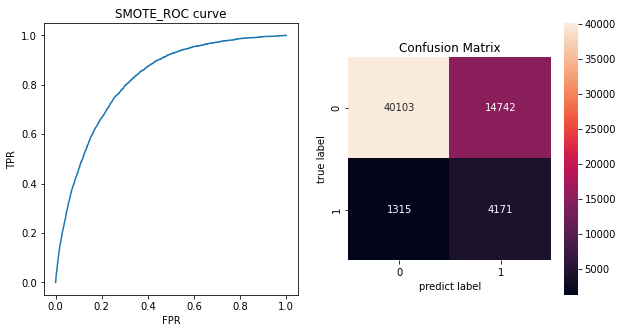

In [42]:
#SMOTE -> 하이퍼파라미터 튜닝
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_SMOTE = LogisticRegression(C=0.1)
model_SMOTE.fit(x_train_SMOTE, y_train_SMOTE)
y_pred = model_SMOTE.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model_SMOTE.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7596426381130762
Precision 0.23552191515578244
Recall 0.7316806416332483
F1 0.3563407164099605
AUC 0.825148643309799
[[41816 13029]
 [ 1472  4014]]


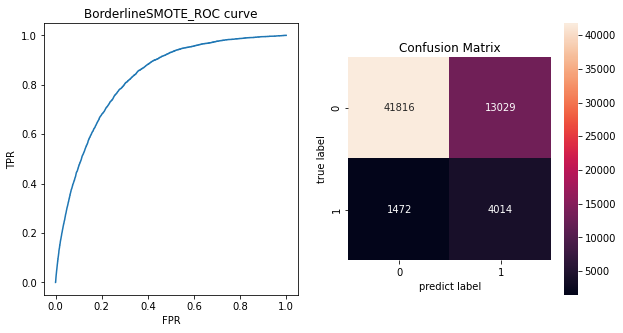

In [43]:
#BoderlineSMOTE -> 하이퍼파라미터 튜닝
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_BorderlineSM = LogisticRegression(C=0.1)
model_BorderlineSM.fit(x_train_BorderlineSM, y_train_BorderlineSM)
y_pred = model_BorderlineSM.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model_BorderlineSM.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('BorderlineSMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.8060698480051715
Precision 0.26827267303102625
Recall 0.6556689755741888
F1 0.380755795490632
AUC 0.8310917899504475
[[45034  9811]
 [ 1889  3597]]


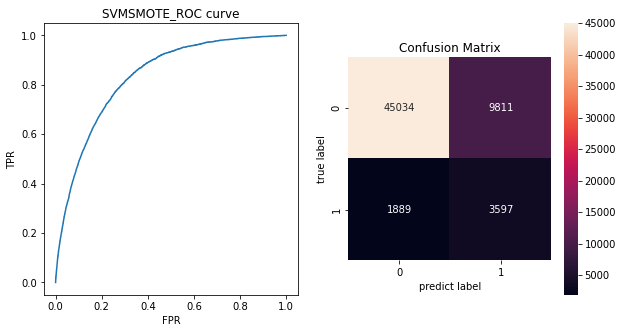

In [44]:
#SVMSMOTE -> 하이퍼파라미터 튜닝
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_SVMSMOTE = LogisticRegression(C=0.1)
model_SVMSMOTE.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)
y_pred = model_SVMSMOTE.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model_SVMSMOTE.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SVMSMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7146408977142762
Precision 0.2105990328629231
Recall 0.7779803135253373
F1 0.3314694004349177
AUC 0.8150717943156478
[[38847 15998]
 [ 1218  4268]]


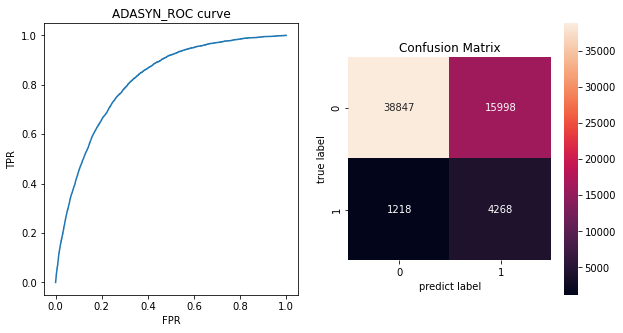

In [45]:
#ADASYN -> 하이퍼파라미터 튜닝
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_ADASYN = LogisticRegression(C=0.1)
model_ADASYN.fit(x_train_ADASYN, y_train_ADASYN)
y_pred = model_ADASYN.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model_ADASYN.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ADASYN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7097843563010724
Precision 0.21260218960654015
Recall 0.8106088224571637
F1 0.33685566034162784
AUC 0.8294981395718761
[[38375 16470]
 [ 1039  4447]]


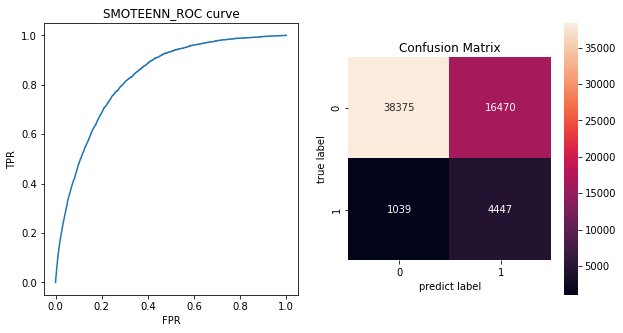

In [46]:
#SMOTEENN->하이퍼파라미터 튜닝
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_SMOTEENN = LogisticRegression(C=0.1)
model_SMOTEENN.fit(x_train_SMOTEENN, y_train_SMOTEENN)
y_pred = model_SMOTEENN.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model_SMOTEENN.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTEENN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7458354743001111
Precision 0.2318082788671024
Recall 0.7757929274516953
F1 0.35695714165897846
AUC 0.8367915103735656
[[40741 14104]
 [ 1230  4256]]


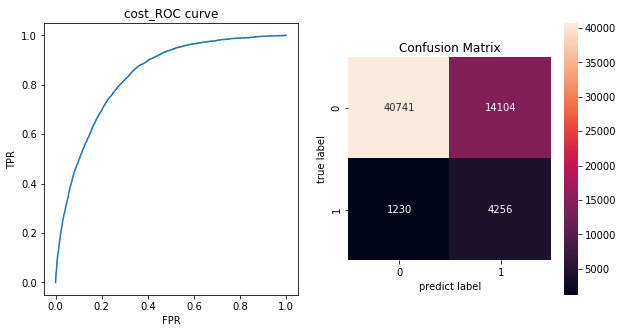

In [47]:
#CostSensitive -> 하이퍼파라미터 튜닝
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_cost = LogisticRegression(C=0.1,class_weight='balanced')
model_cost.fit(x_train, y_train)
y_pred = model_cost.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model_cost.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('cost_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

# 추후 샘플링 시간 절약을 위한 각 데이터 세트 내보내기

In [48]:
x_train.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/x_train.csv')
y_train.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/y_train.csv')
x_test.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/x_test.csv')
y_test.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/y_test.csv')
x_train_SMOTE.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/x_train_SMOTE.csv')
y_train_SMOTE.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/y_train_SMOTE.csv')
x_train_BorderlineSM.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/x_train_BorderlineSM.csv')
y_train_BorderlineSM.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/y_train_BorderlineSM.csv')
x_train_SVMSMOTE.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/x_train_SVMSMOTE.csv')
y_train_SVMSMOTE.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/y_train_SVMSMOTE.csv')
x_train_ADASYN.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/x_train_ADASYN.csv')
y_train_ADASYN.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/y_train_ADASYN.csv')
x_train_SMOTEENN.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/x_train_SMOTEENN.csv')
y_train_SMOTEENN.to_csv('/content/drive/MyDrive/기계학습 팀플/OneHot/y_train_SMOTEENN.csv')

# XAI 이용

In [49]:
!pip install pdpbox
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 226 kB/s 
     |████████████████████████████████| 13.1 MB 26.7 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=7fdf74f57f90e2669585b391cc0391162cf8ebf03235adc3bd9bf19f640d1d1a
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 4.9 MB/s 


In [73]:
from pdpbox import pdp
import shap
print(x_test.columns)
#분포를 보기위해 yes no와 그 외로 피쳐 분리
feature = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',  'PhysicalActivity',   'Asthma', 'KidneyDisease',
       'SkinCancer', 'Diabetic']
feature2=['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory',  'GenHealth', 'SleepTime']
feature3=x_test.columns[16:]
features = x_test.columns


Index([                              'BMI',
                                 'Smoking',
                         'AlcoholDrinking',
                                  'Stroke',
                          'PhysicalHealth',
                            'MentalHealth',
                             'DiffWalking',
                                     'Sex',
                             'AgeCategory',
                                'Diabetic',
                        'PhysicalActivity',
                               'GenHealth',
                               'SleepTime',
                                  'Asthma',
                           'KidneyDisease',
                              'SkinCancer',
       ('American Indian/Alaskan Native',),
                                ('Asian',),
                                ('Black',),
                             ('Hispanic',),
                                ('Other',),
                                ('White',)],
      dtype='object')
('Asian',

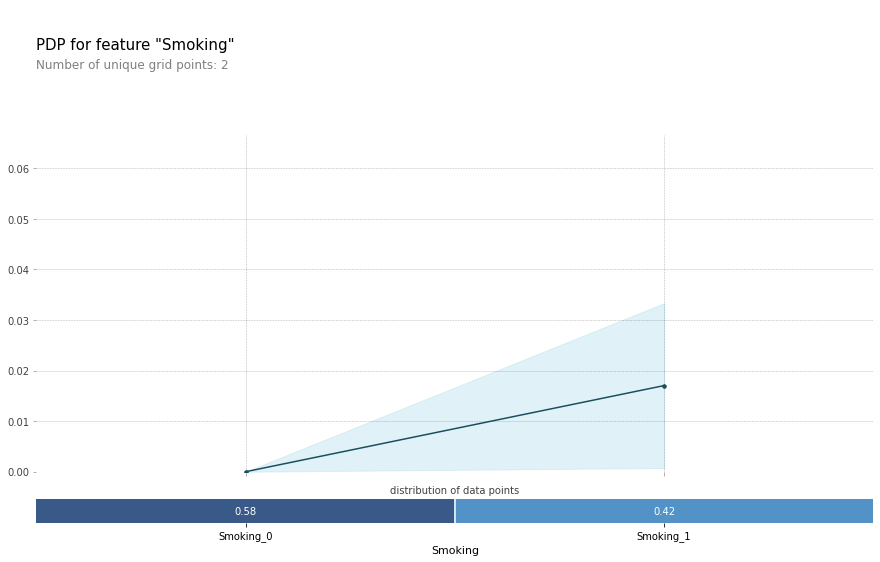

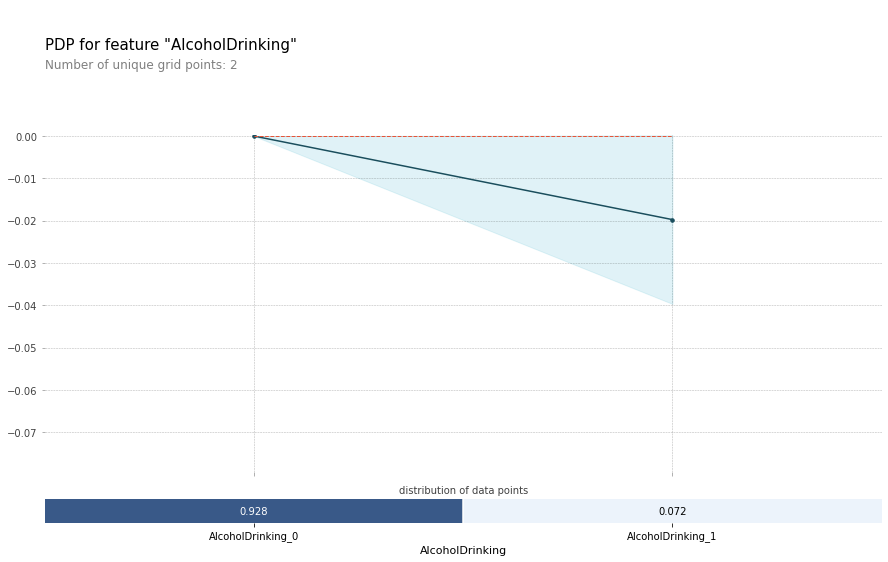

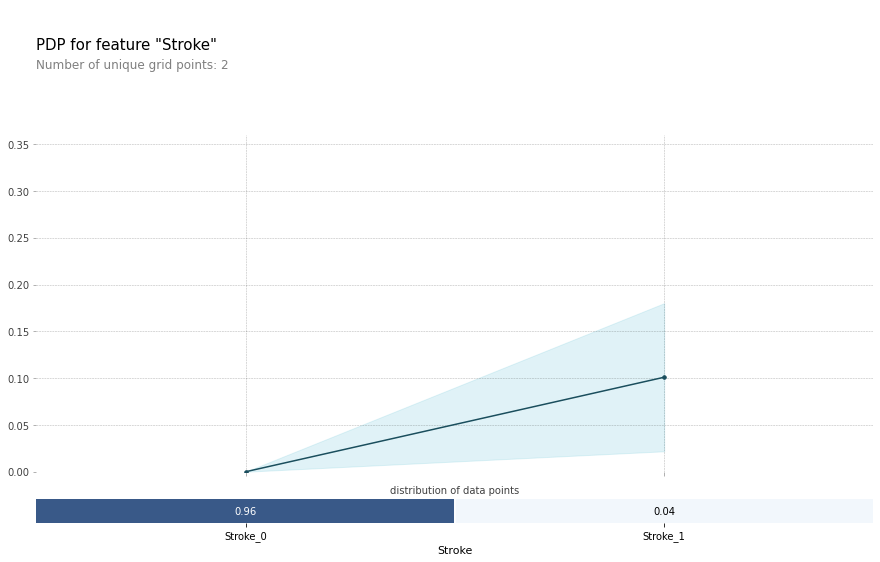

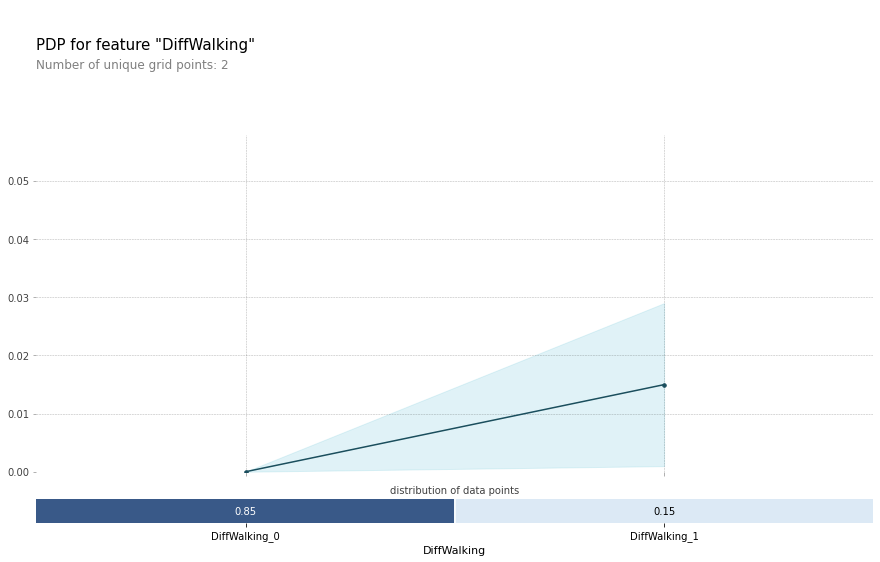

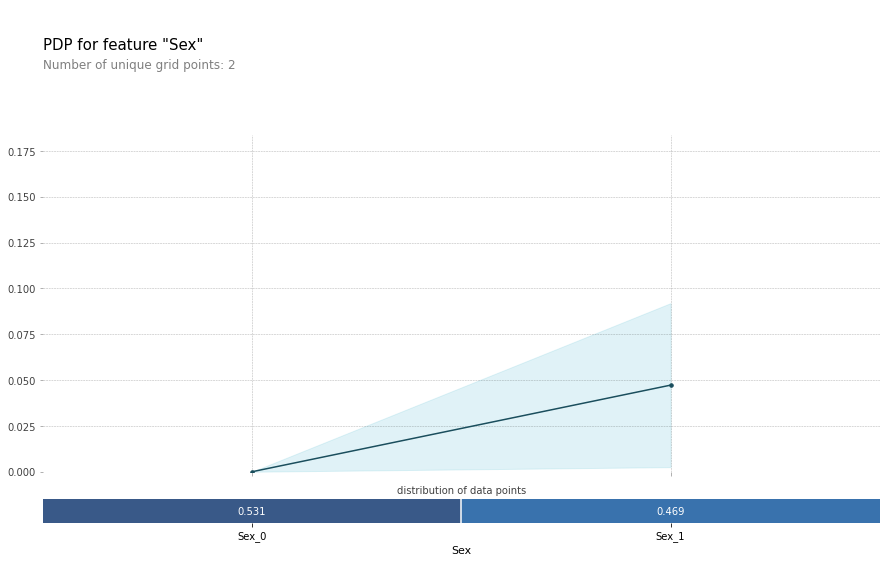

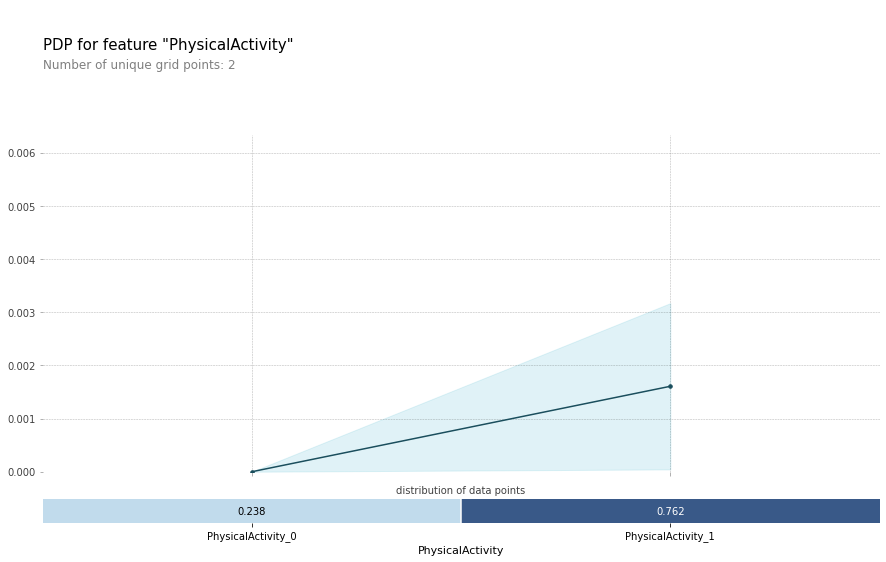

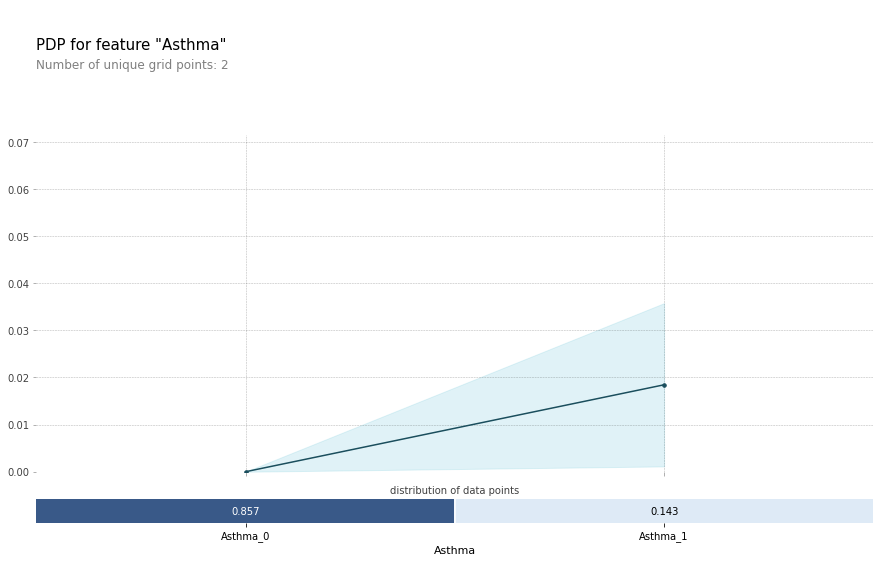

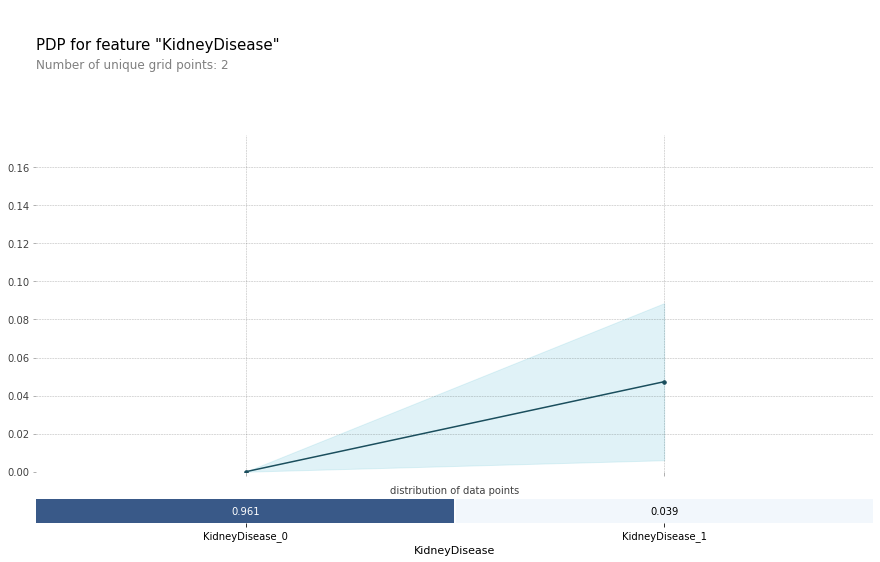

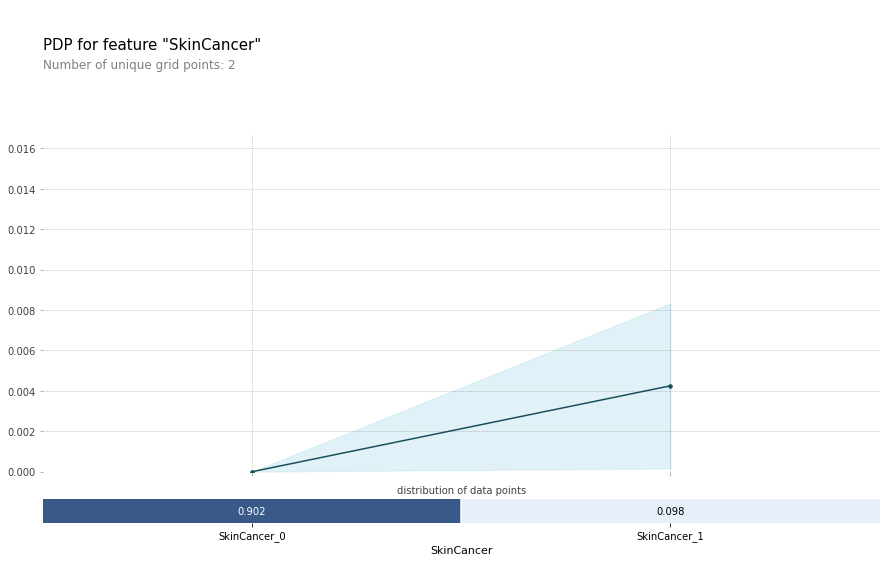

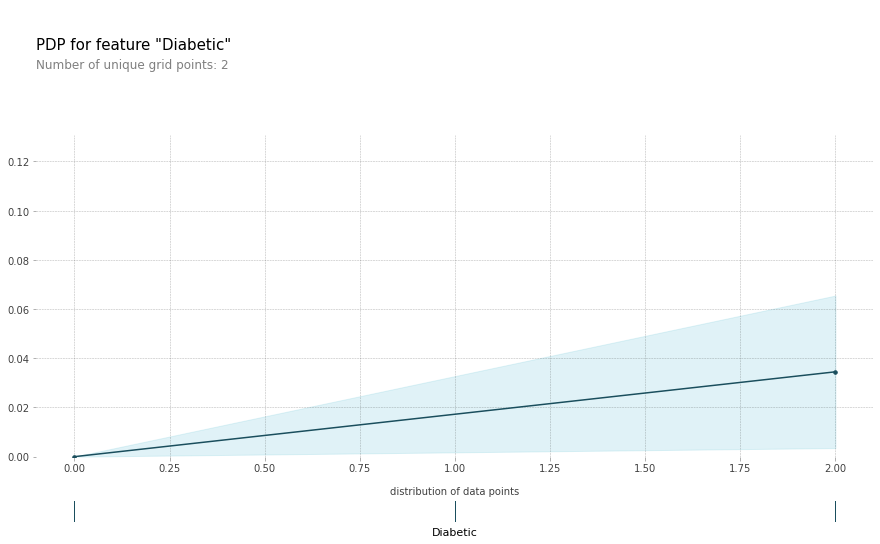

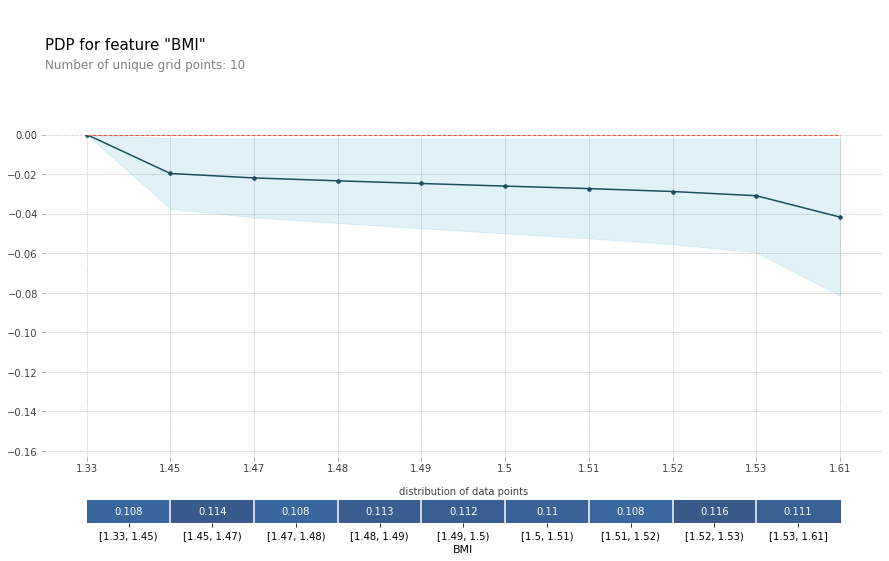

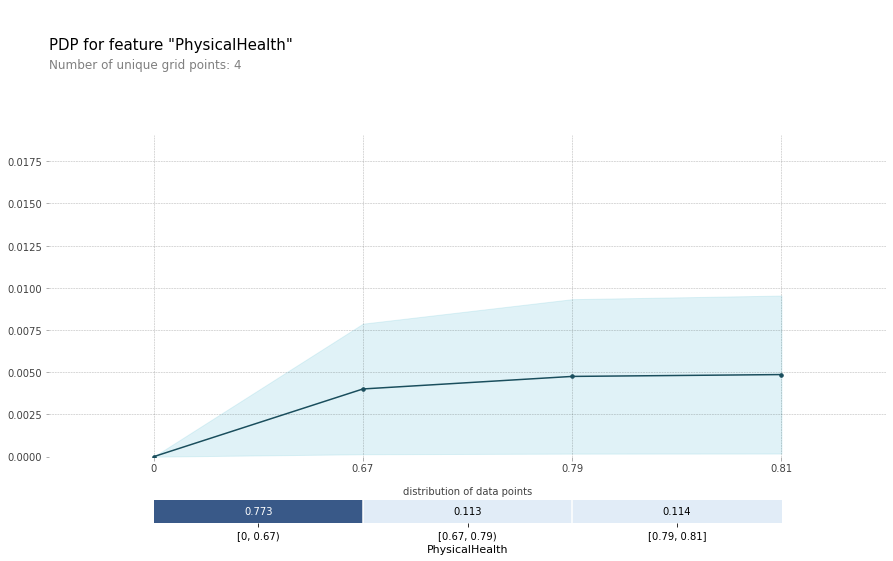

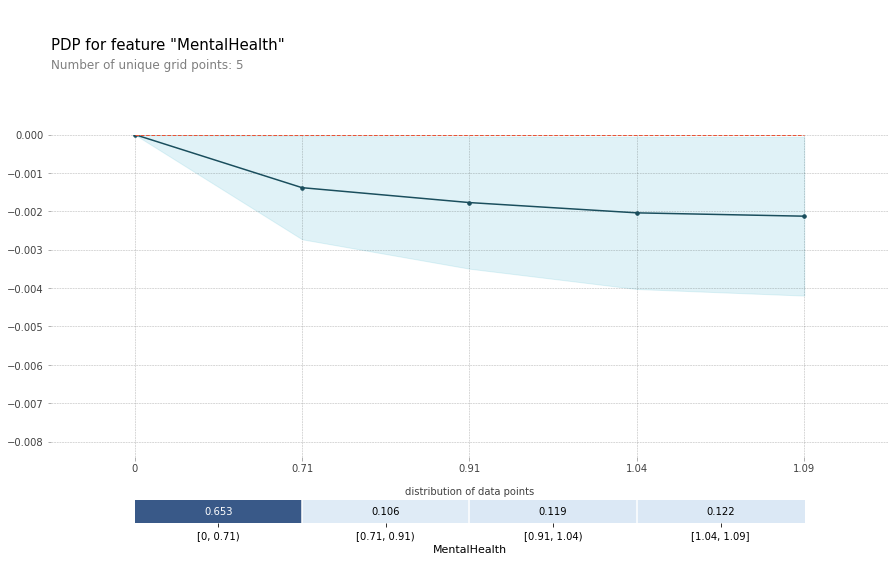

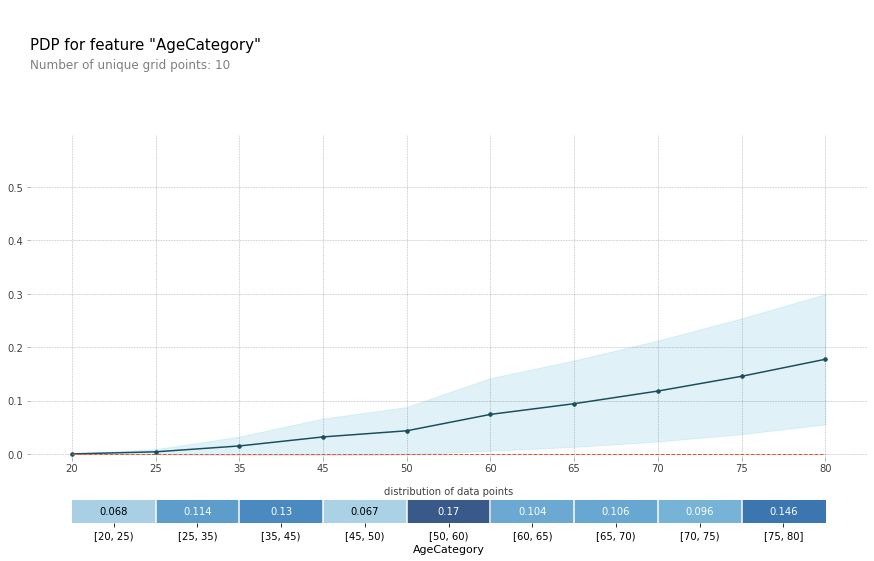

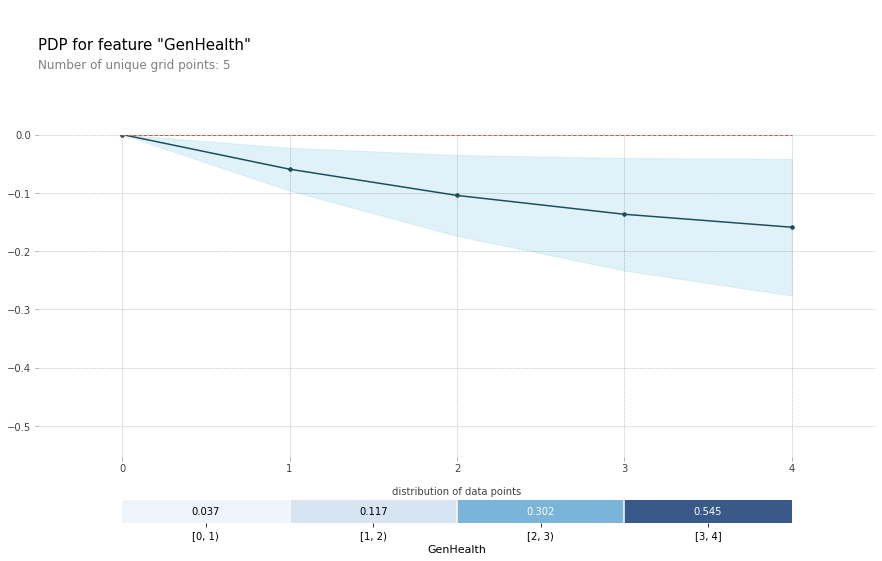

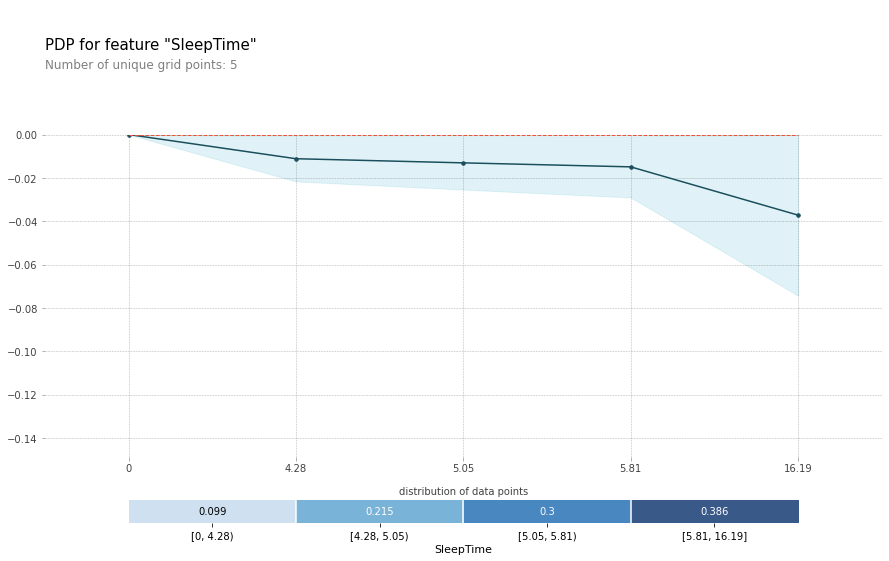

In [101]:
# 샘플링 없는 pdp
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)

for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [102]:
# 샘플링 적용안한 경우의 center ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
  
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

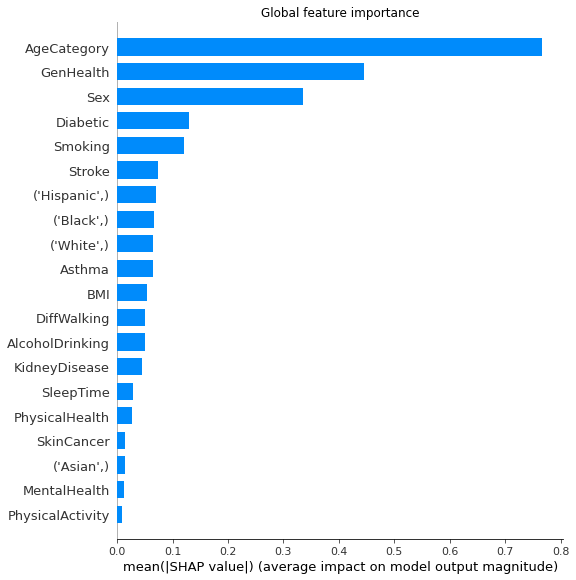

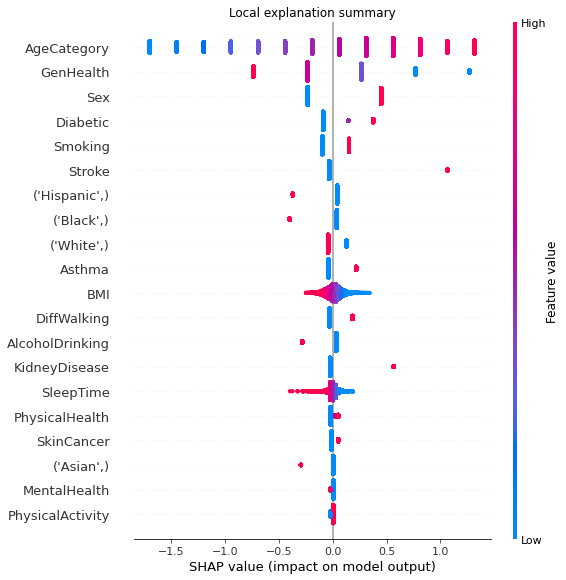

In [103]:
# SHAP
explainer = shap.Explainer(model, x_train, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

# SMOTE 샘플링 PDP, ICE, SHAP

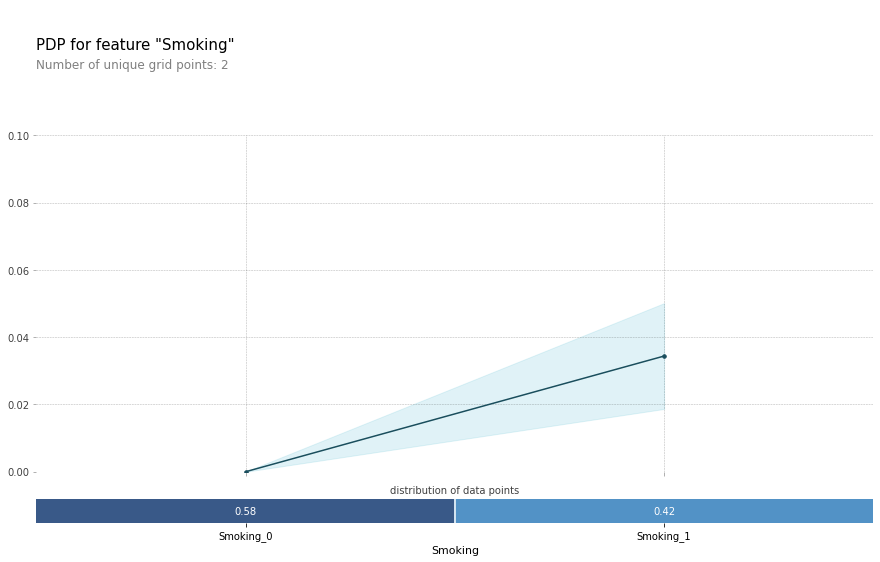

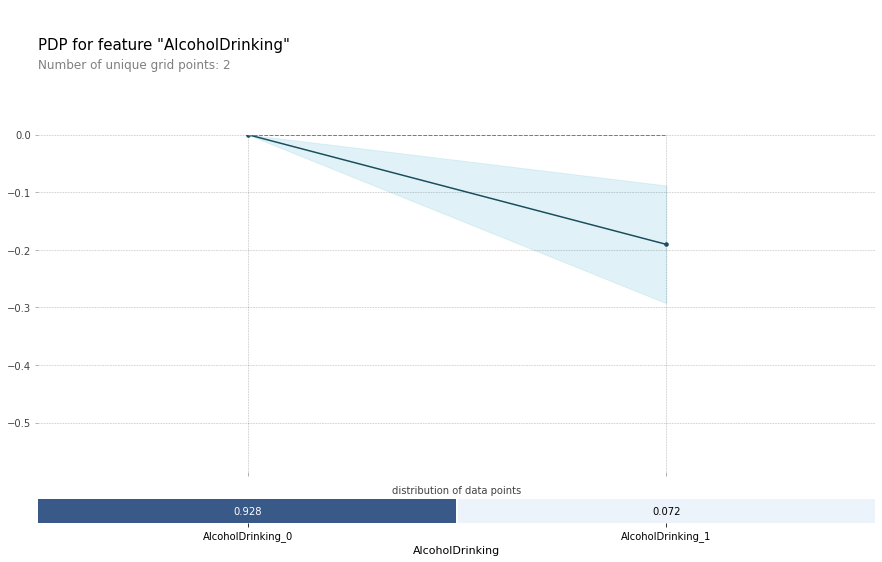

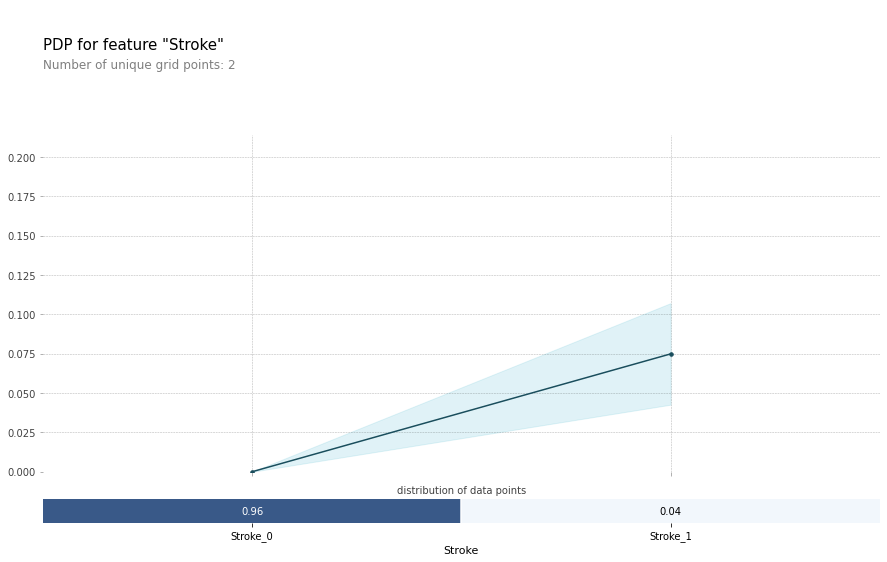

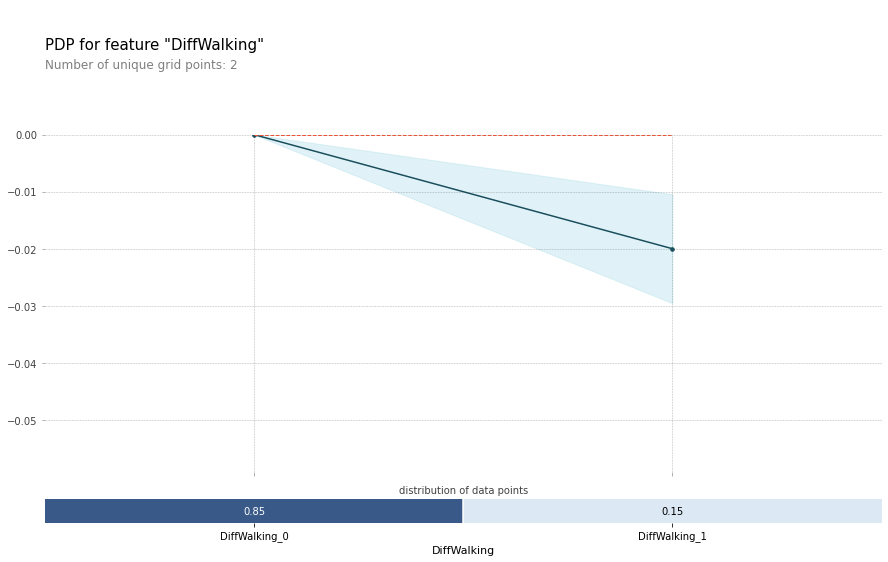

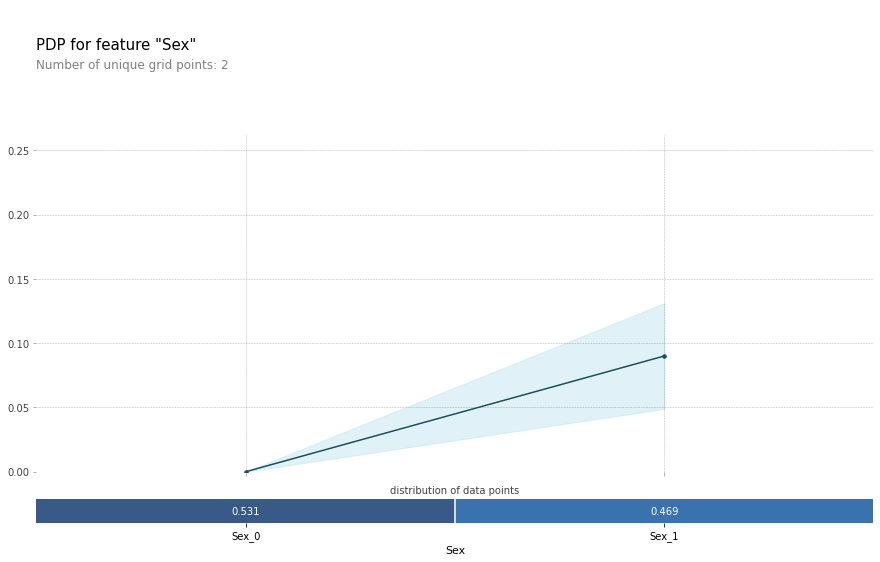

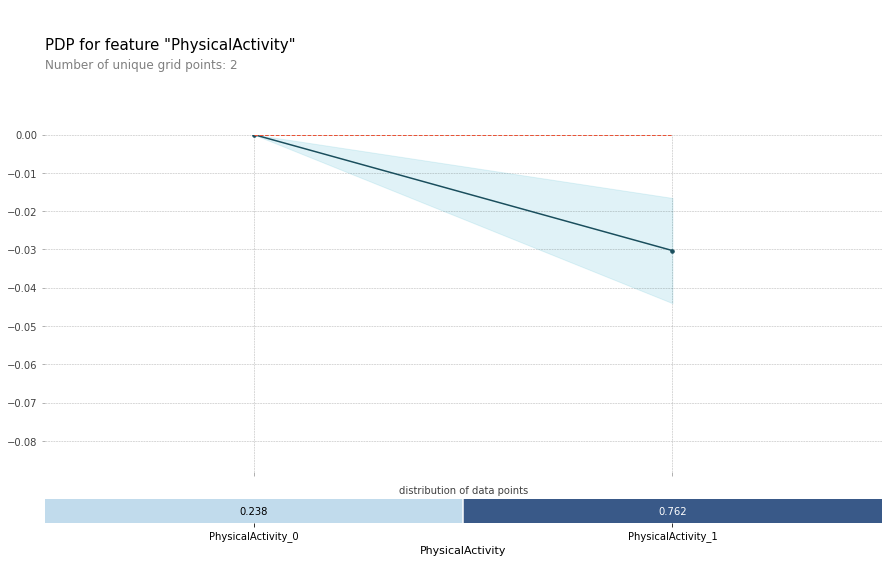

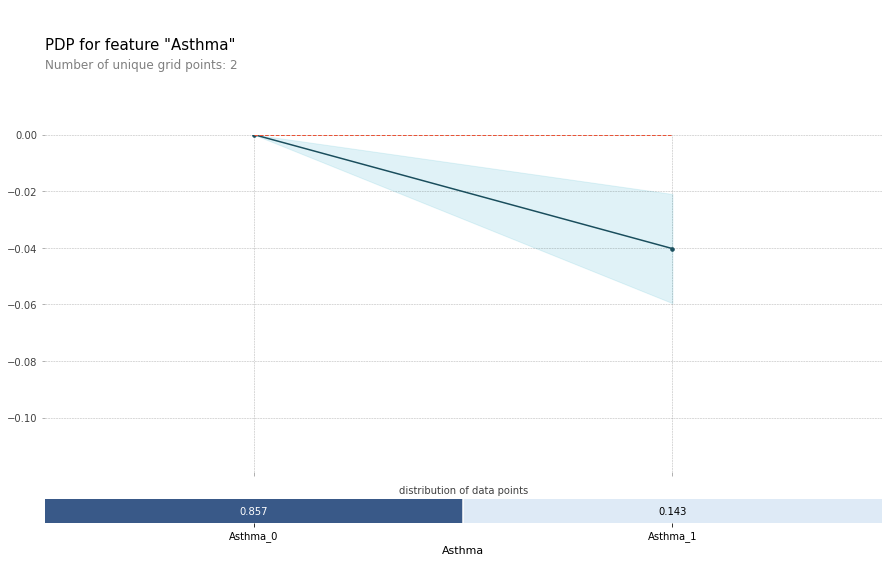

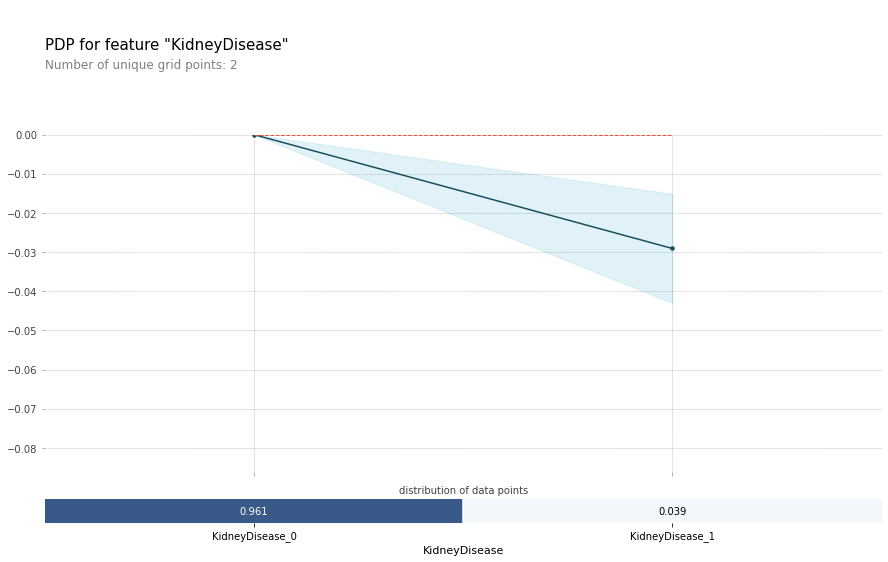

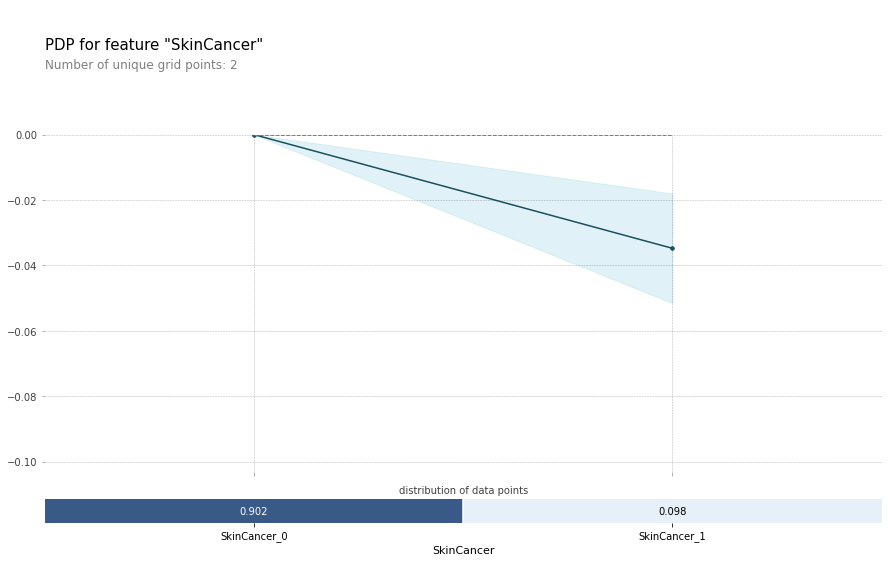

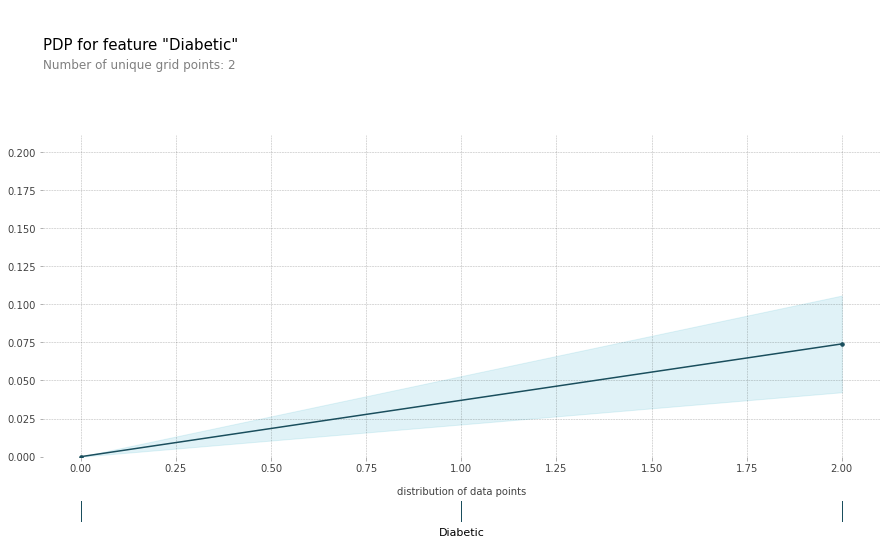

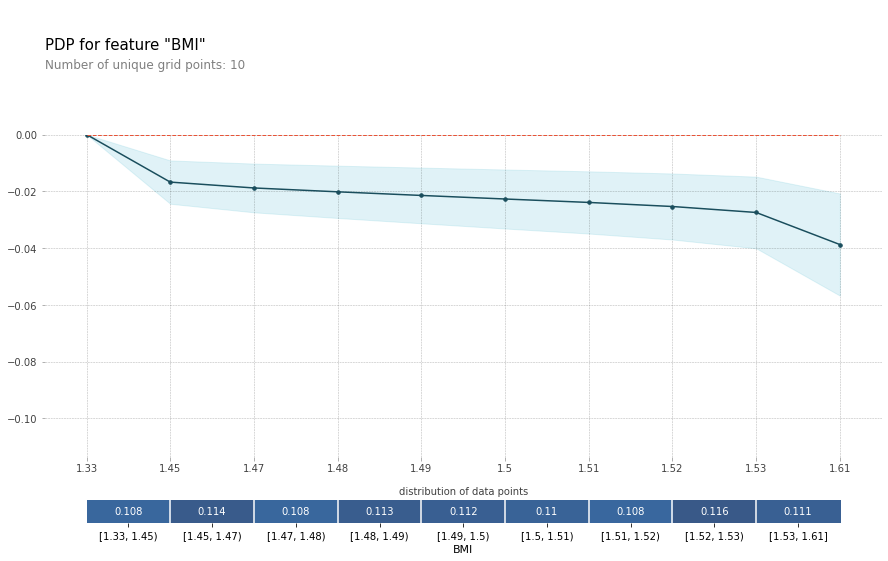

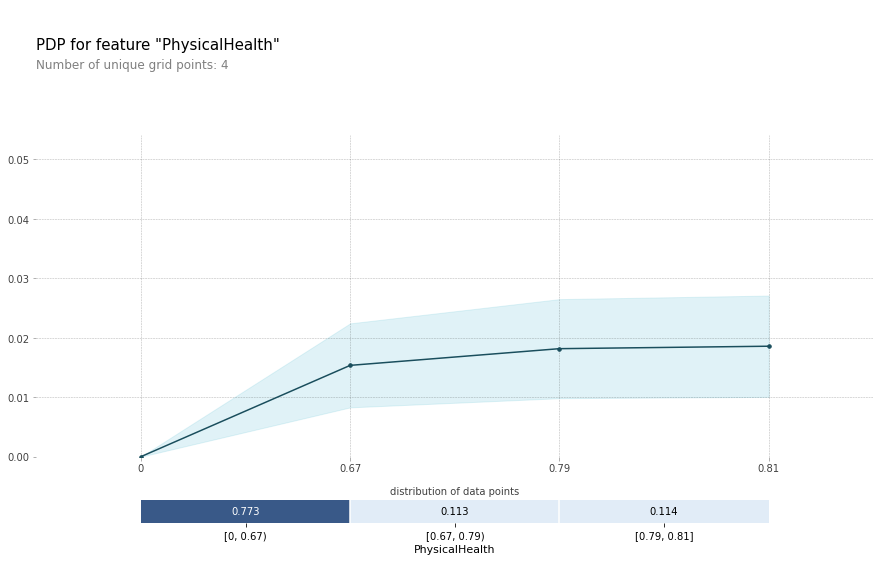

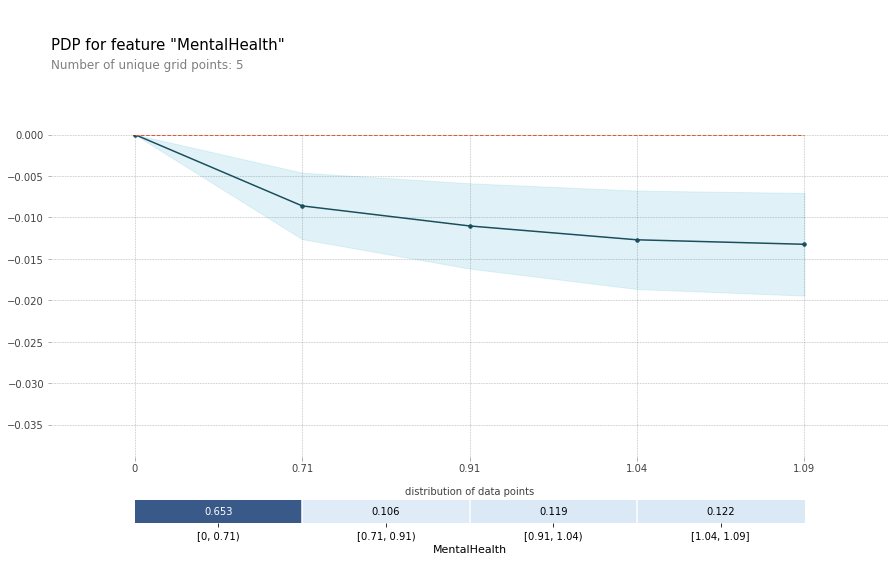

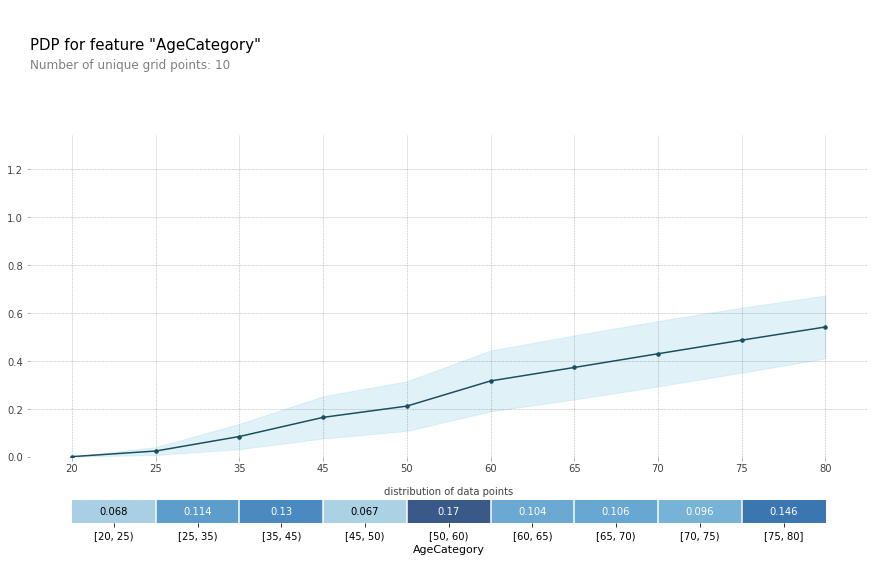

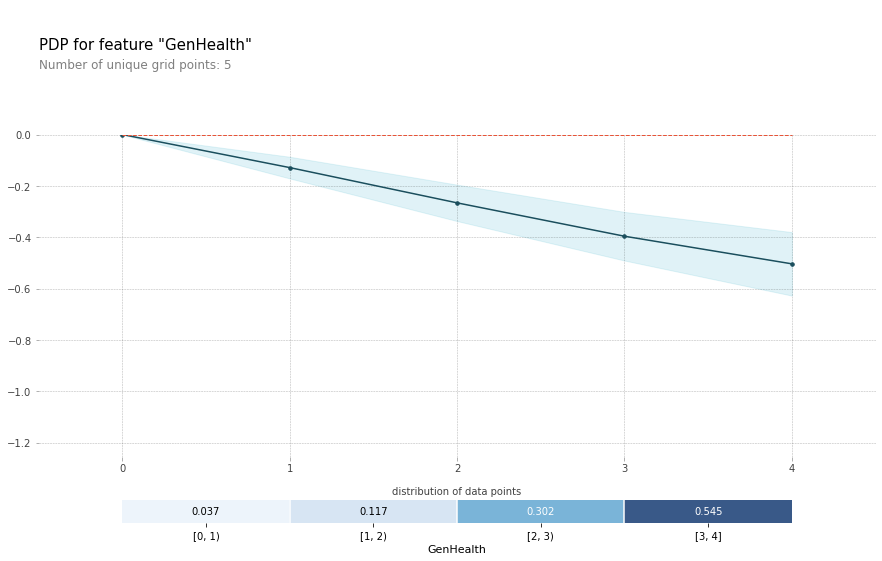

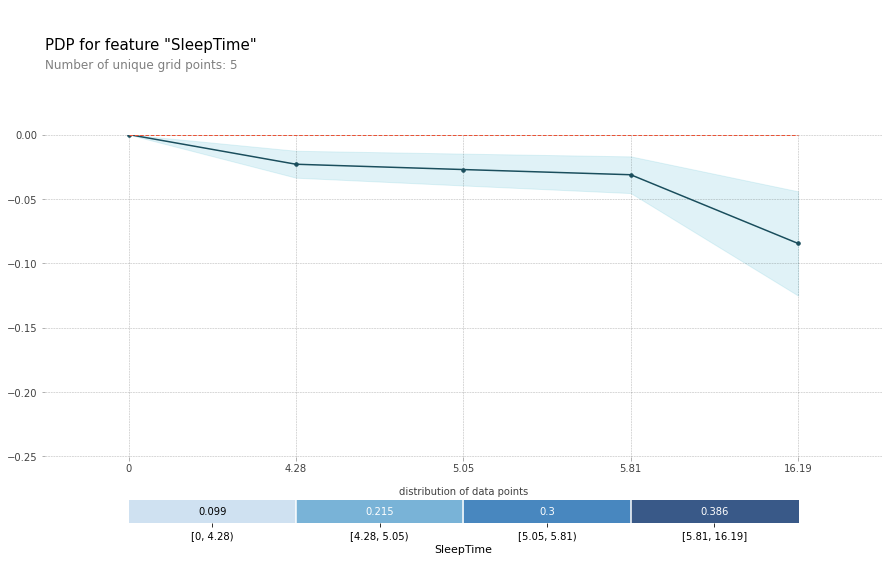

In [105]:
# SMOTE 데이터 PDP
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)

for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [106]:
# SMOTE 데이터 ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

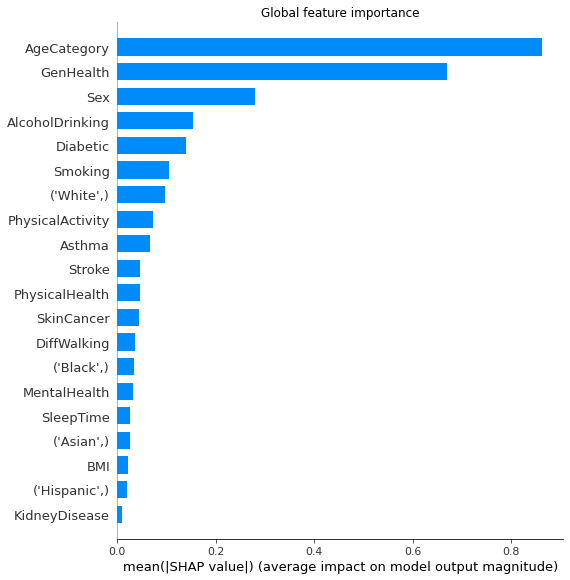

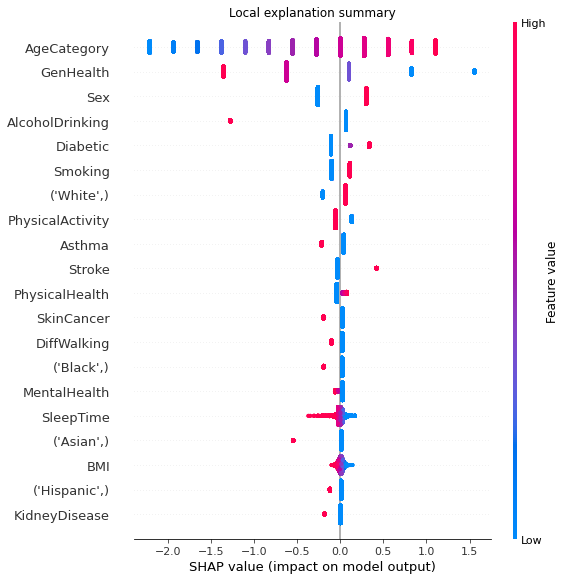

In [107]:
# SMOTE 데이터 SHAP
explainer = shap.Explainer(model_SMOTE, x_train_SMOTE, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

# BorderlineSMOTE 샘플링 PDP, ICE, SHAP

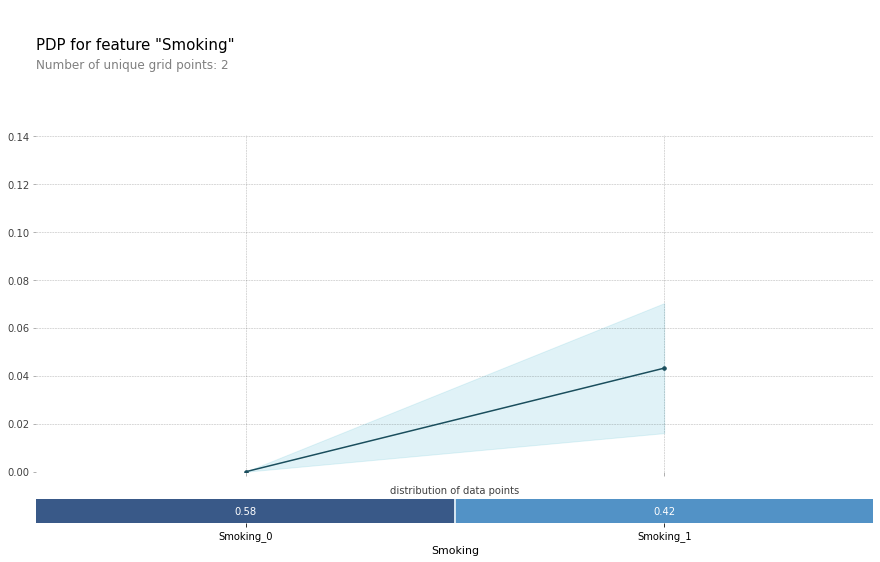

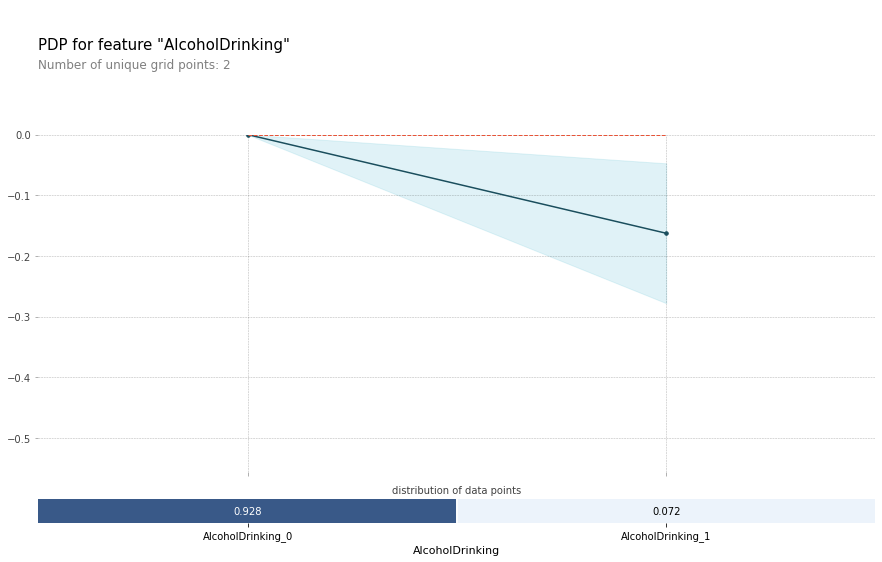

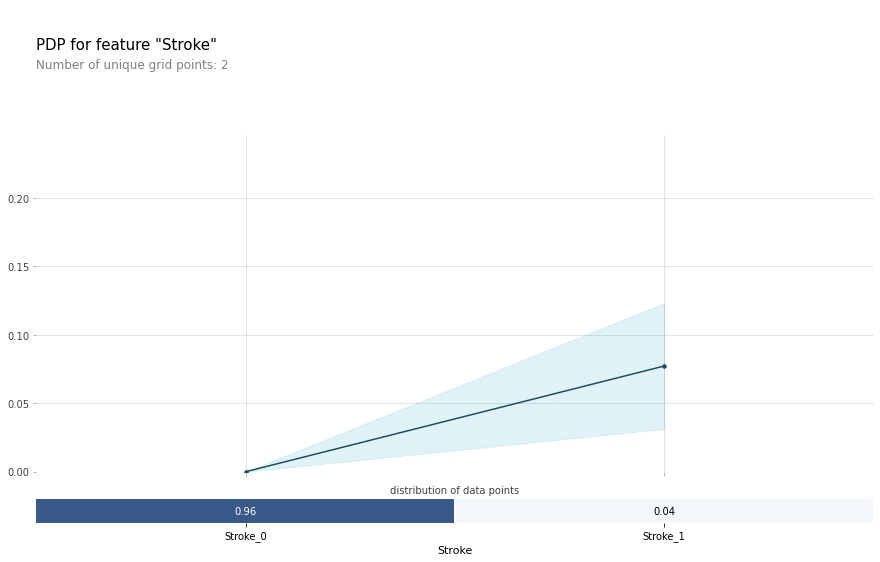

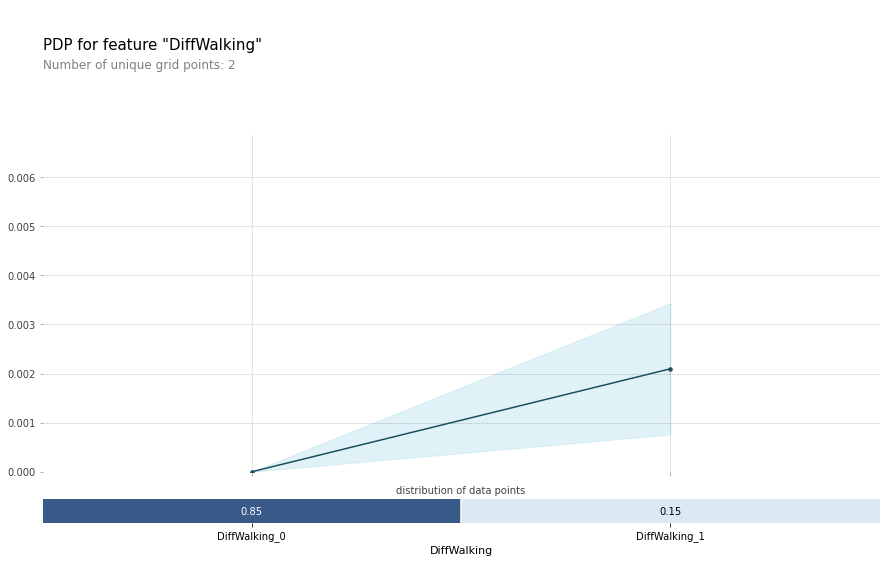

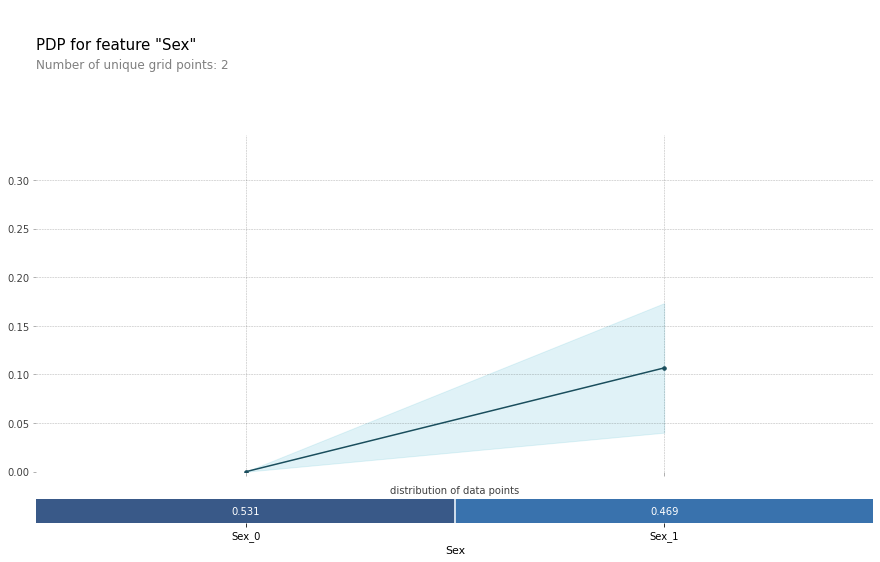

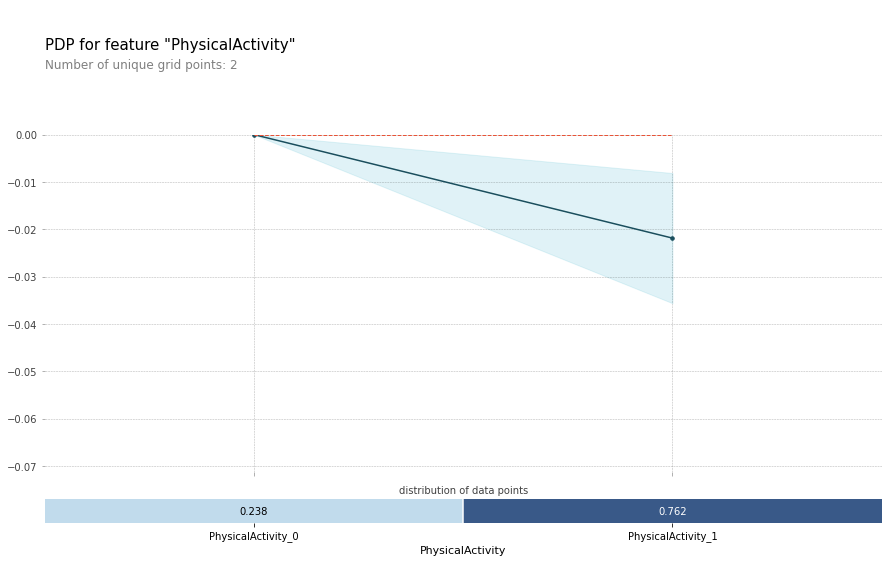

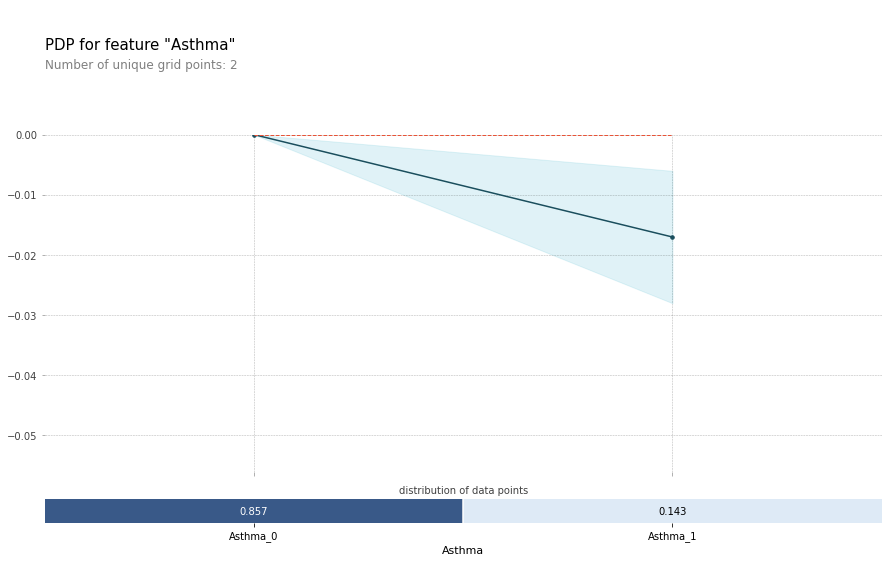

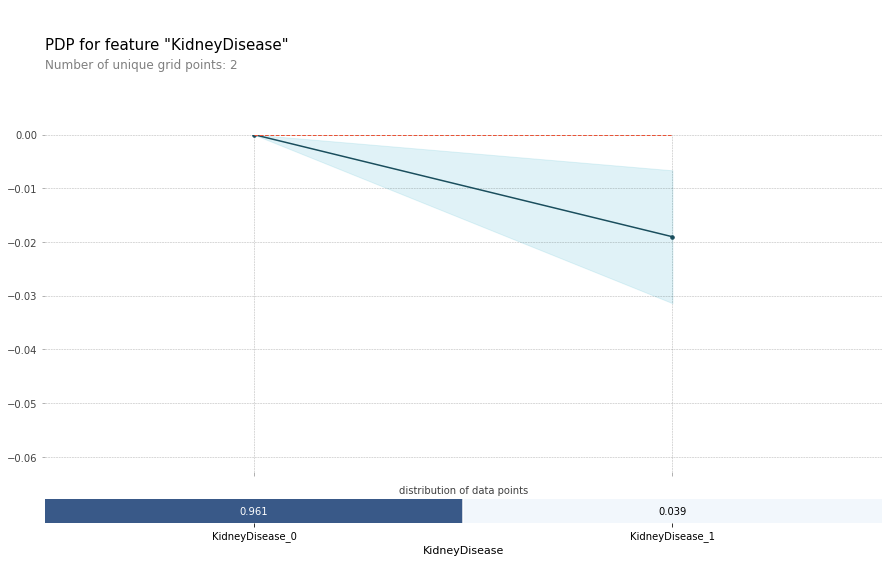

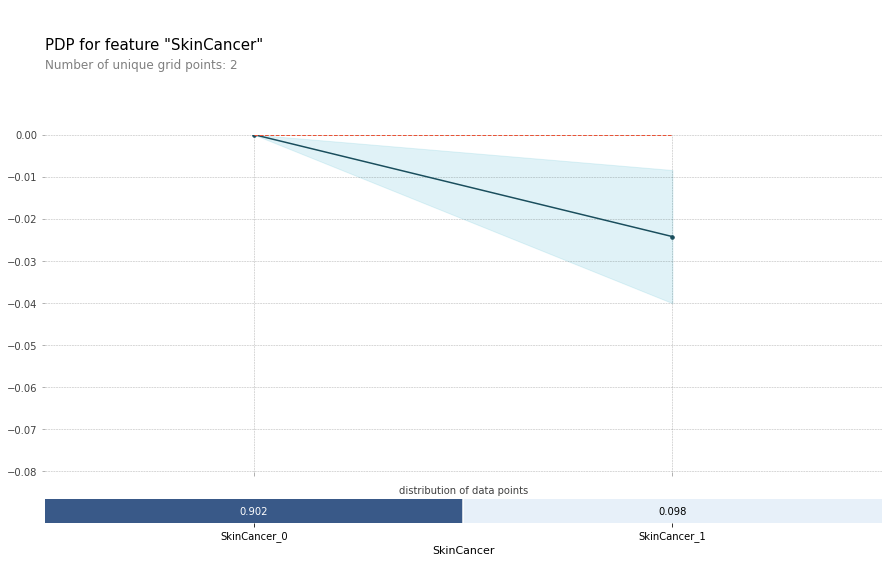

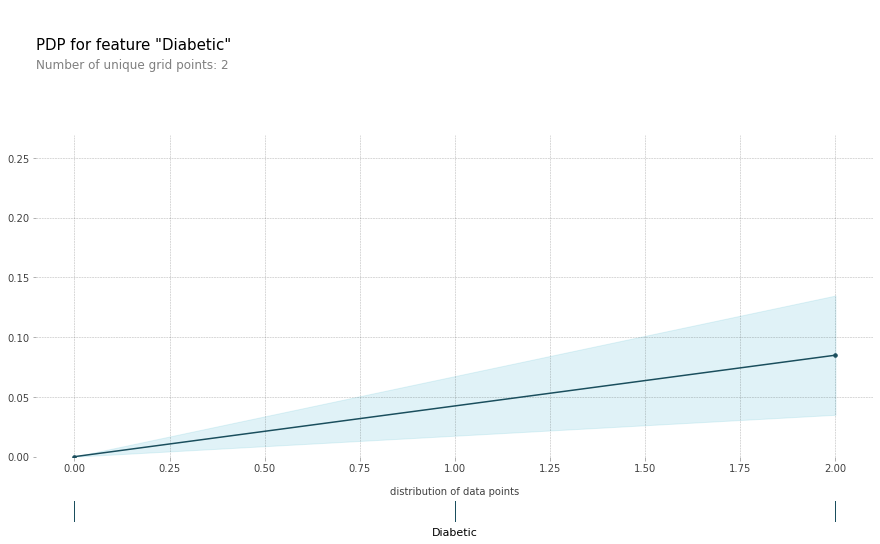

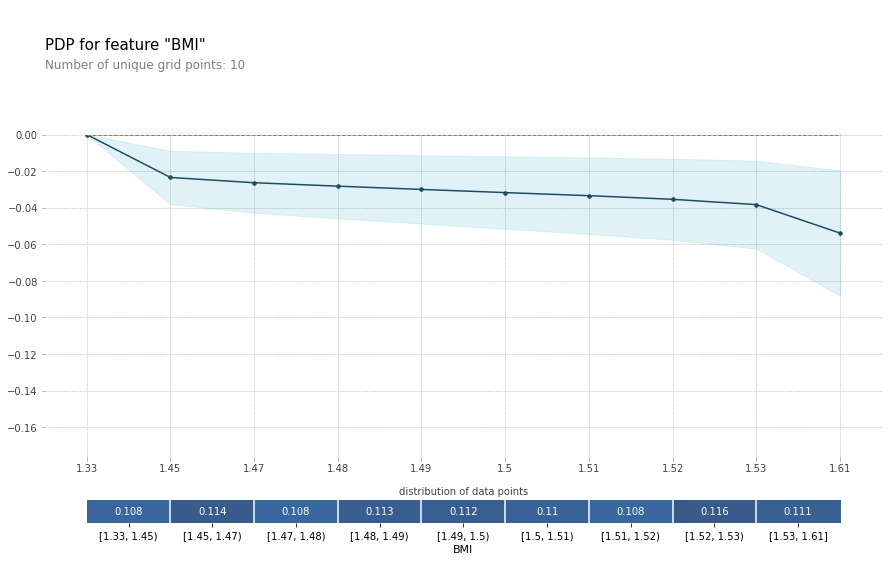

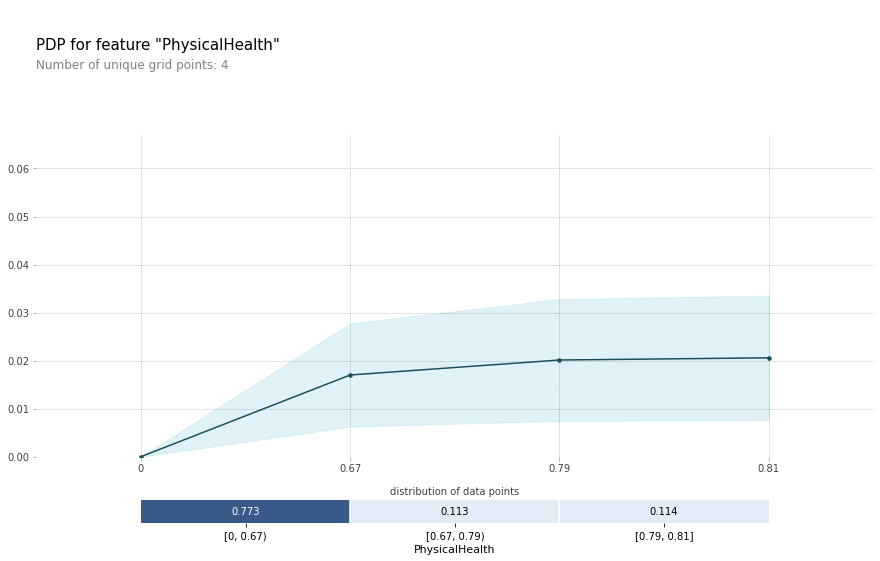

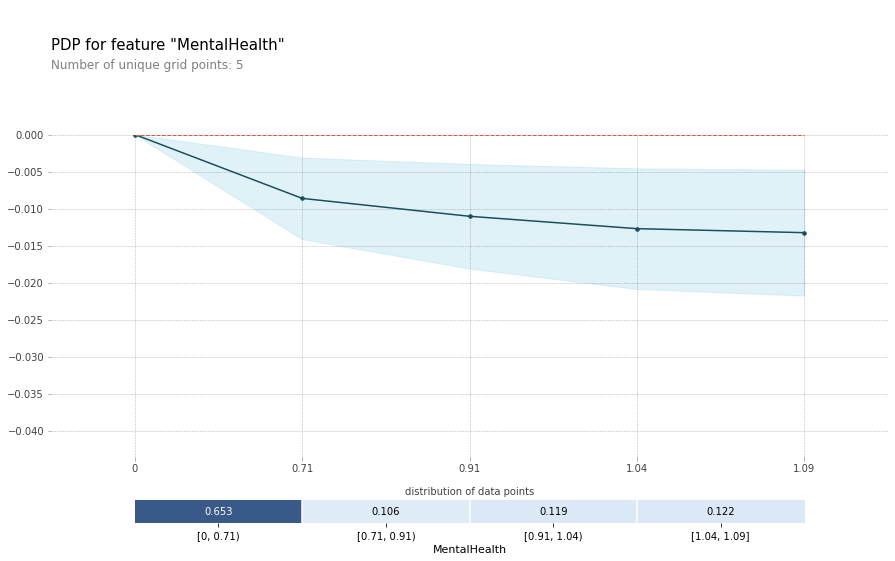

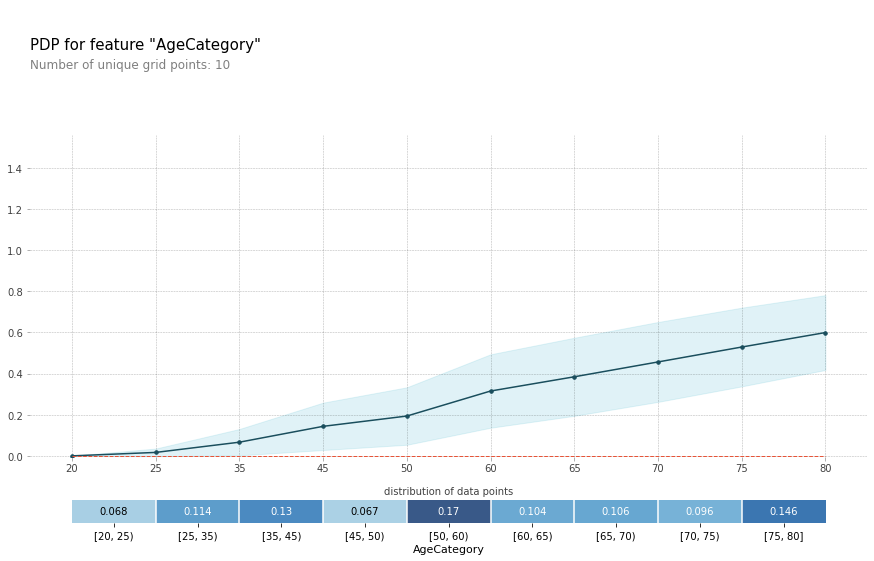

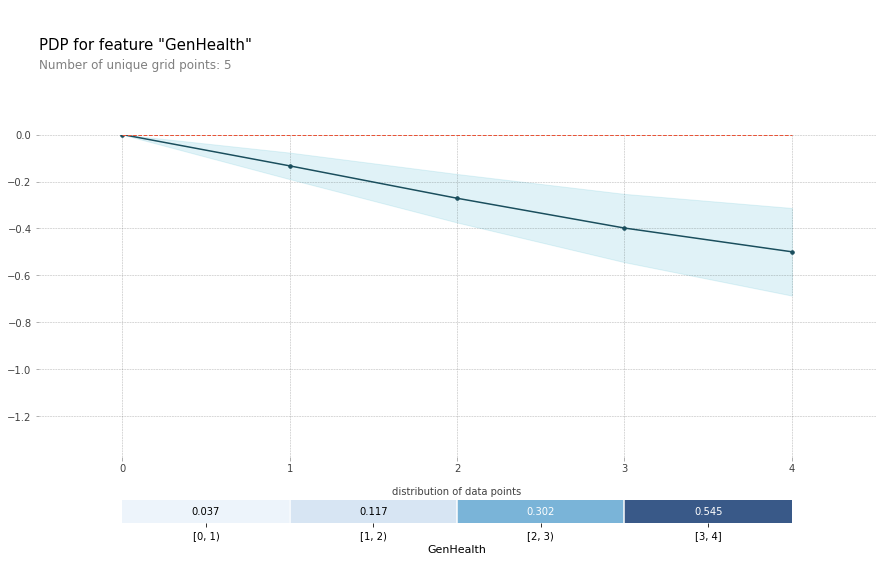

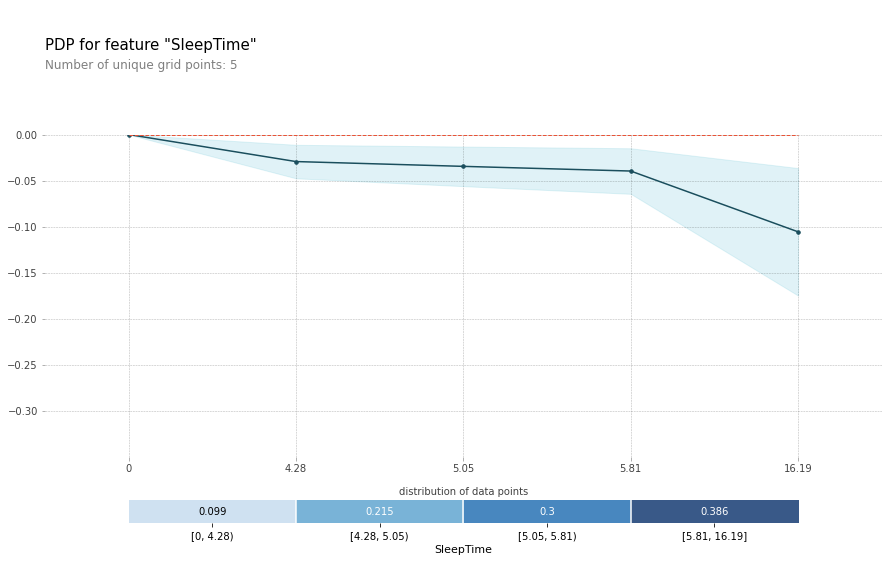

In [108]:
#PDP
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
  
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [109]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
  
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

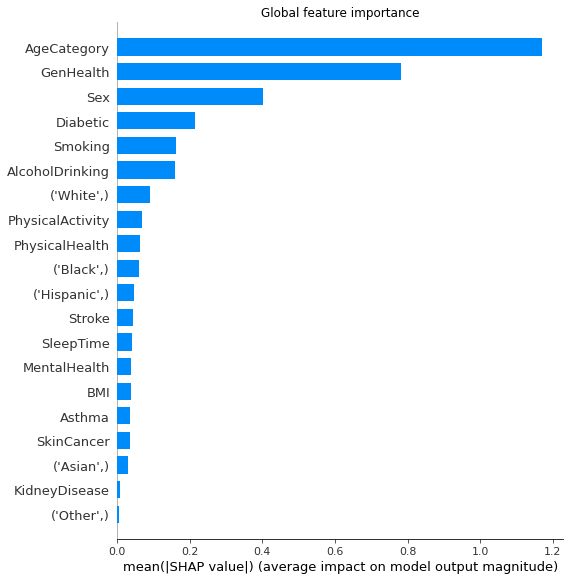

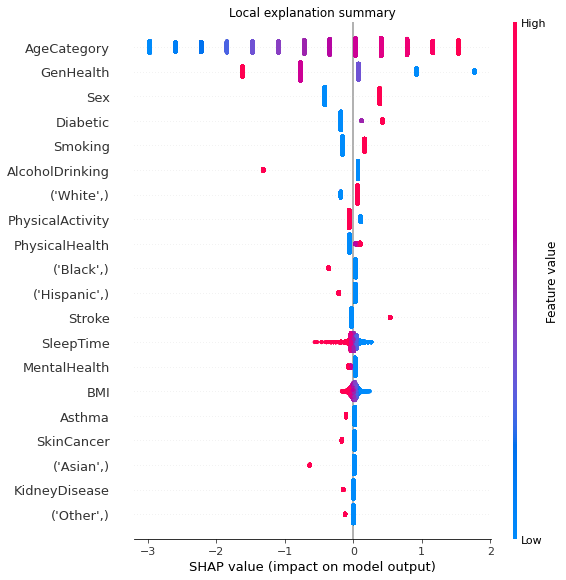

In [110]:
# SHAP
explainer = shap.Explainer(model_BorderlineSM, x_train_BorderlineSM, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")

plt.title('Local explanation summary')
shap.summary_plot(shap_values)

# SVMSMOTE 샘플링 PDP, ICE, SHAP

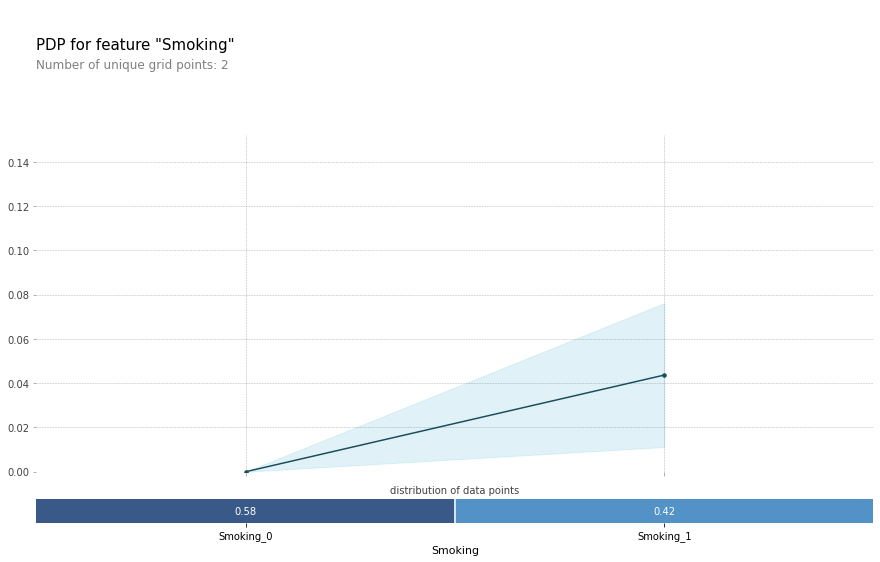

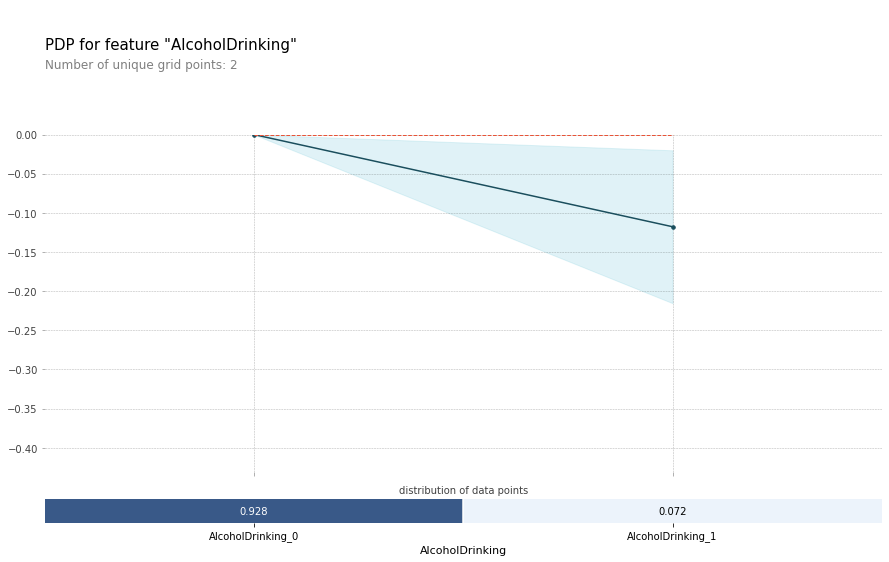

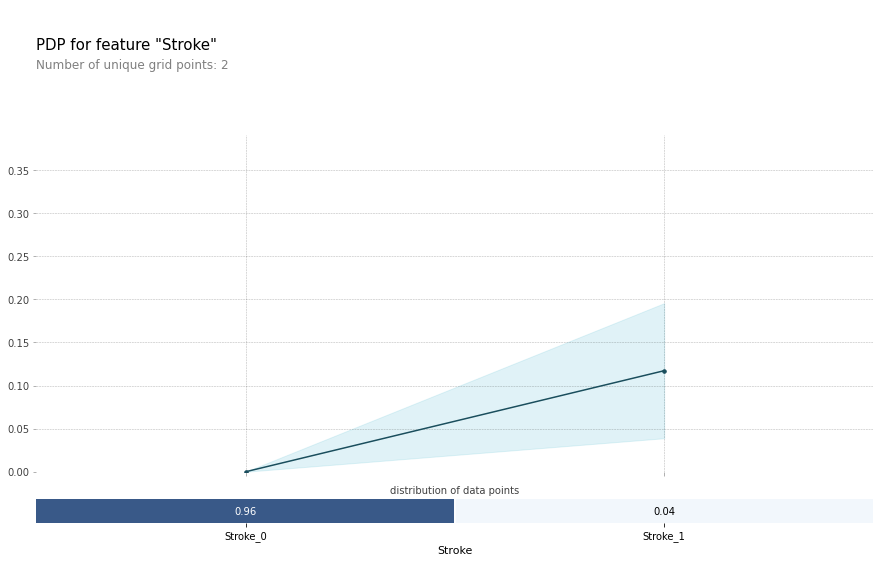

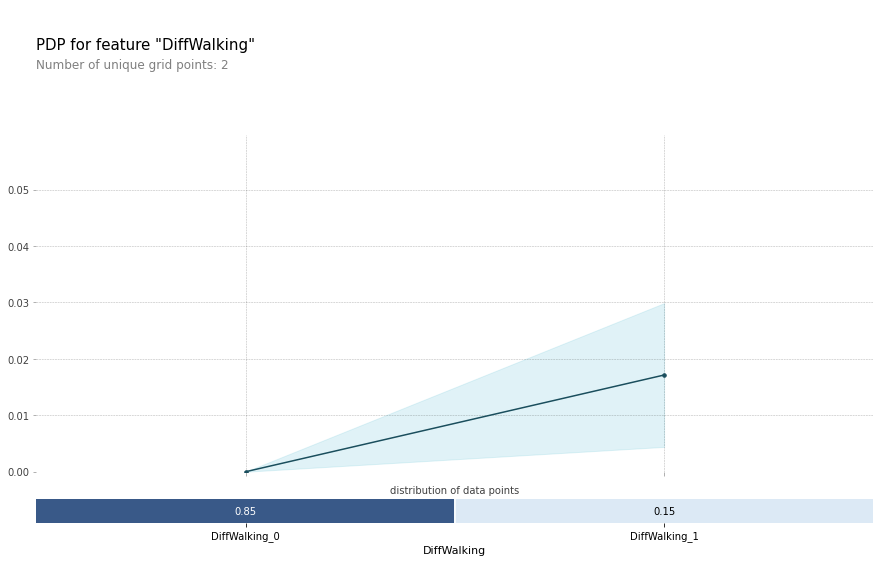

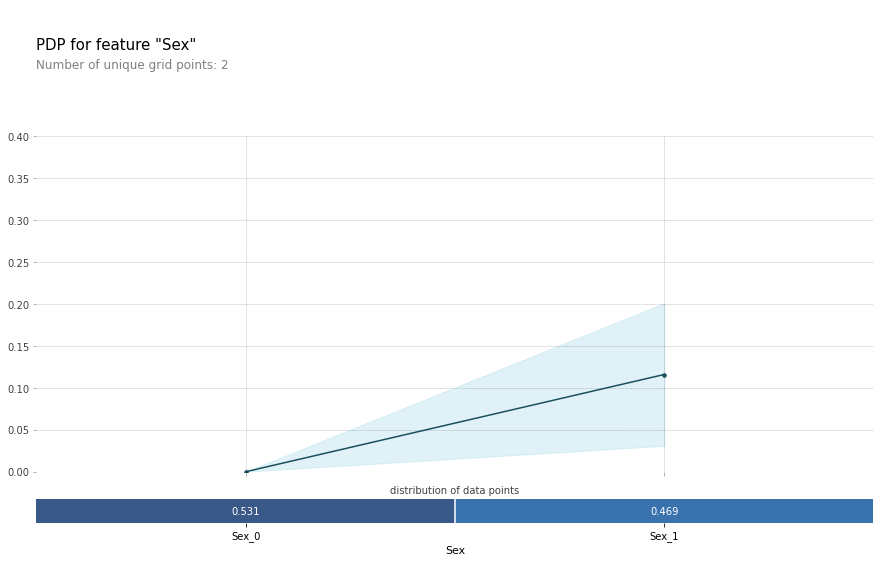

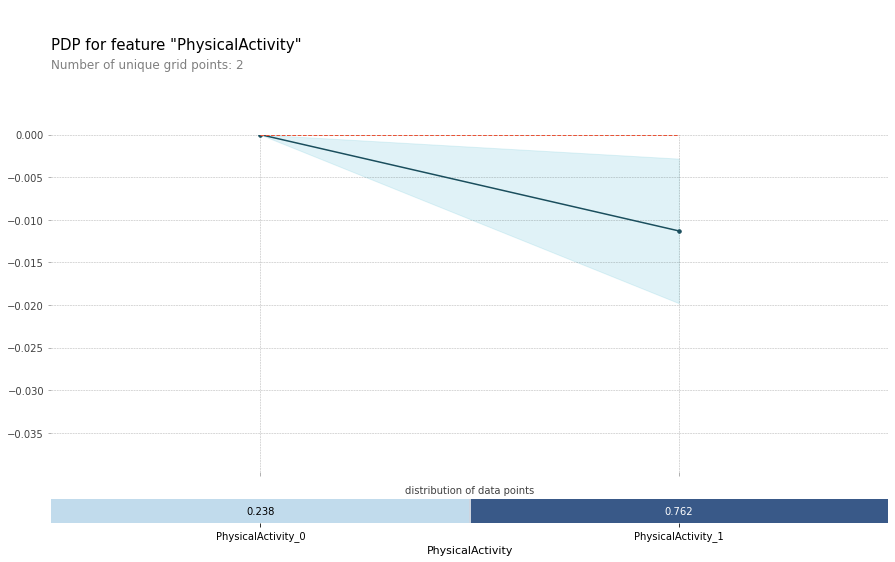

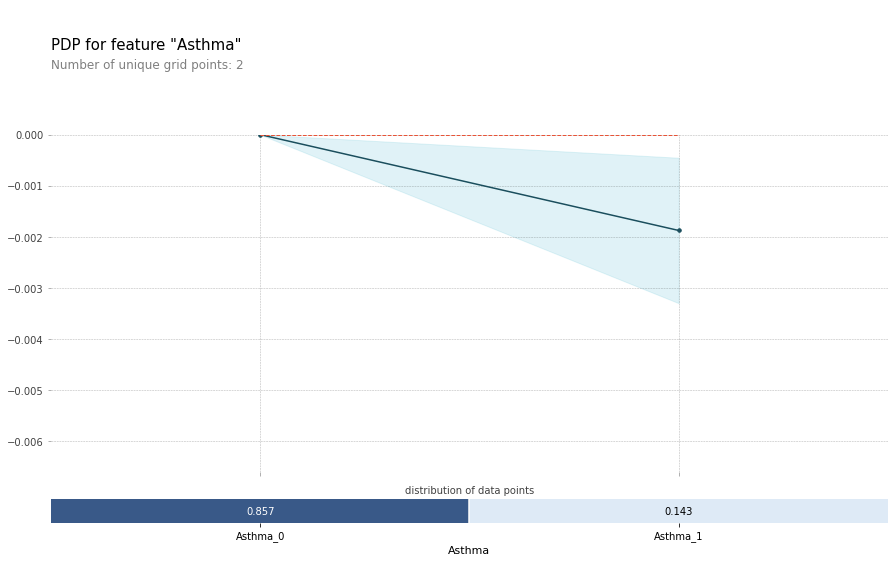

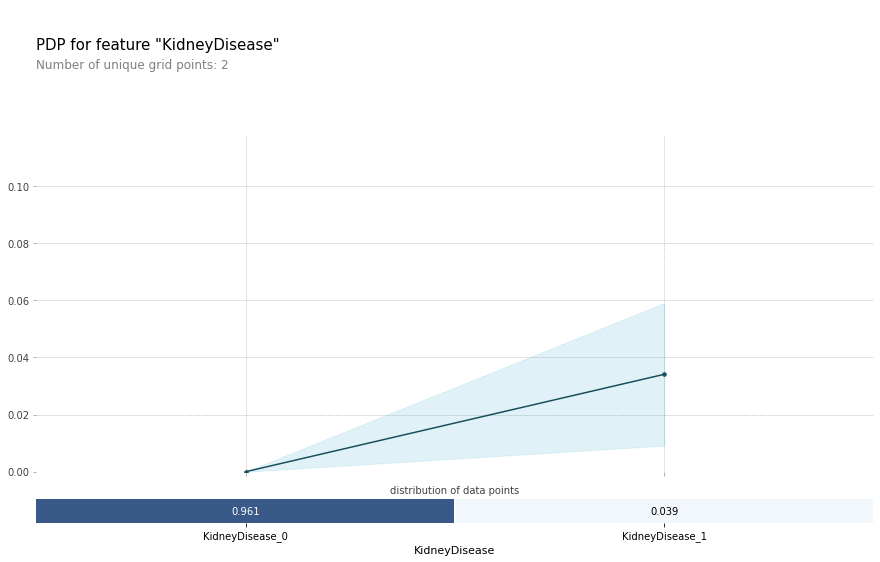

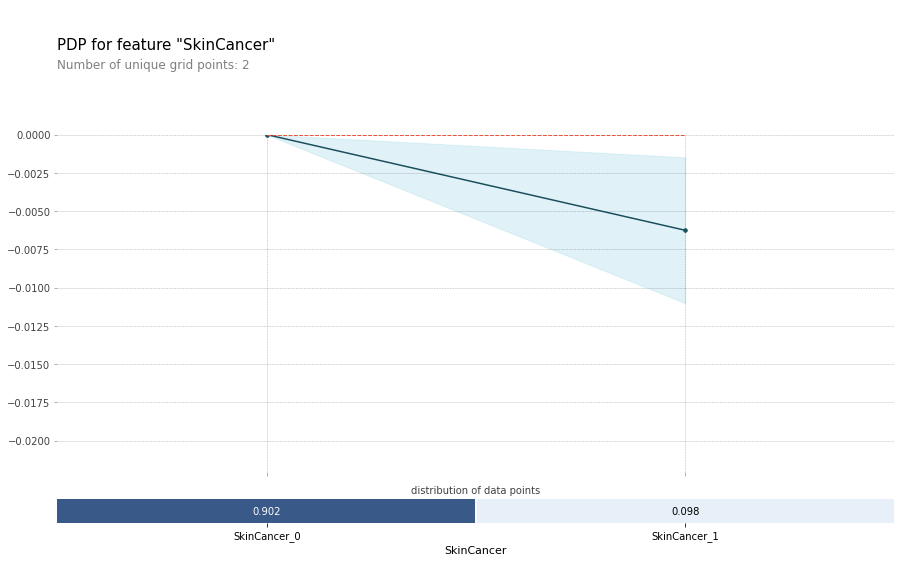

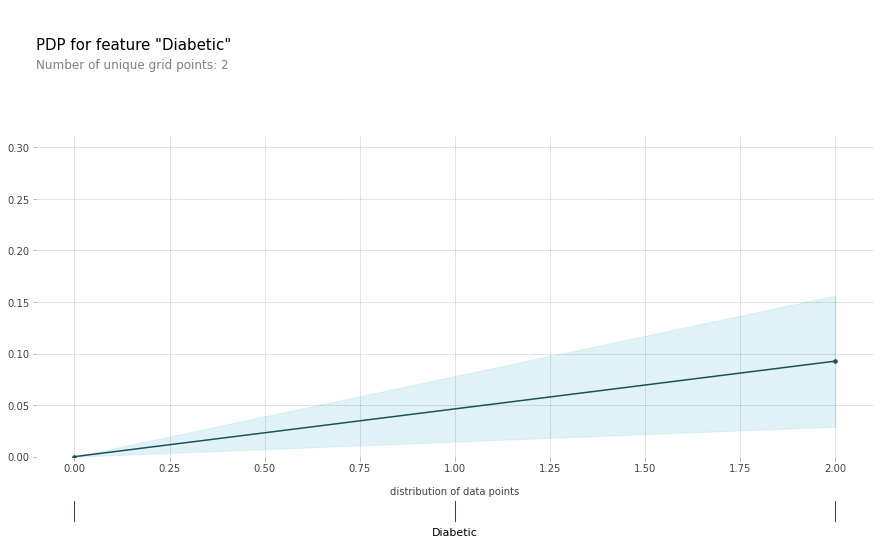

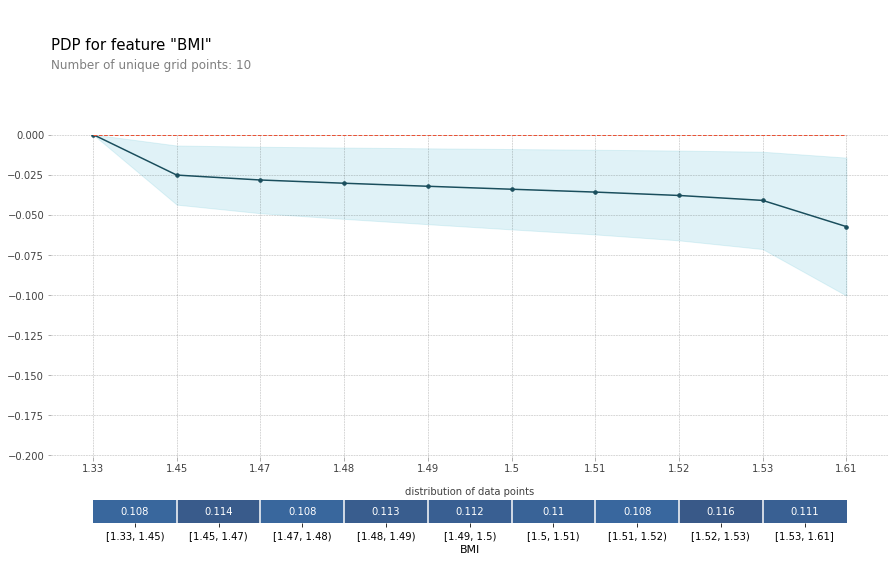

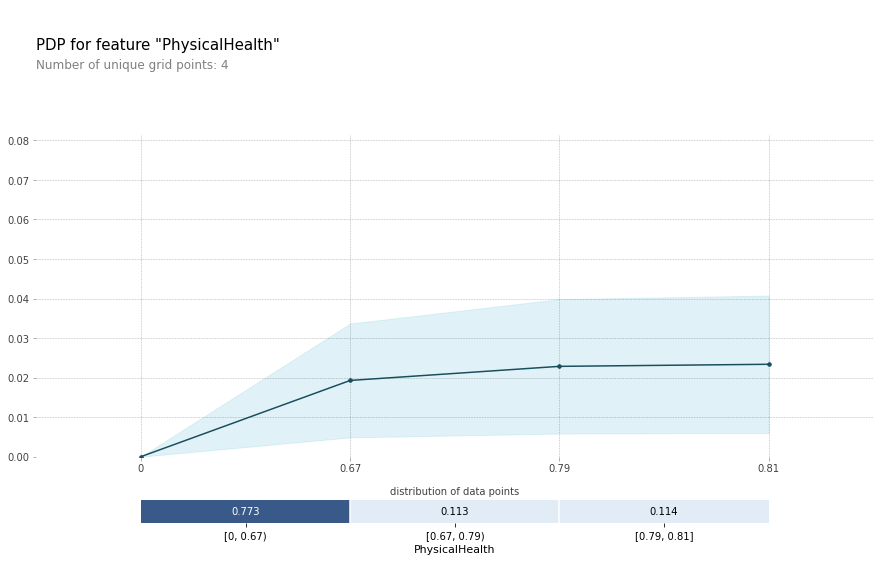

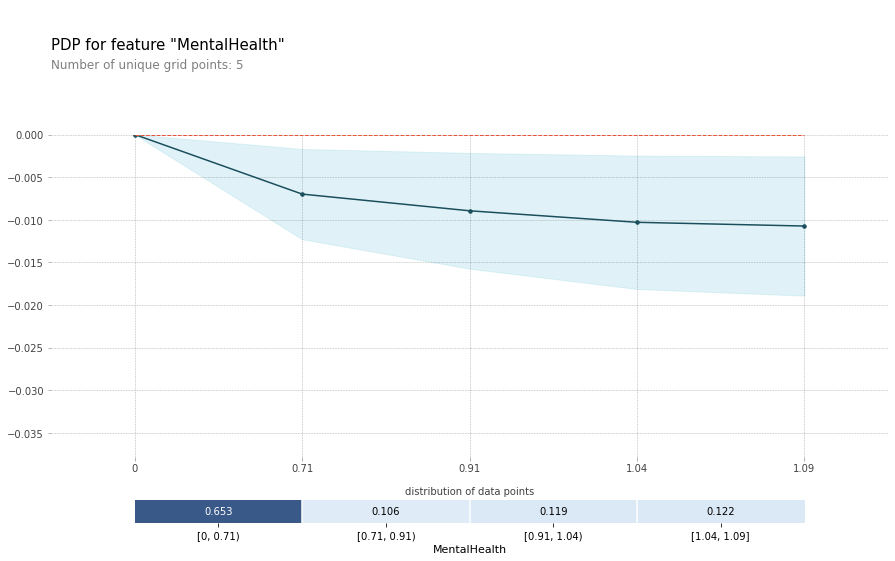

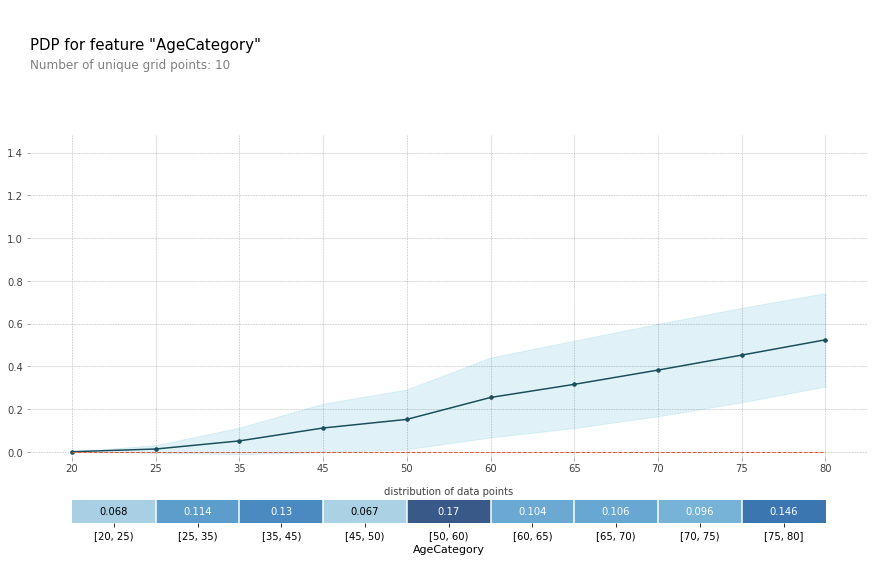

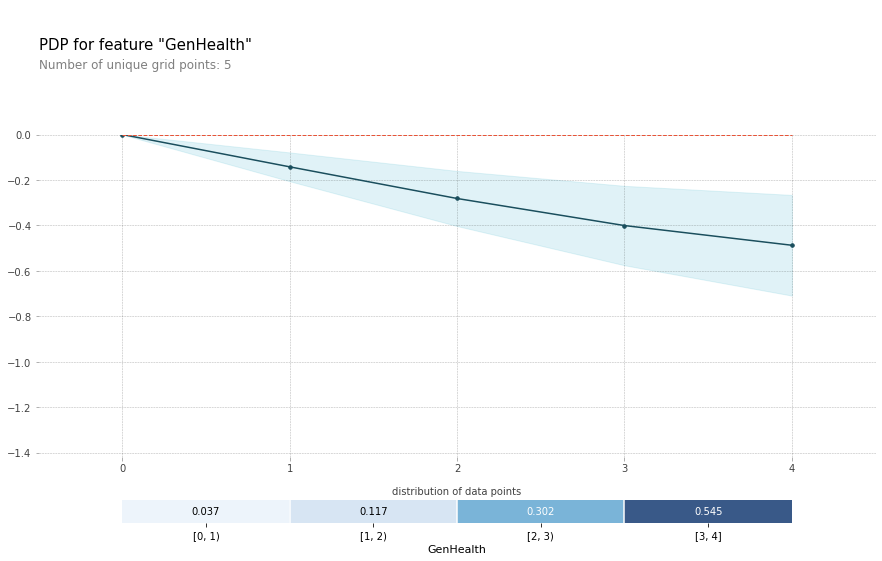

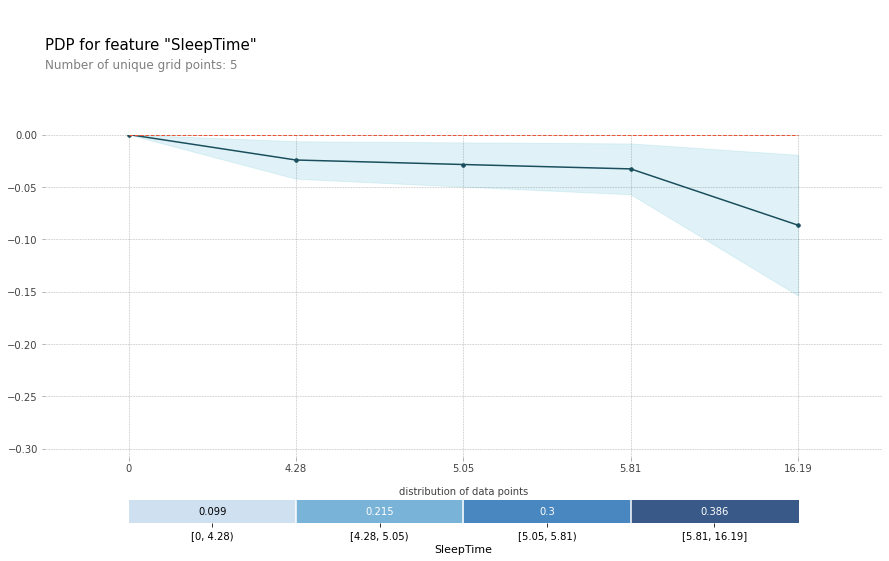

In [111]:
# PDP
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)

for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [112]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)

for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

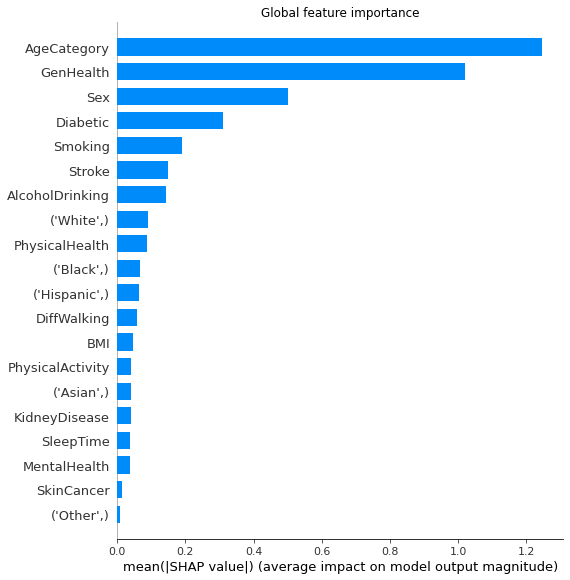

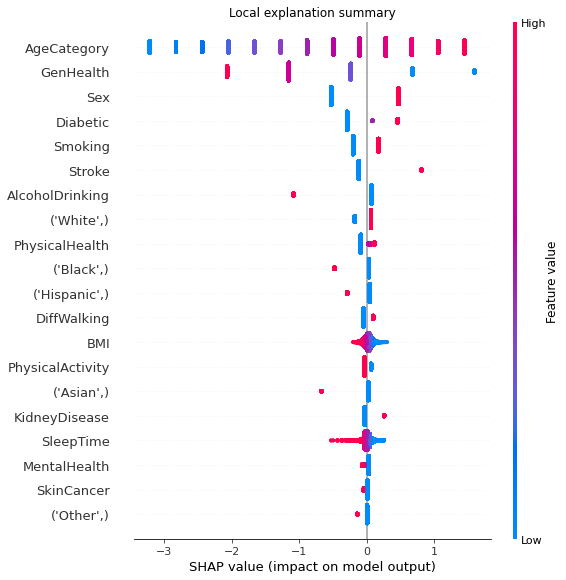

In [113]:
# SHAP
explainer = shap.Explainer(model_SVMSMOTE, x_train_SVMSMOTE, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")

plt.title('Local explanation summary')
shap.summary_plot(shap_values)

# ADASYN 샘플링 PDP, ICE, SHAP

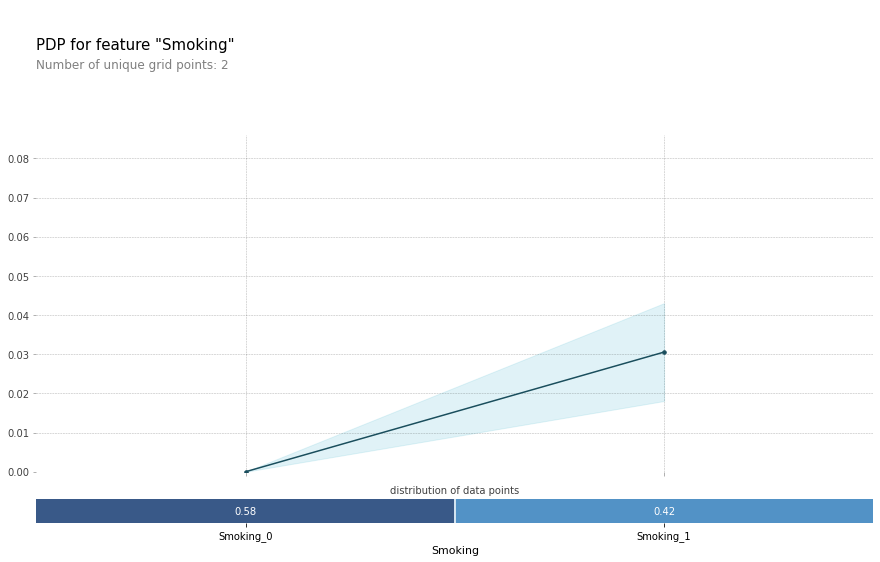

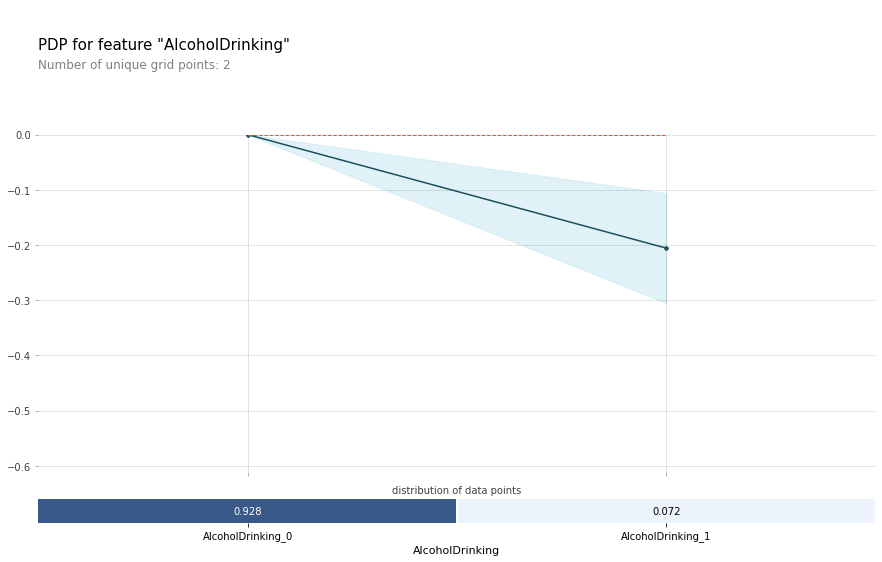

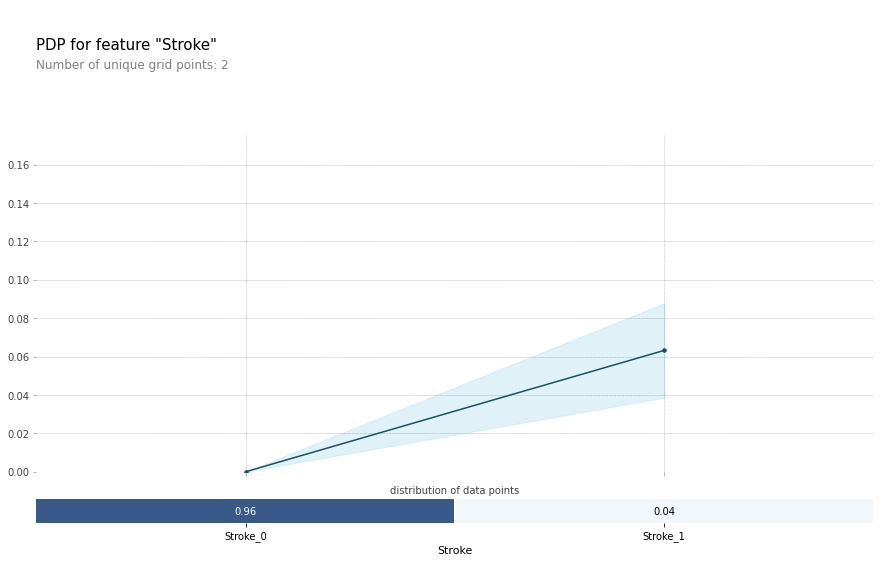

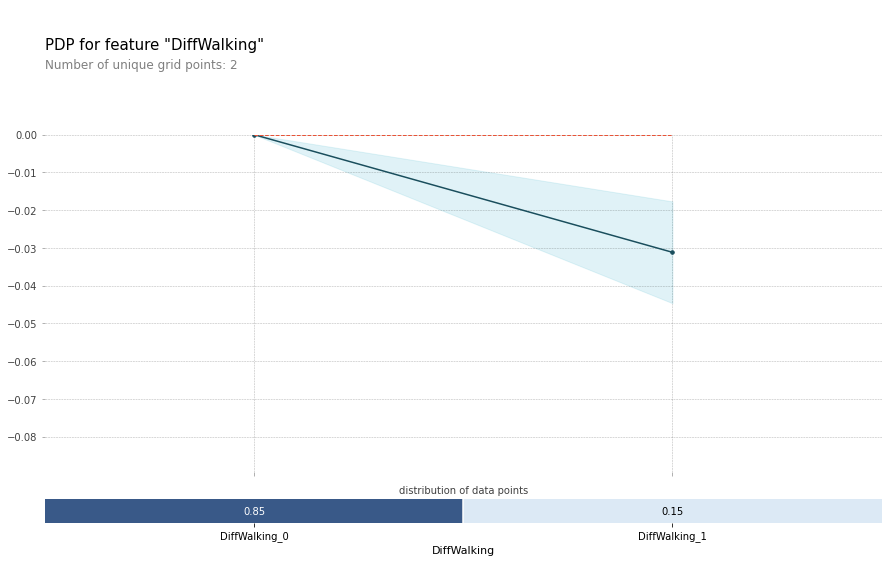

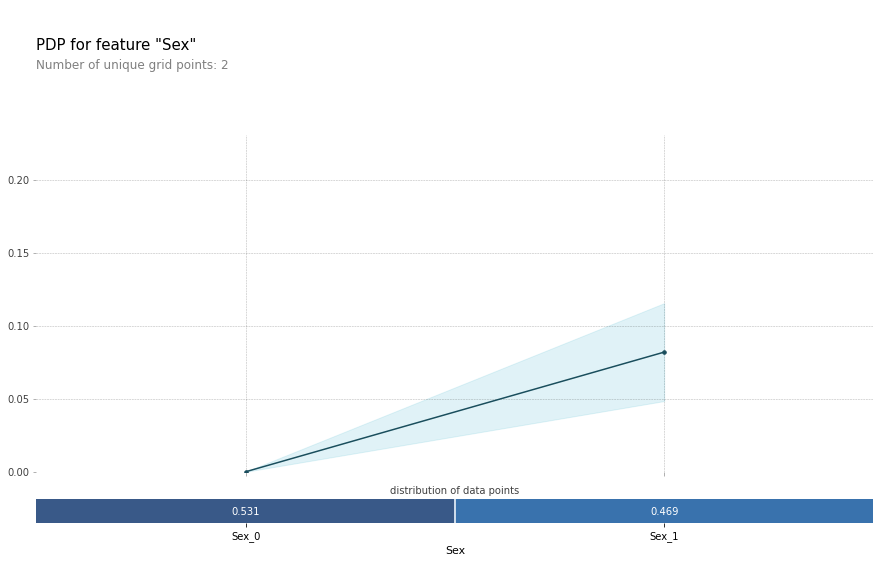

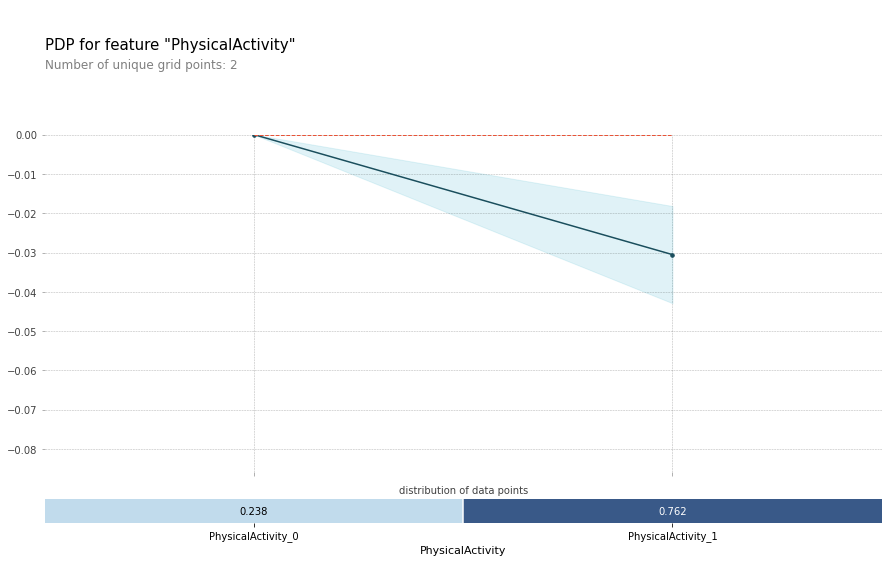

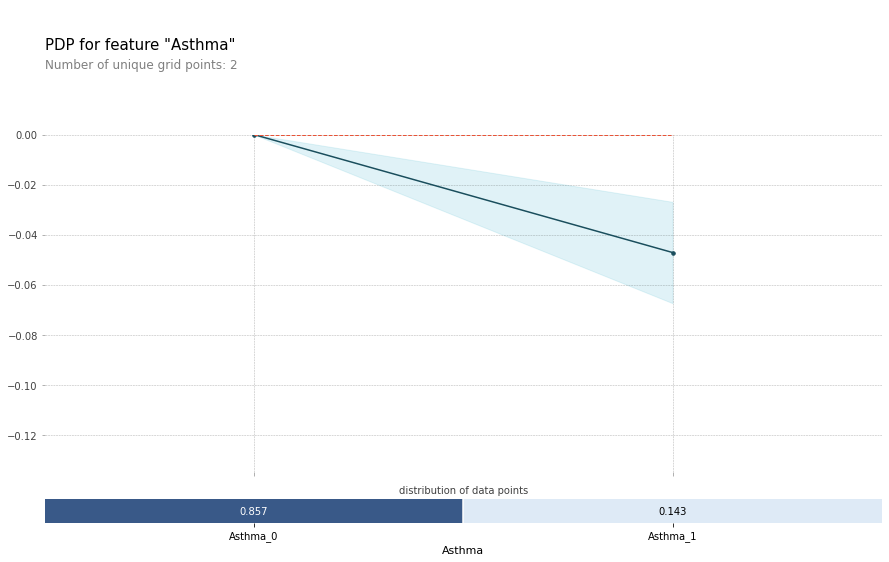

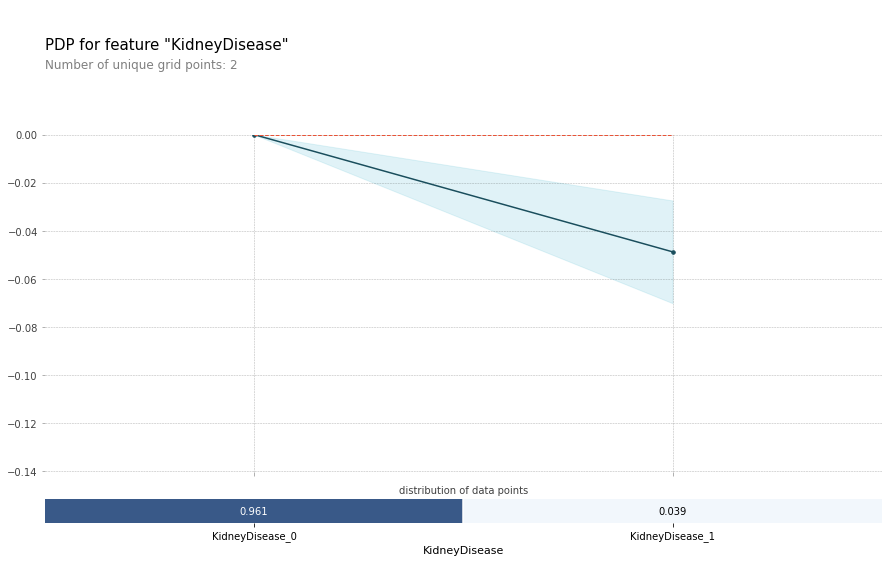

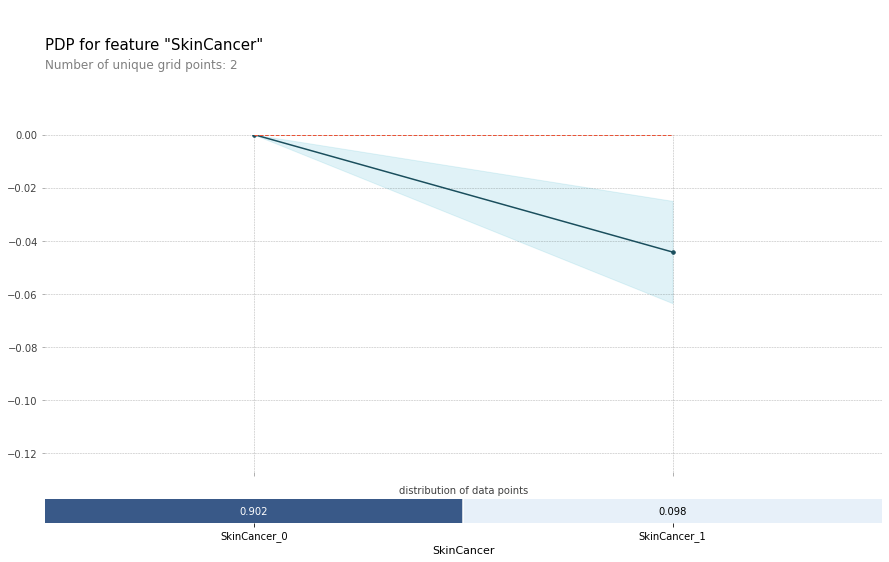

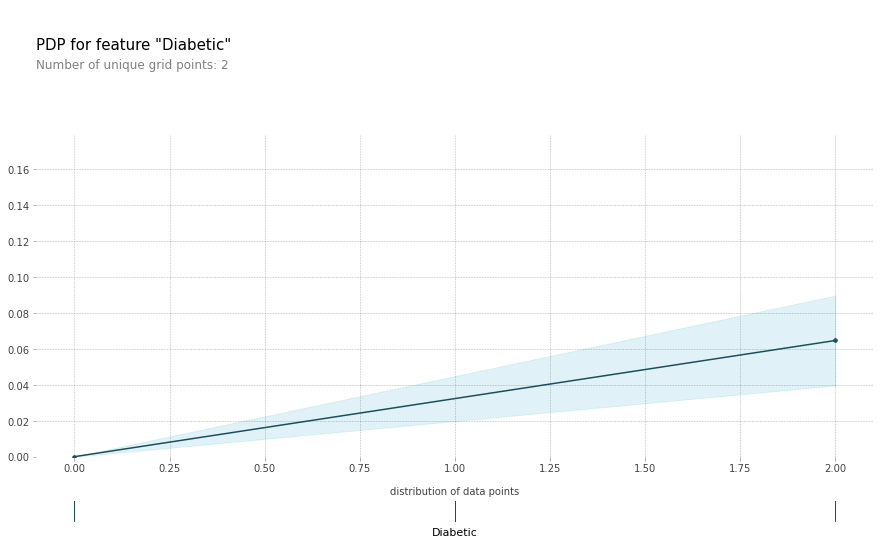

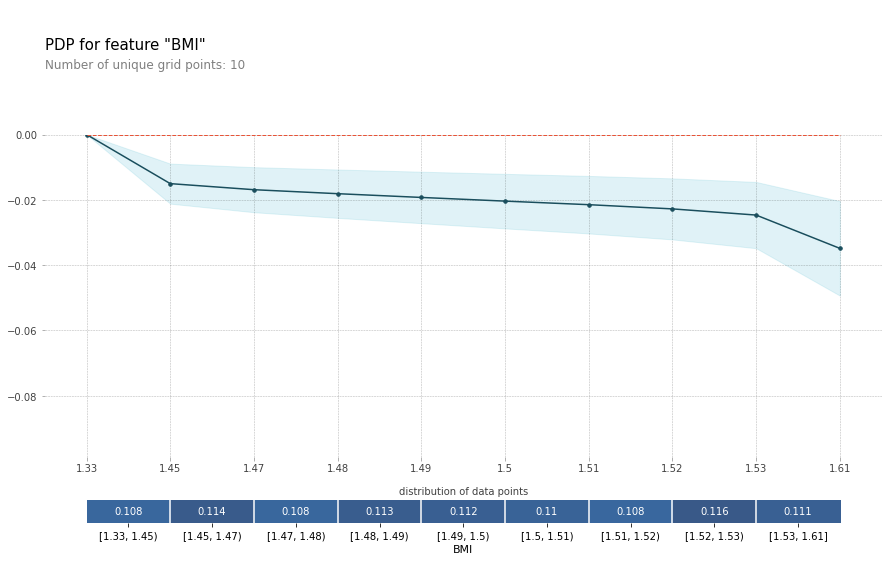

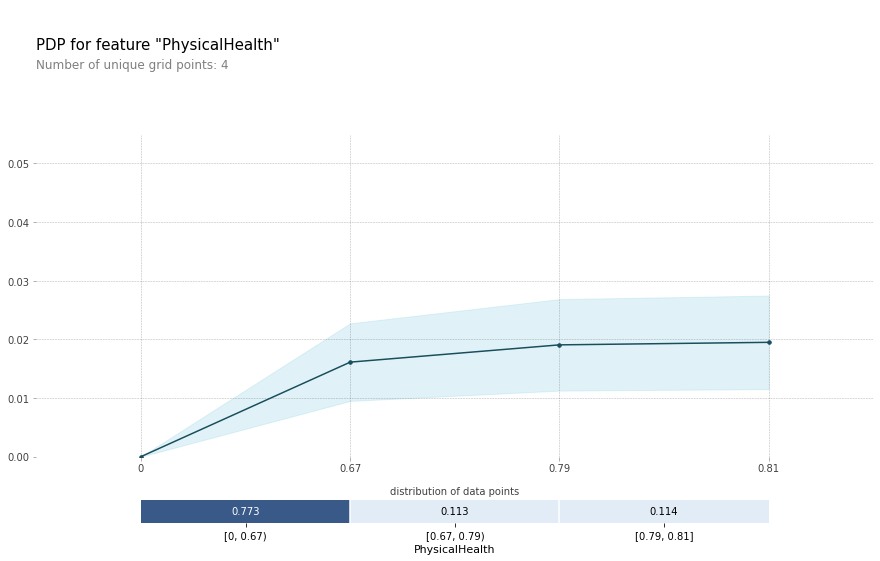

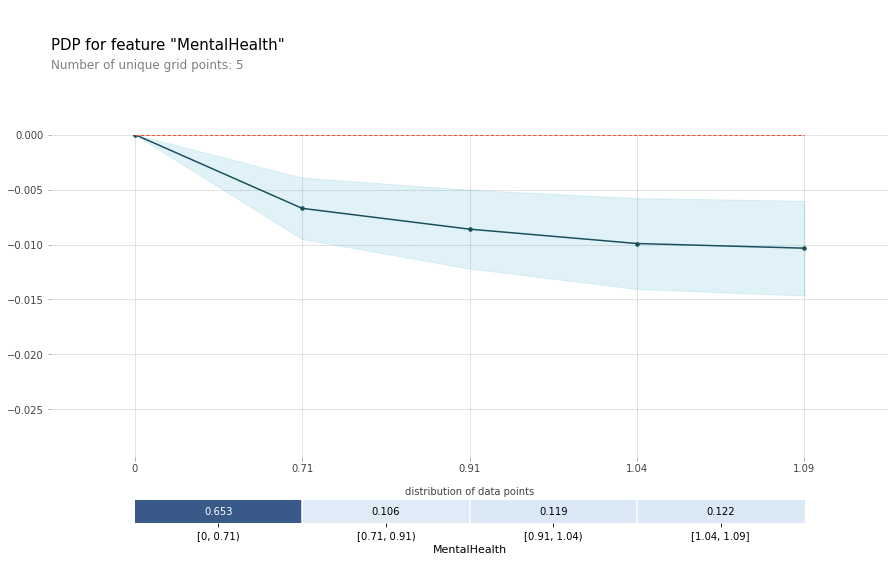

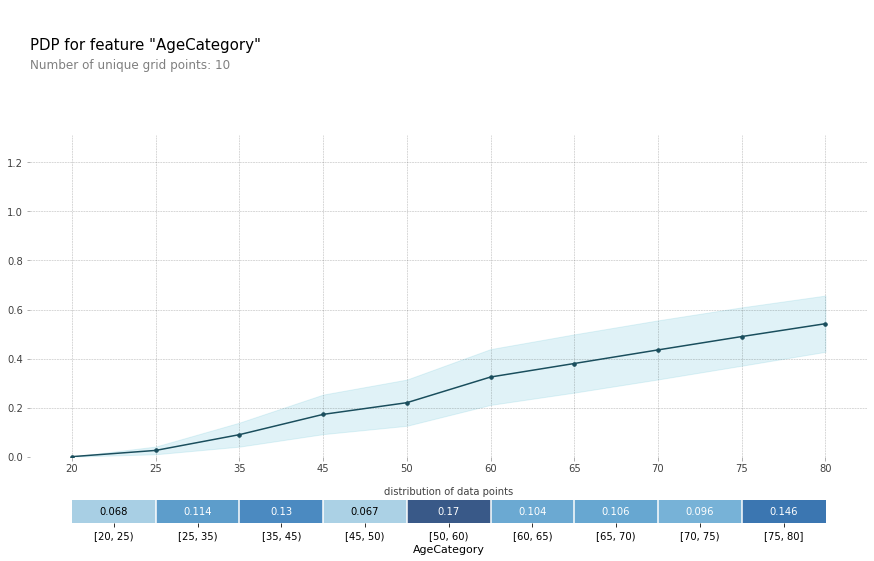

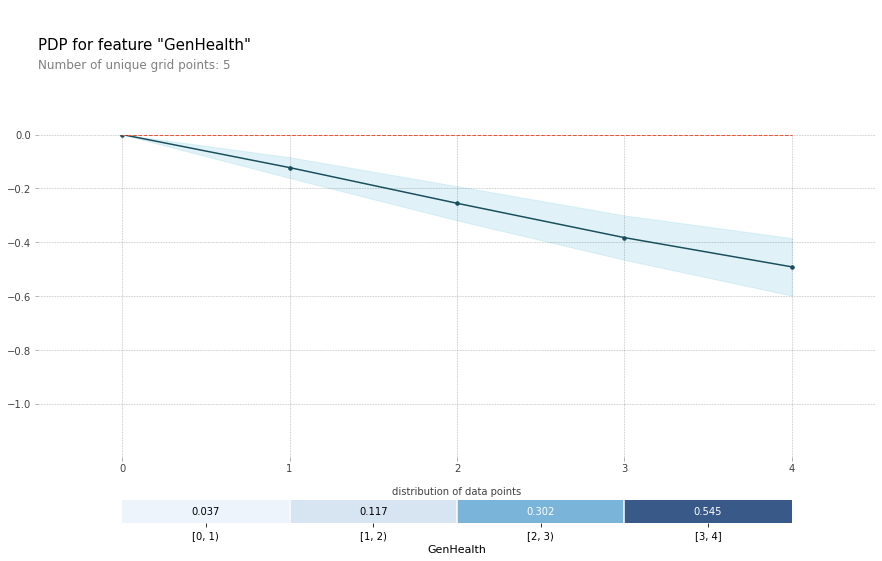

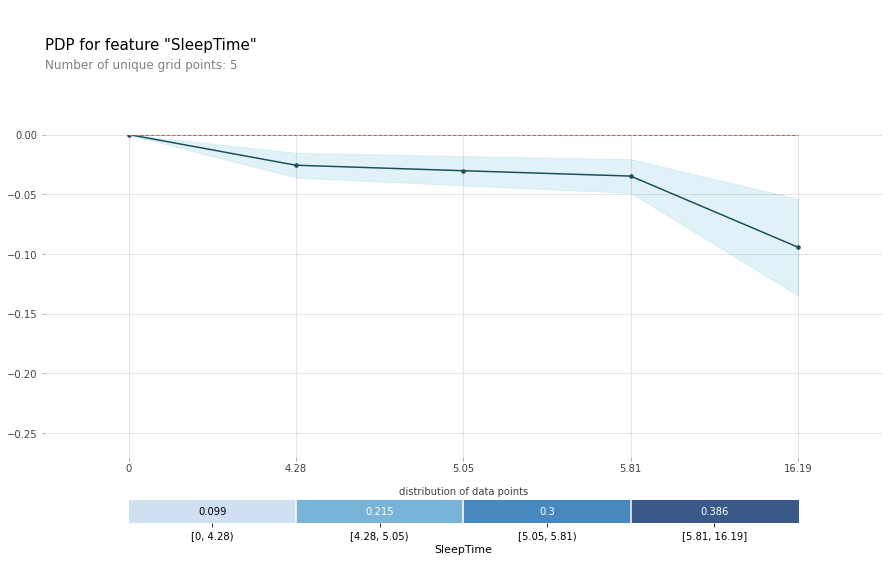

In [114]:
# PDP
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)

for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [115]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)

for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

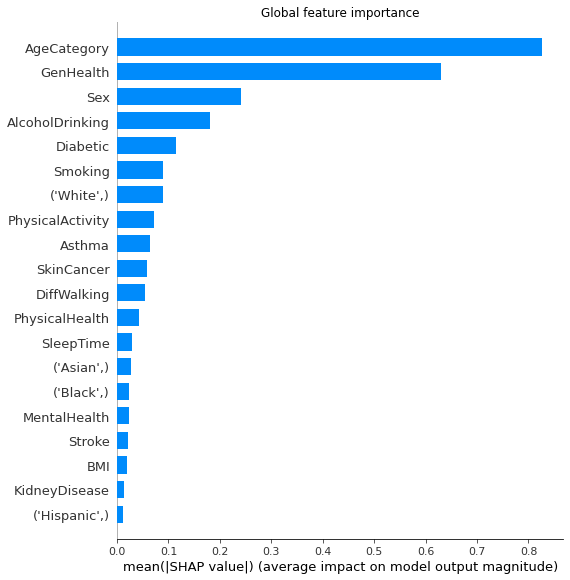

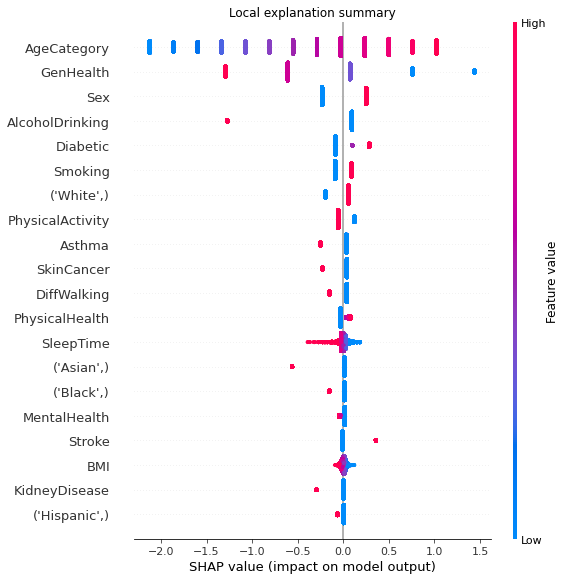

In [116]:
# SHAP
explainer = shap.Explainer(model_ADASYN, x_train_ADASYN, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

# SMOTE-ENN 샘플링 PDP, ICE, SHAP

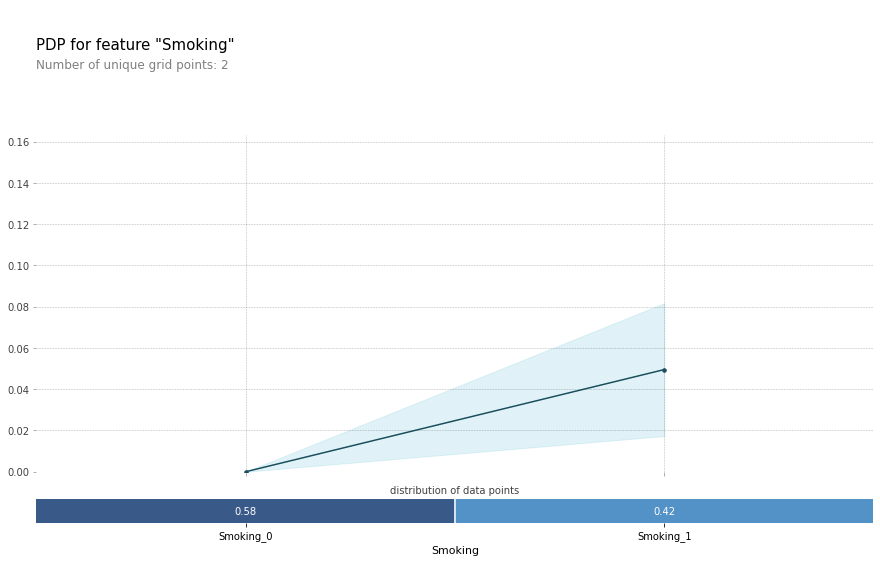

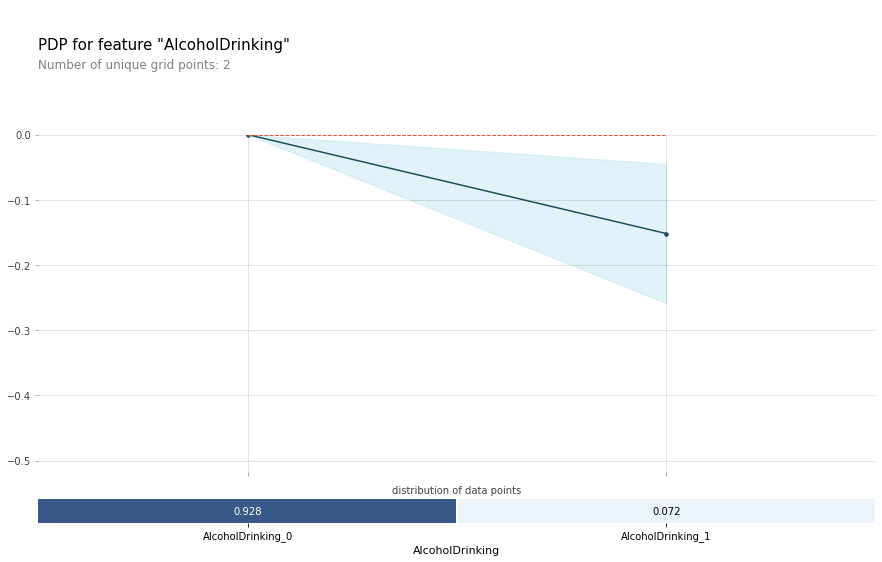

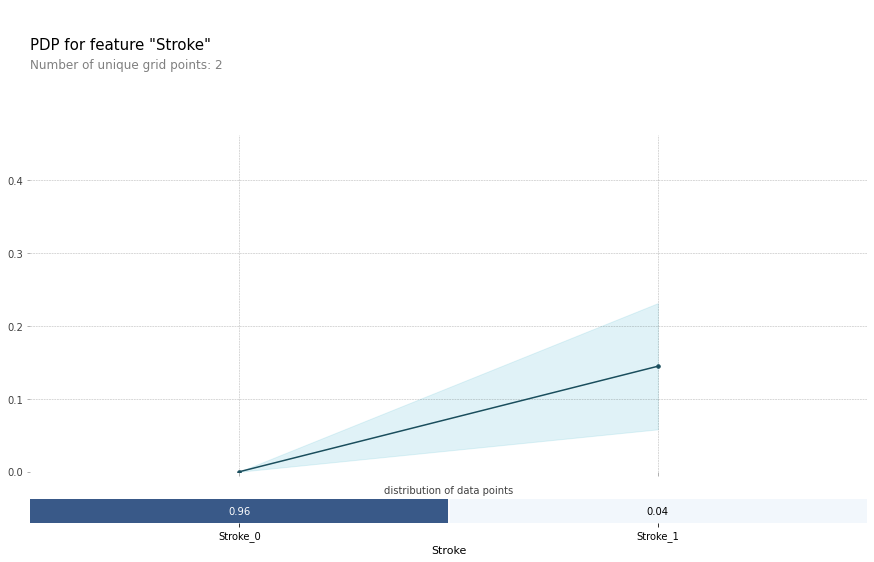

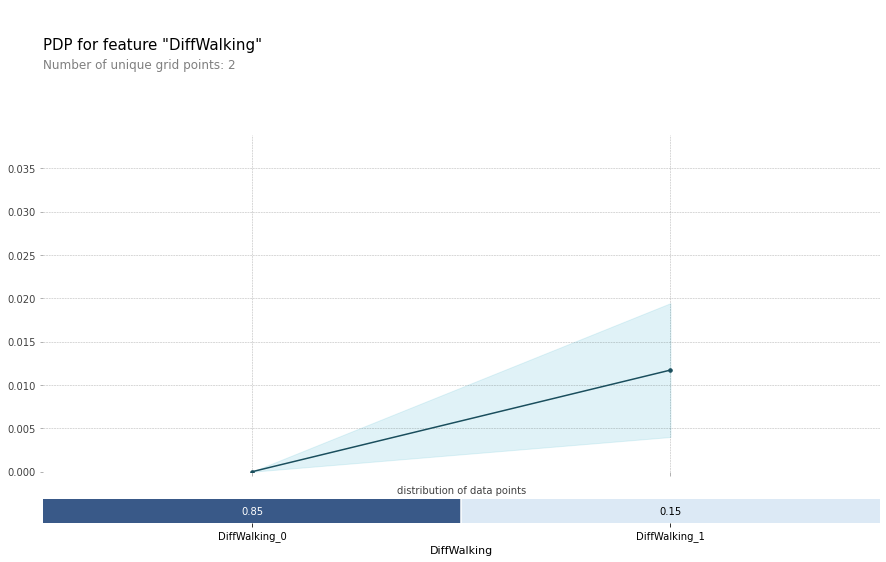

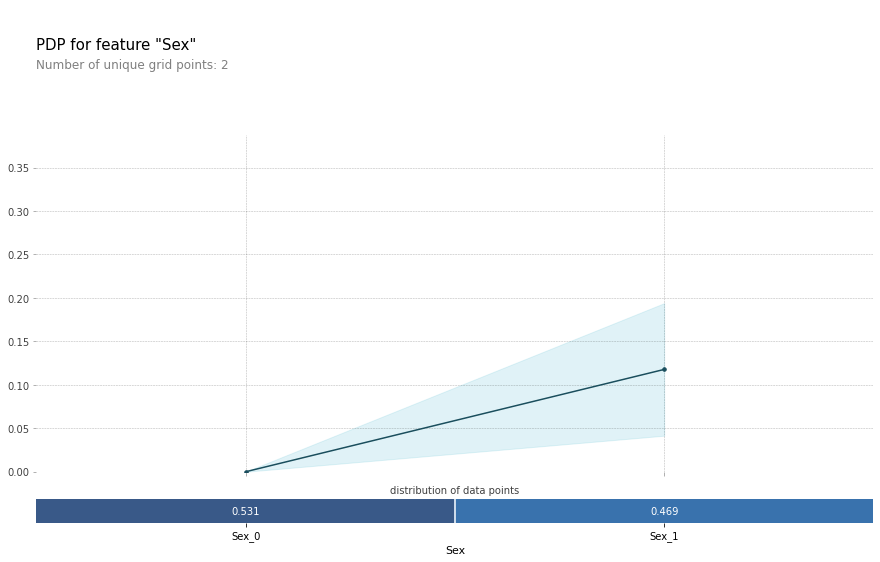

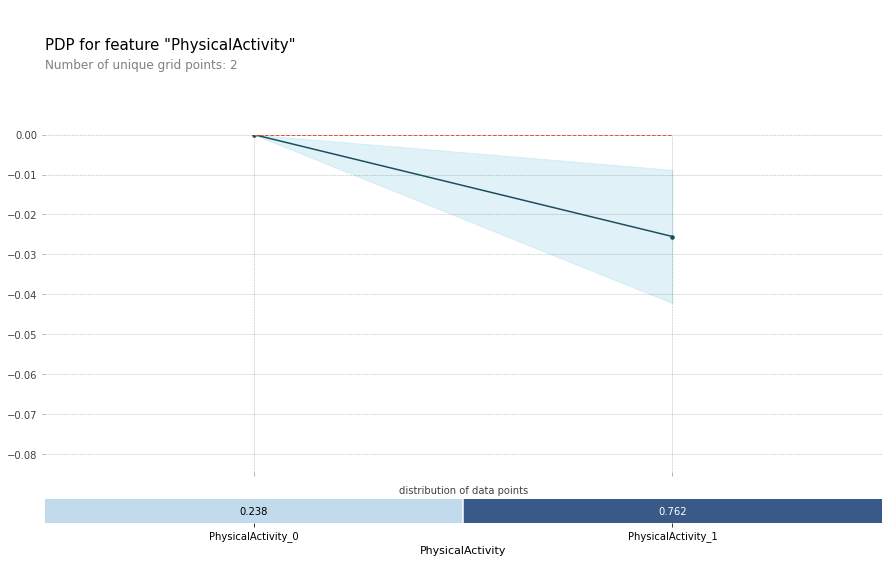

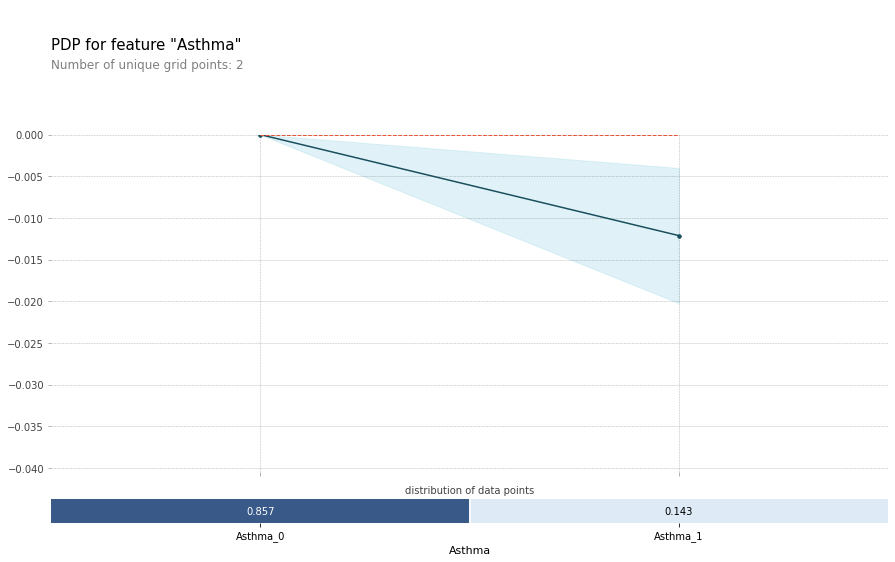

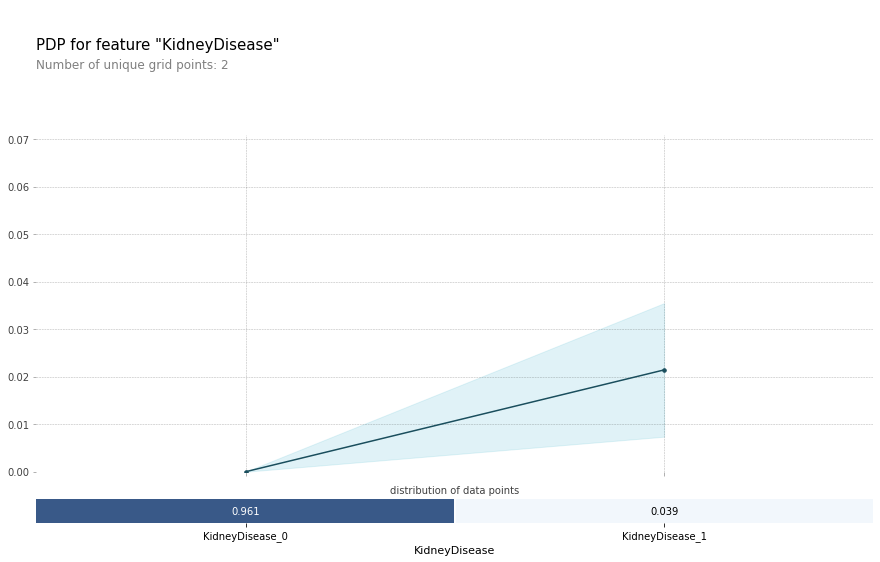

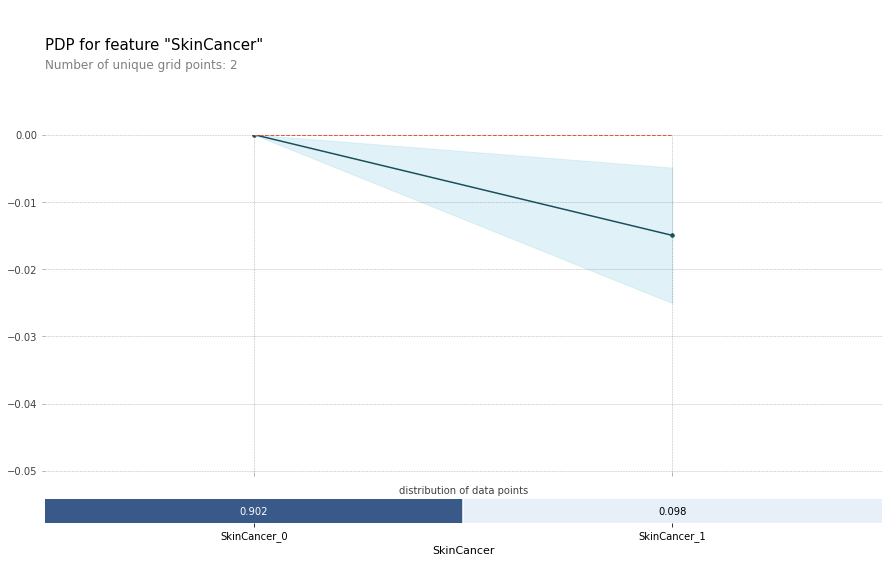

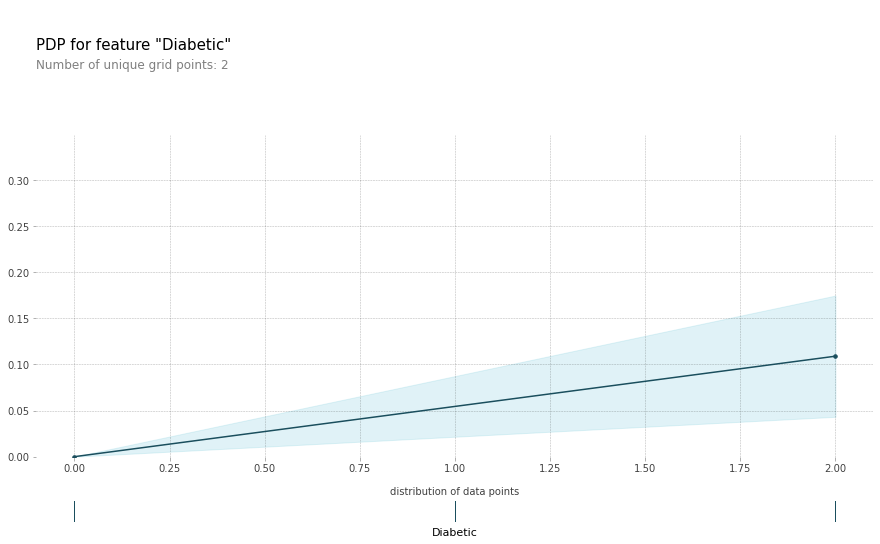

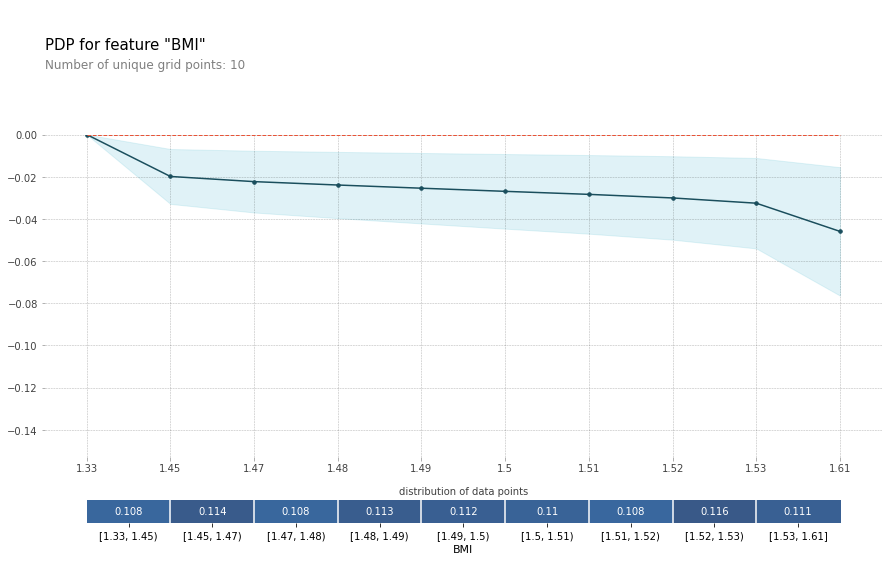

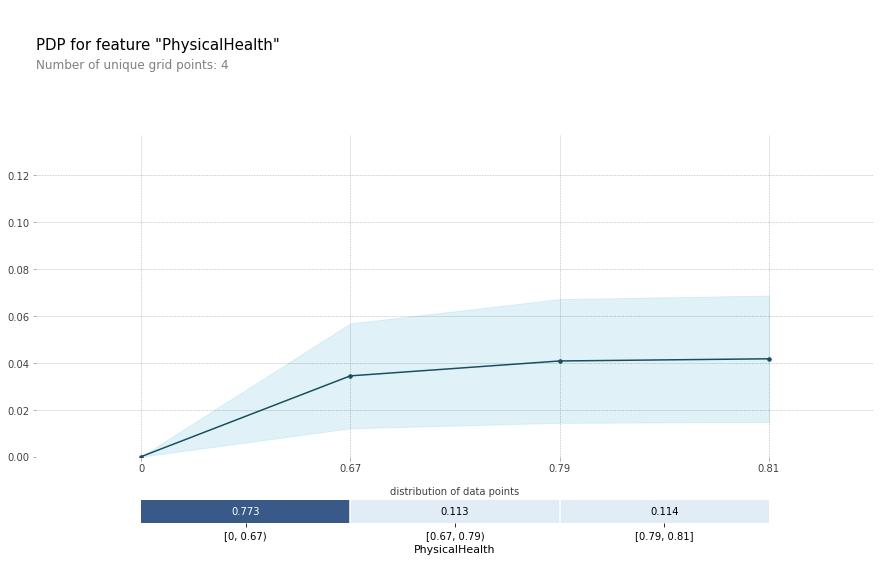

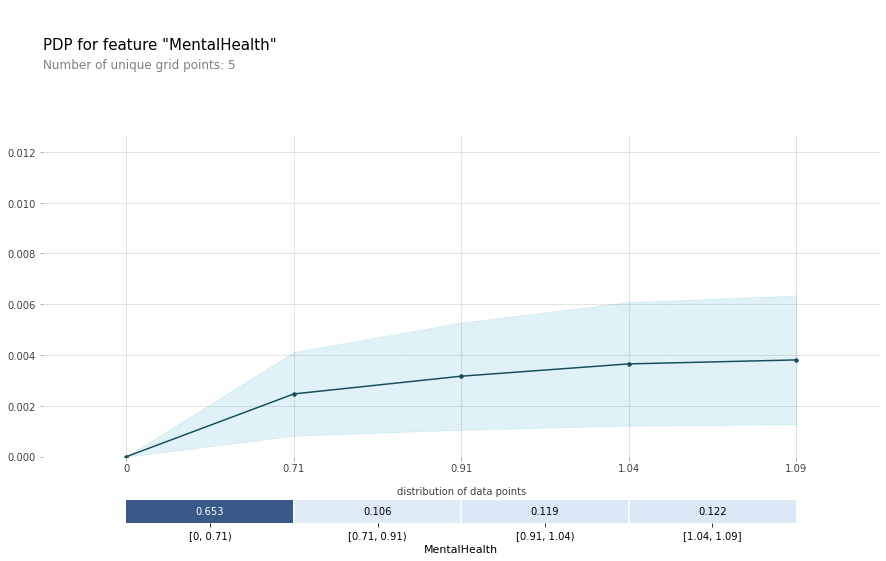

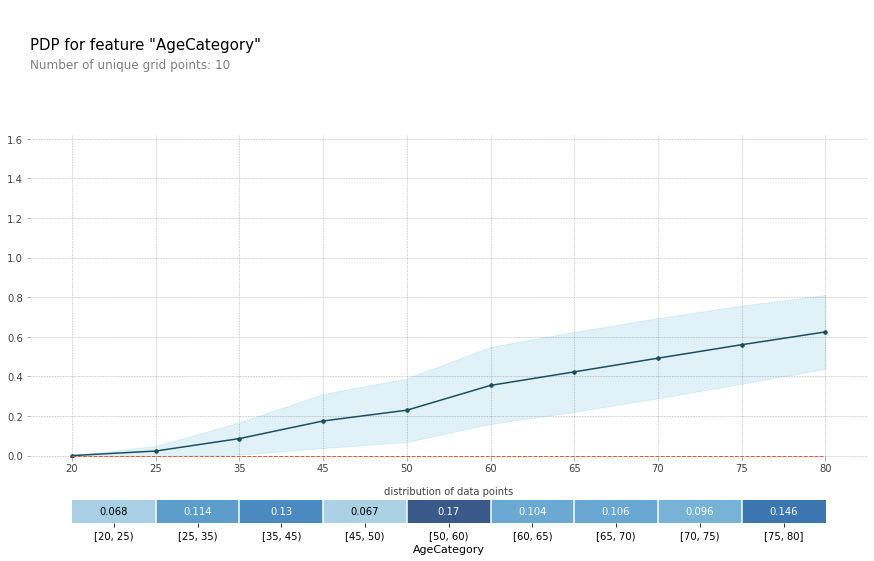

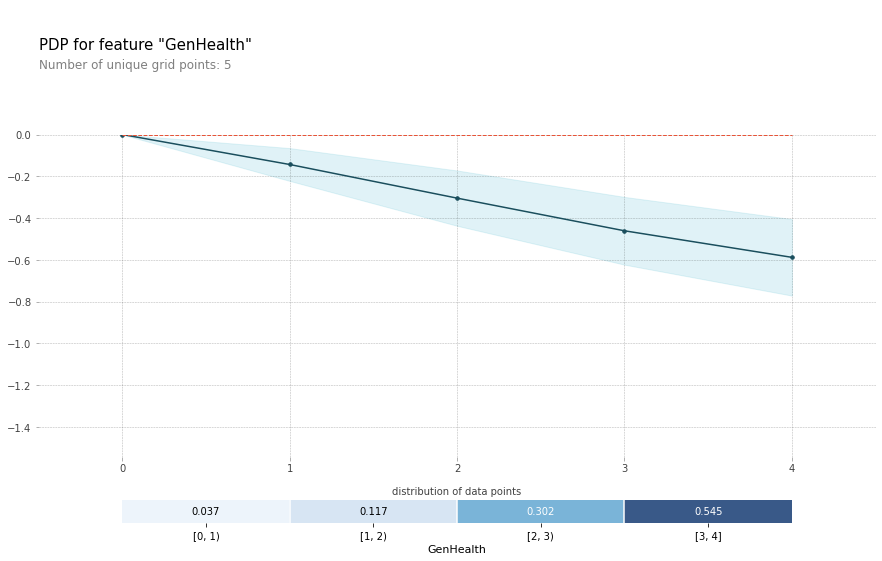

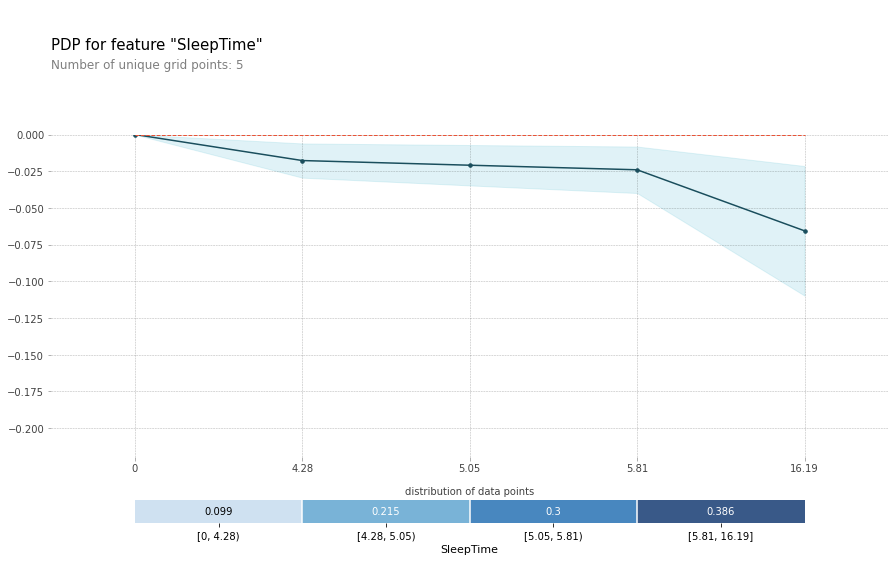

In [117]:
# PDP
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)

for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [118]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)

for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

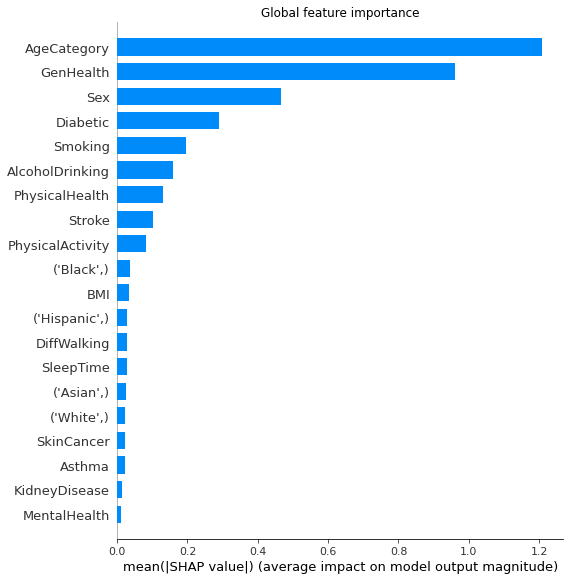

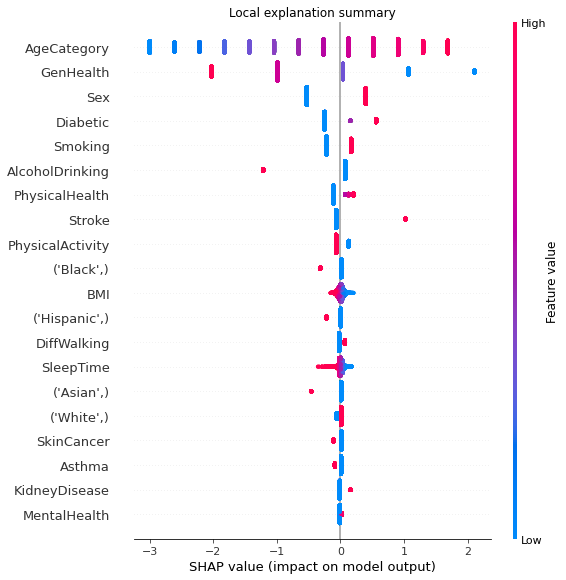

In [119]:
# SHAP
explainer = shap.Explainer(model_SMOTEENN, x_train_SMOTEENN, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

# CostSensitive Model - PDP, ICE, SHAP

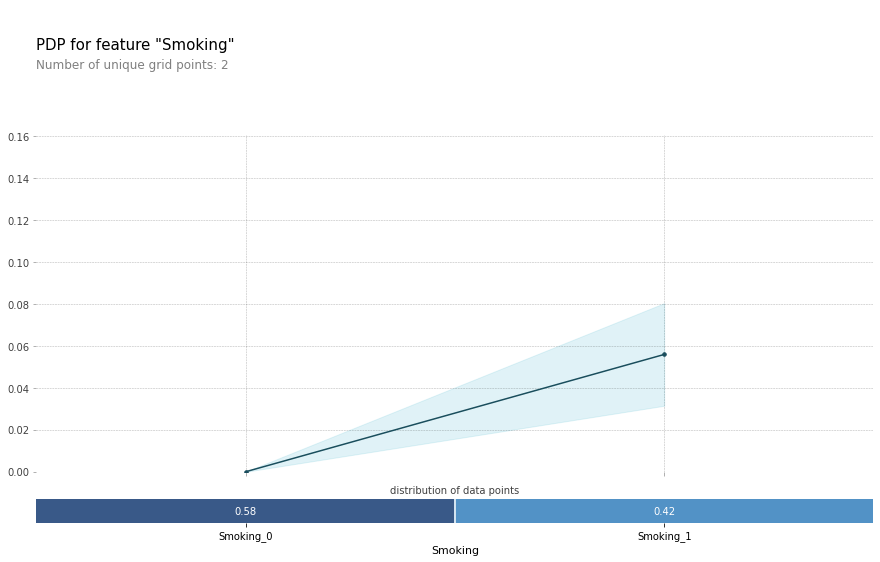

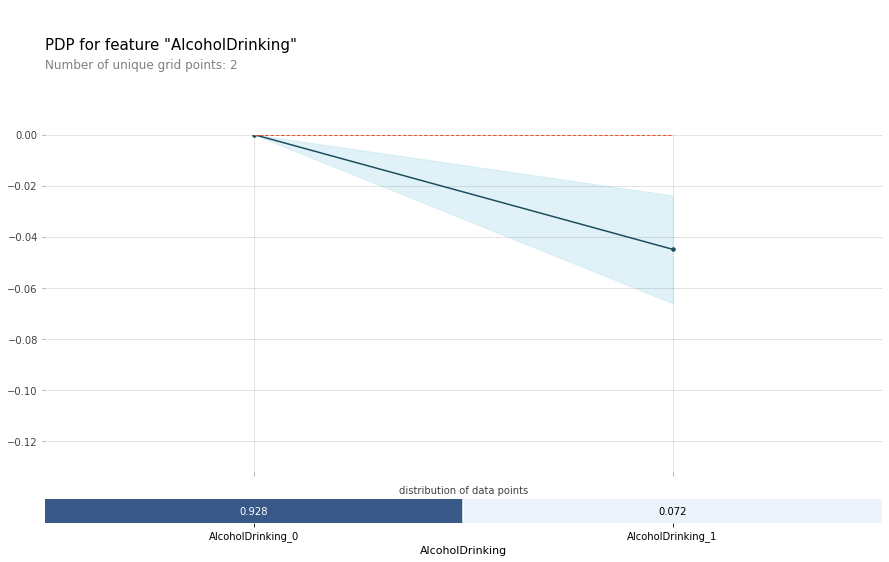

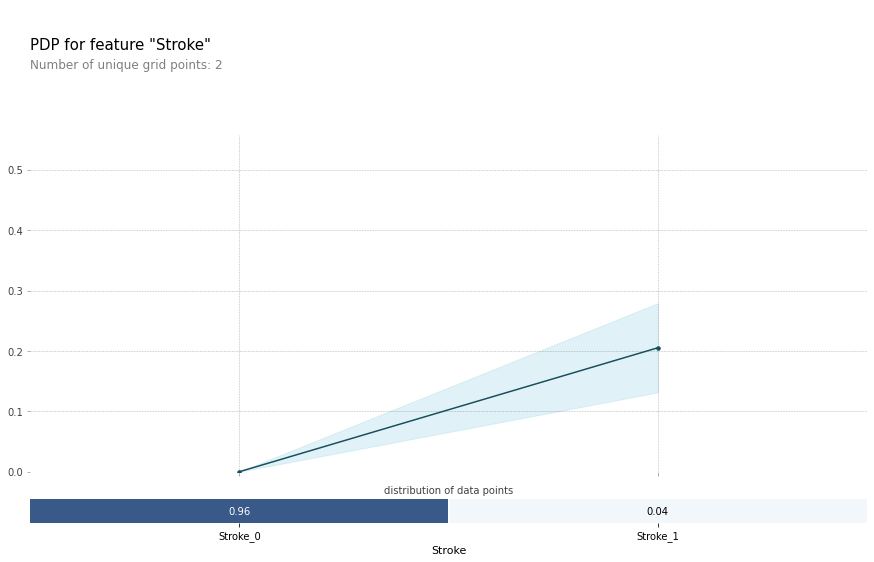

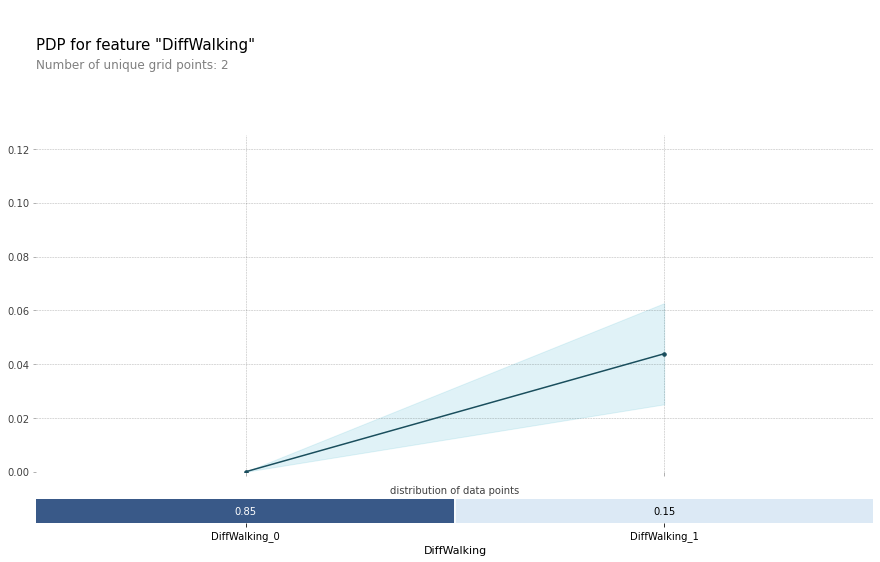

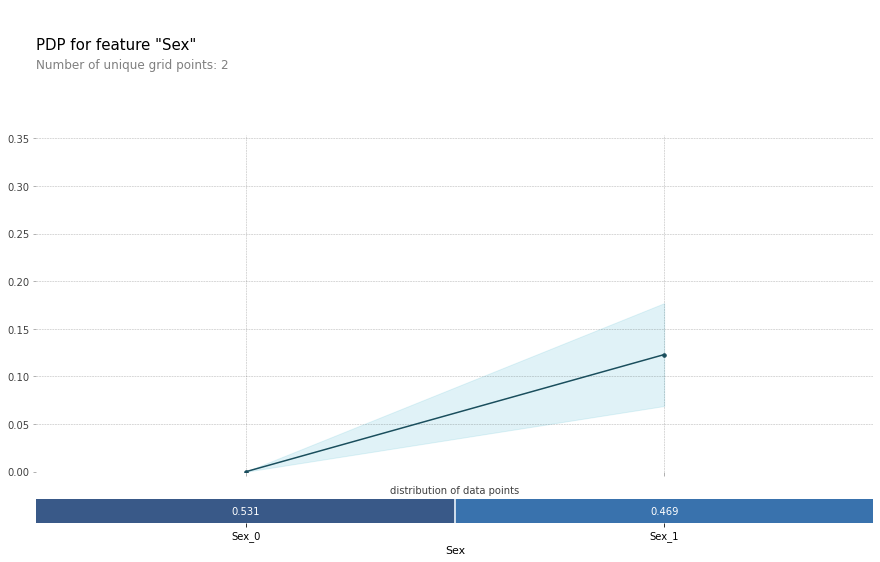

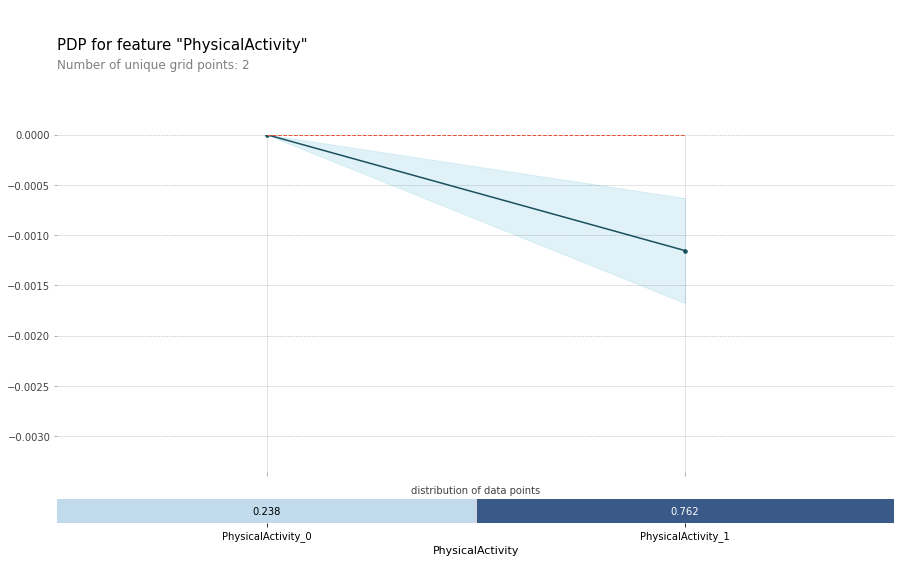

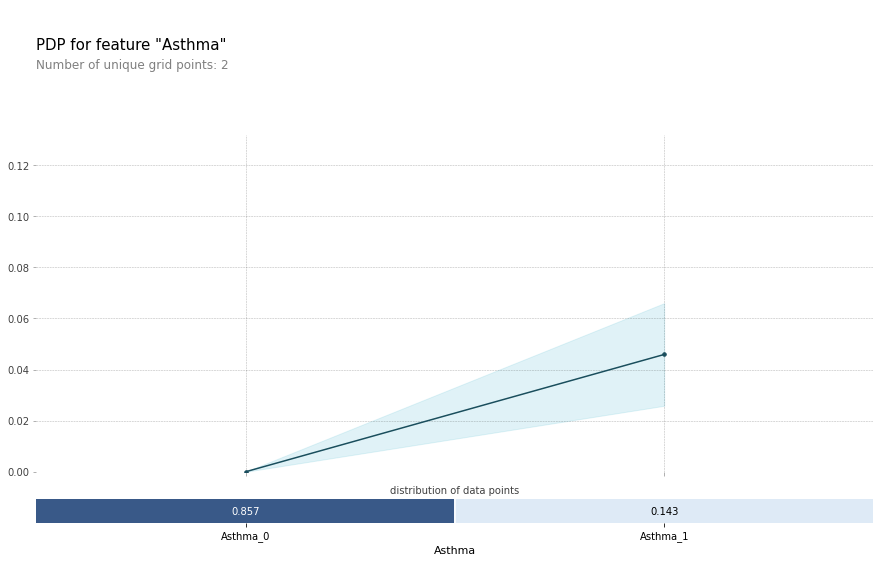

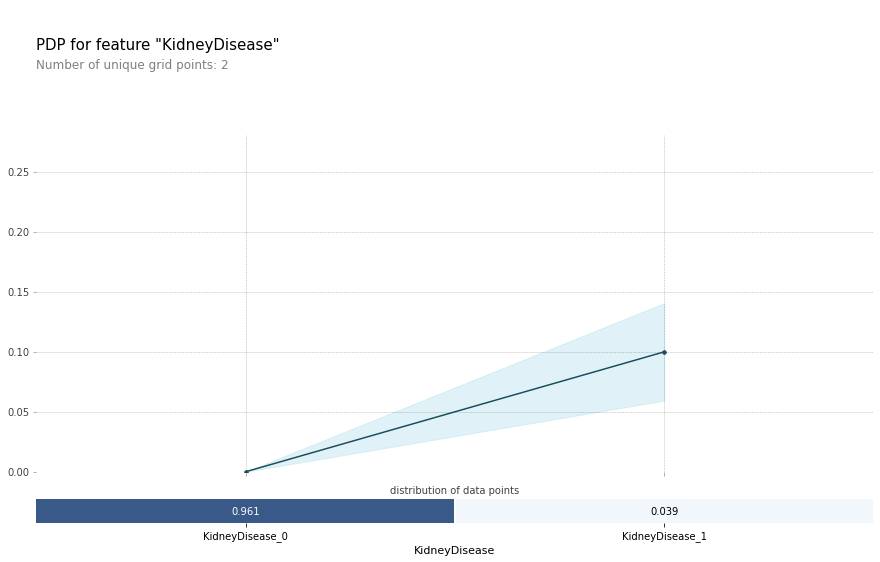

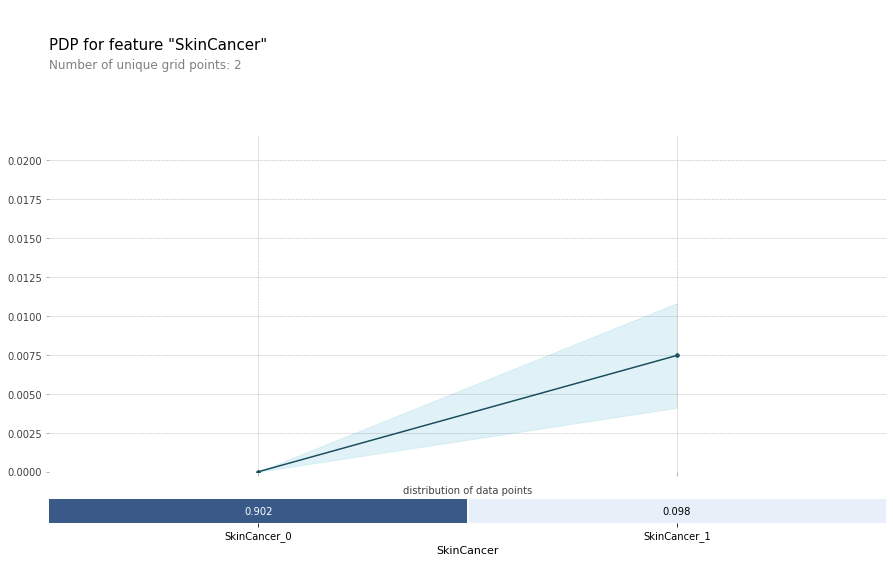

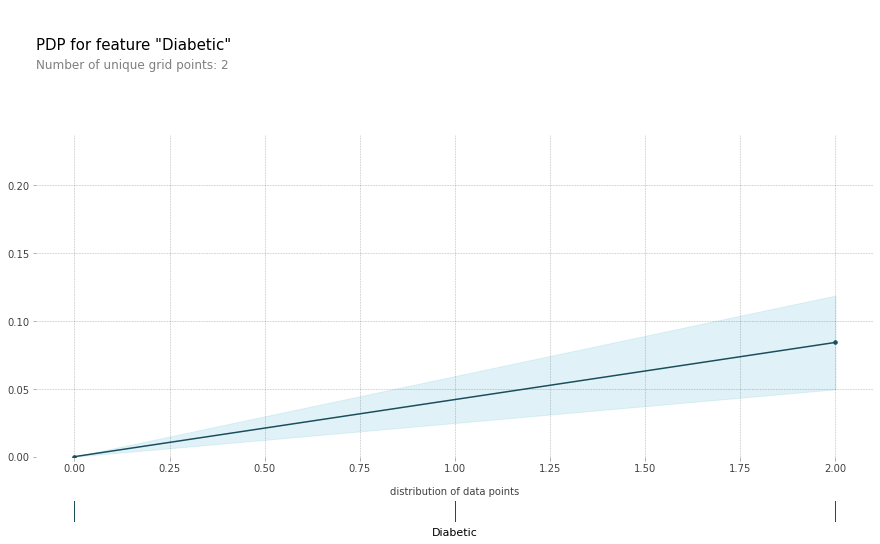

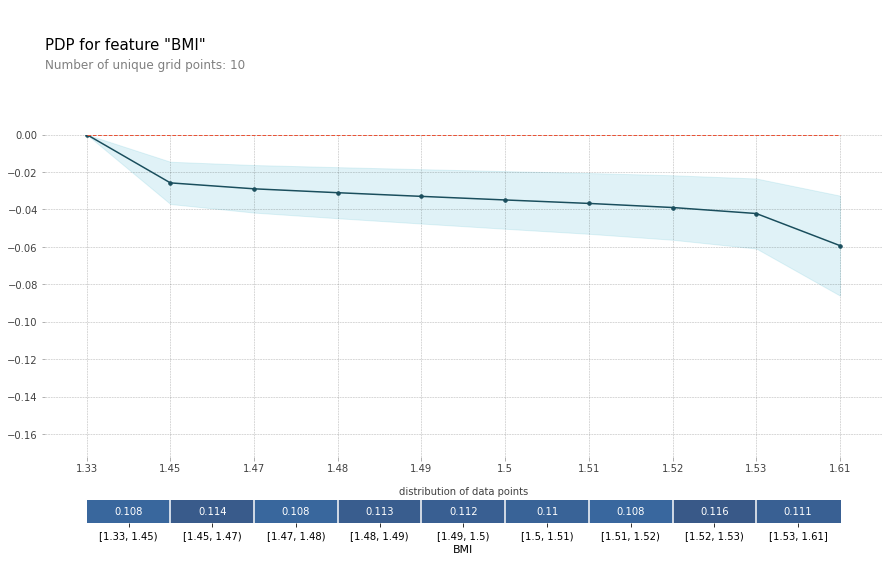

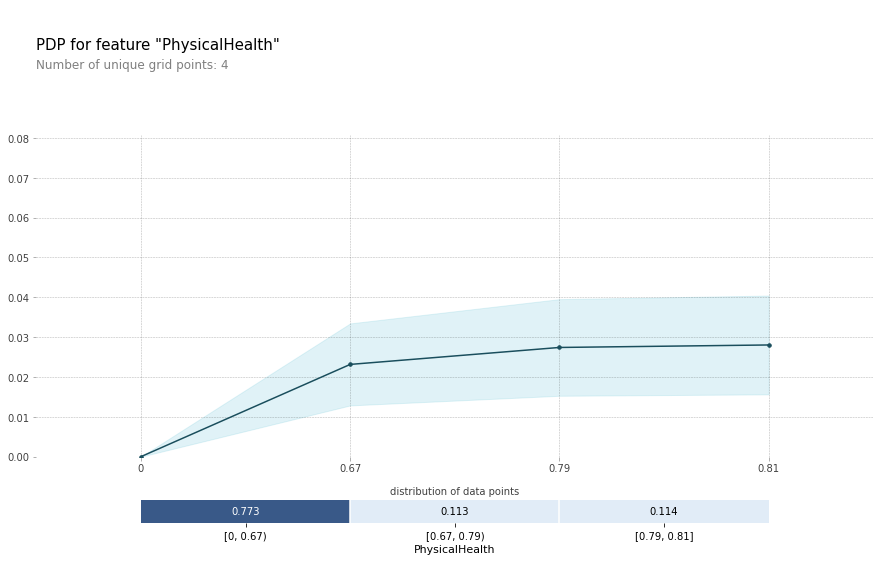

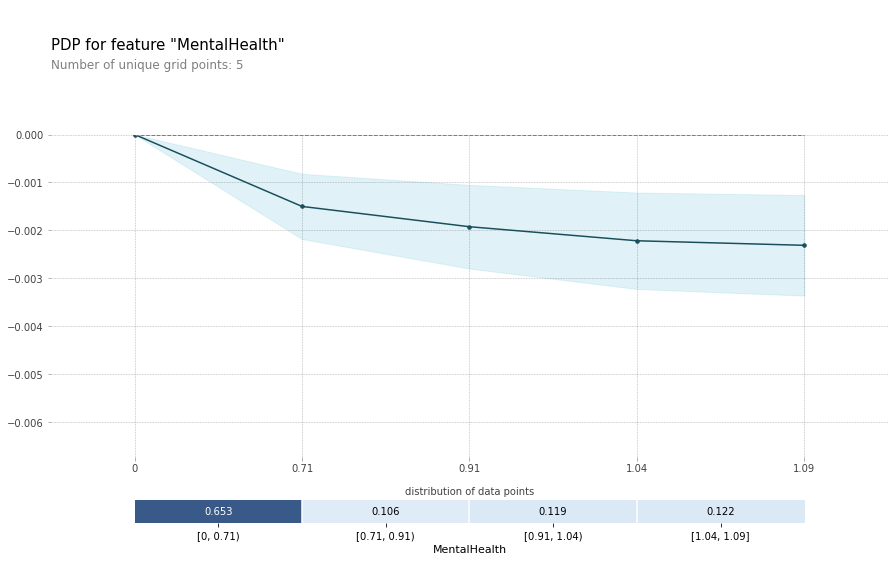

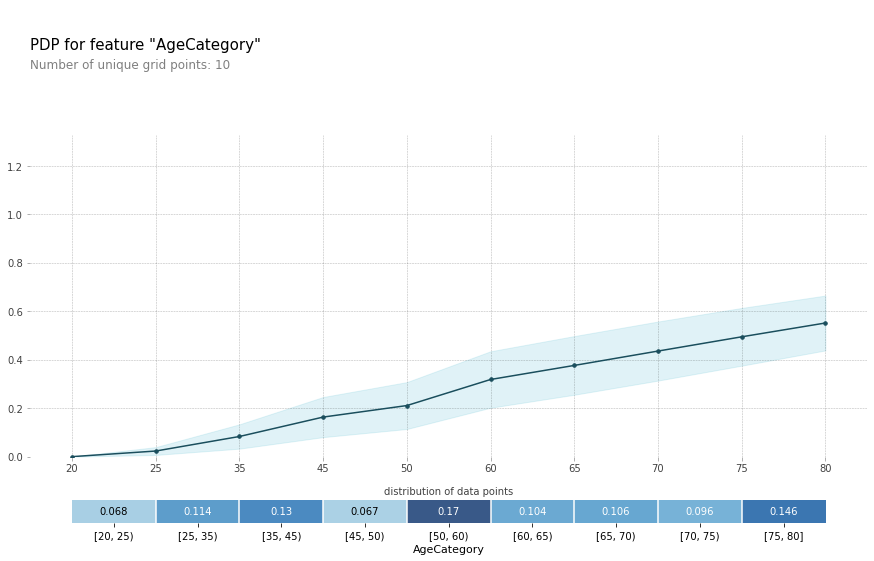

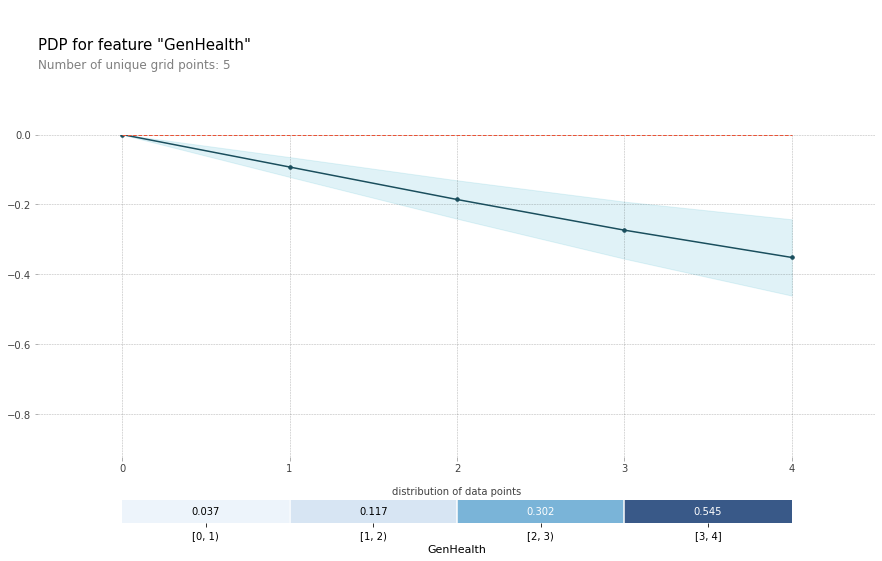

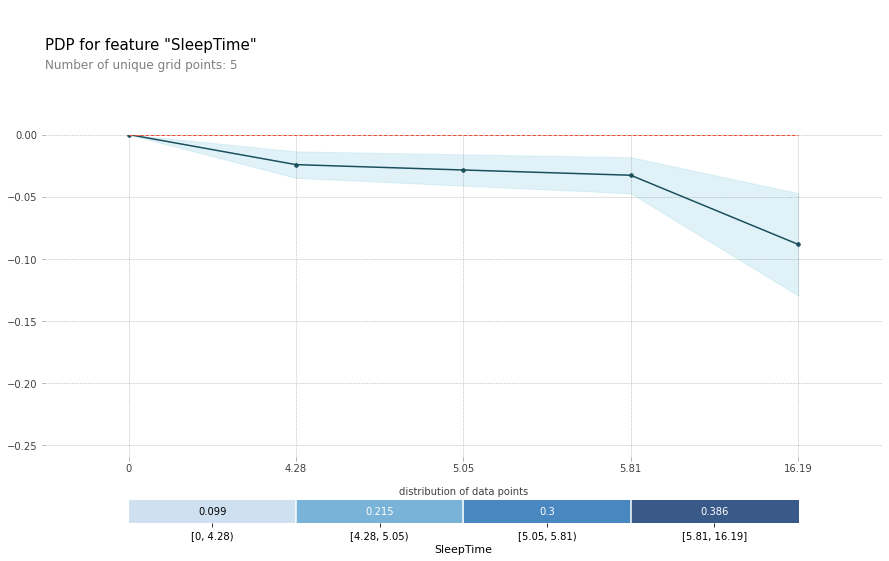

In [120]:
# PDP
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)

for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [121]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)

for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

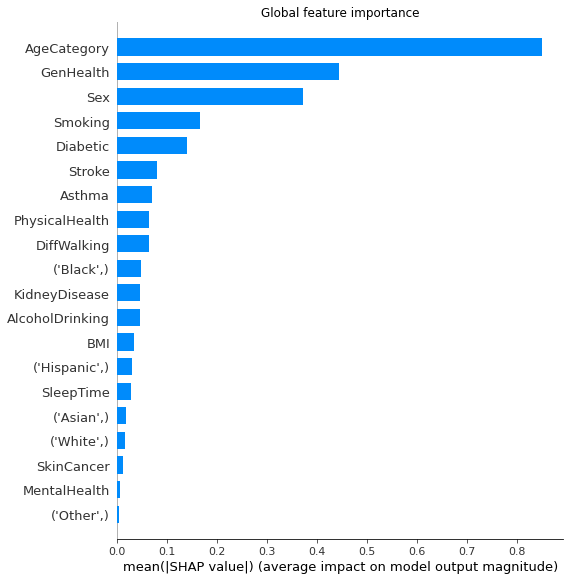

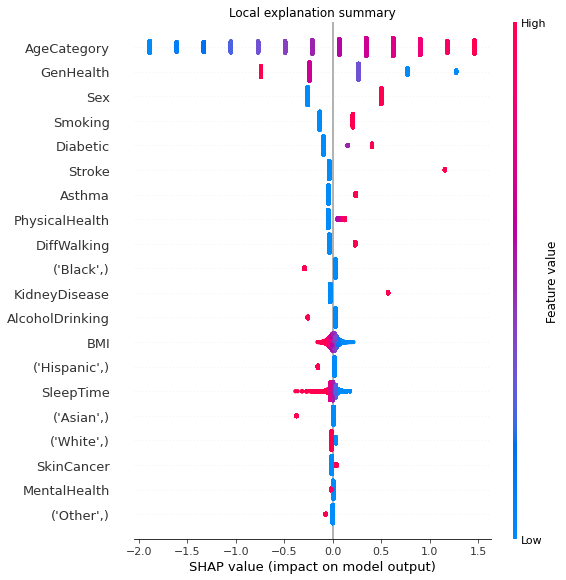

In [122]:
# SHAP
explainer = shap.Explainer(model_cost, x_train, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)